## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1096, 715)
Hypercube shape: (1096, 715, 102)


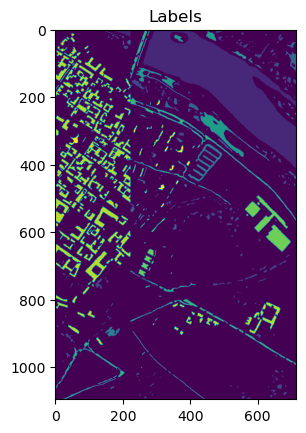

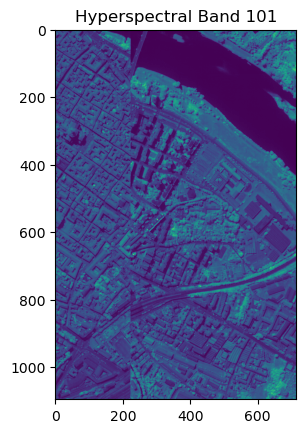

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Pavia_gt.mat'
data_files = 'Pavia.mat'
label_files = 'pavia_gt'
hypercube_files = 'pavia'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 148152
Extracted windows shape: (148152, 5, 5, 102)
Corresponding labels shape: (148152,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 65971 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 7598 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 3090 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 2685 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 6584 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 9248 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 7287 samples
Shuffled class indices for class '7'
Selected 5 training sam


 -- Test set created with: 
	148062 samples
	shape (148062, 5, 5, 102) --




All datasets saved to the 'indices' folder.
(45, 5, 5, 102)
(45, 5, 5, 102)
(148062, 5, 5, 102)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 45
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (118521, 5, 5, 102)
Validation data shape: (29631, 5, 5, 102)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

102


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/1852], Loss: 0.1599, PSNR: 5.5054


	 Training Batch [200/1852], Loss: 0.0886, PSNR: 6.6003


	 Training Batch [400/1852], Loss: 0.0457, PSNR: 8.2254


	 Training Batch [600/1852], Loss: 0.0239, PSNR: 12.5920


	 Training Batch [800/1852], Loss: 0.0175, PSNR: 14.4714


	 Training Batch [1000/1852], Loss: 0.0108, PSNR: 13.5855


	 Training Batch [1200/1852], Loss: 0.0093, PSNR: 16.9027


	 Training Batch [1400/1852], Loss: 0.0080, PSNR: 16.7460


	 Training Batch [1600/1852], Loss: 0.0066, PSNR: 17.5424


	 Training Batch [1800/1852], Loss: 0.0071, PSNR: 19.2412


Epoch [1/50] Training Loss: 0.0318, PSNR: 13.6981
	[Val]   Batch [1/463] Loss: 0.0055, PSNR: 17.8526
	[Val]   Batch [10/463] Loss: 0.0052, PSNR: 18.9700
	[Val]   Batch [20/463] Loss: 0.0052, PSNR: 17.9727
	[Val]   Batch [30/463] Loss: 0.0062, PSNR: 18.5570
	[Val]   Batch [40/463] Loss: 0.0049, PSNR: 17.6687
	[Val]   Batch [50/463] Loss: 0.0052, PSNR: 17.8630
	[Val]   Batch [60/463] Loss: 0.0049, PSNR: 17.9248


	[Val]   Batch [70/463] Loss: 0.0070, PSNR: 18.2889
	[Val]   Batch [80/463] Loss: 0.0062, PSNR: 20.1913
	[Val]   Batch [90/463] Loss: 0.0060, PSNR: 19.2747
	[Val]   Batch [100/463] Loss: 0.0060, PSNR: 19.0226
	[Val]   Batch [110/463] Loss: 0.0070, PSNR: 18.4053
	[Val]   Batch [120/463] Loss: 0.0048, PSNR: 17.9088
	[Val]   Batch [130/463] Loss: 0.0056, PSNR: 19.3107


	[Val]   Batch [140/463] Loss: 0.0066, PSNR: 18.8764
	[Val]   Batch [150/463] Loss: 0.0075, PSNR: 18.8843
	[Val]   Batch [160/463] Loss: 0.0060, PSNR: 19.1528
	[Val]   Batch [170/463] Loss: 0.0077, PSNR: 18.1274
	[Val]   Batch [180/463] Loss: 0.0056, PSNR: 18.8999
	[Val]   Batch [190/463] Loss: 0.0061, PSNR: 19.2072
	[Val]   Batch [200/463] Loss: 0.0061, PSNR: 18.5827


	[Val]   Batch [210/463] Loss: 0.0059, PSNR: 18.2174
	[Val]   Batch [220/463] Loss: 0.0058, PSNR: 19.4346
	[Val]   Batch [230/463] Loss: 0.0069, PSNR: 19.2621
	[Val]   Batch [240/463] Loss: 0.0052, PSNR: 18.0639
	[Val]   Batch [250/463] Loss: 0.0067, PSNR: 17.2410
	[Val]   Batch [260/463] Loss: 0.0059, PSNR: 18.2552
	[Val]   Batch [270/463] Loss: 0.0045, PSNR: 17.3921


	[Val]   Batch [280/463] Loss: 0.0055, PSNR: 20.1199
	[Val]   Batch [290/463] Loss: 0.0061, PSNR: 17.1397
	[Val]   Batch [300/463] Loss: 0.0061, PSNR: 19.3769
	[Val]   Batch [310/463] Loss: 0.0057, PSNR: 19.2628
	[Val]   Batch [320/463] Loss: 0.0057, PSNR: 19.1461
	[Val]   Batch [330/463] Loss: 0.0067, PSNR: 18.5322
	[Val]   Batch [340/463] Loss: 0.0055, PSNR: 19.5008


	[Val]   Batch [350/463] Loss: 0.0072, PSNR: 19.4225
	[Val]   Batch [360/463] Loss: 0.0048, PSNR: 20.3439
	[Val]   Batch [370/463] Loss: 0.0070, PSNR: 18.4959
	[Val]   Batch [380/463] Loss: 0.0070, PSNR: 18.6134
	[Val]   Batch [390/463] Loss: 0.0064, PSNR: 18.4363
	[Val]   Batch [400/463] Loss: 0.0056, PSNR: 17.5088
	[Val]   Batch [410/463] Loss: 0.0055, PSNR: 19.8116


	[Val]   Batch [420/463] Loss: 0.0057, PSNR: 18.5899
	[Val]   Batch [430/463] Loss: 0.0055, PSNR: 18.0402
	[Val]   Batch [440/463] Loss: 0.0055, PSNR: 19.0252
	[Val]   Batch [450/463] Loss: 0.0043, PSNR: 16.3671
	[Val]   Batch [460/463] Loss: 0.0060, PSNR: 17.7477
Epoch [1/50] Validation Loss: 0.0059, PSNR: 18.5801

LOG: Epoch [2/50]
	 Training Batch [1/1852], Loss: 0.0063, PSNR: 19.6337


	 Training Batch [200/1852], Loss: 0.0048, PSNR: 18.9196


	 Training Batch [400/1852], Loss: 0.0063, PSNR: 19.8106


	 Training Batch [600/1852], Loss: 0.0051, PSNR: 19.5384


	 Training Batch [800/1852], Loss: 0.0051, PSNR: 20.1006


	 Training Batch [1000/1852], Loss: 0.0042, PSNR: 20.8110


	 Training Batch [1200/1852], Loss: 0.0044, PSNR: 20.2290


	 Training Batch [1400/1852], Loss: 0.0032, PSNR: 20.5778


	 Training Batch [1600/1852], Loss: 0.0031, PSNR: 21.0836


	 Training Batch [1800/1852], Loss: 0.0036, PSNR: 21.8820


Epoch [2/50] Training Loss: 0.0045, PSNR: 19.9563
	[Val]   Batch [1/463] Loss: 0.0028, PSNR: 20.7318
	[Val]   Batch [10/463] Loss: 0.0026, PSNR: 21.9264
	[Val]   Batch [20/463] Loss: 0.0026, PSNR: 21.0147
	[Val]   Batch [30/463] Loss: 0.0033, PSNR: 21.2567
	[Val]   Batch [40/463] Loss: 0.0025, PSNR: 20.6495
	[Val]   Batch [50/463] Loss: 0.0027, PSNR: 20.7814
	[Val]   Batch [60/463] Loss: 0.0025, PSNR: 20.9150


	[Val]   Batch [70/463] Loss: 0.0038, PSNR: 20.8708
	[Val]   Batch [80/463] Loss: 0.0034, PSNR: 22.8223
	[Val]   Batch [90/463] Loss: 0.0031, PSNR: 22.1067
	[Val]   Batch [100/463] Loss: 0.0034, PSNR: 21.5794
	[Val]   Batch [110/463] Loss: 0.0038, PSNR: 21.0348
	[Val]   Batch [120/463] Loss: 0.0024, PSNR: 20.8902
	[Val]   Batch [130/463] Loss: 0.0029, PSNR: 22.1834
	[Val]   Batch [140/463] Loss: 0.0036, PSNR: 21.5380


	[Val]   Batch [150/463] Loss: 0.0041, PSNR: 21.5641
	[Val]   Batch [160/463] Loss: 0.0033, PSNR: 21.7591
	[Val]   Batch [170/463] Loss: 0.0043, PSNR: 20.6559
	[Val]   Batch [180/463] Loss: 0.0031, PSNR: 21.4286
	[Val]   Batch [190/463] Loss: 0.0032, PSNR: 22.0224
	[Val]   Batch [200/463] Loss: 0.0033, PSNR: 21.3020
	[Val]   Batch [210/463] Loss: 0.0033, PSNR: 20.7548


	[Val]   Batch [220/463] Loss: 0.0031, PSNR: 22.1398
	[Val]   Batch [230/463] Loss: 0.0037, PSNR: 21.9574
	[Val]   Batch [240/463] Loss: 0.0027, PSNR: 20.9127
	[Val]   Batch [250/463] Loss: 0.0036, PSNR: 19.9041
	[Val]   Batch [260/463] Loss: 0.0031, PSNR: 20.9686
	[Val]   Batch [270/463] Loss: 0.0022, PSNR: 20.5894
	[Val]   Batch [280/463] Loss: 0.0029, PSNR: 22.9835
	[Val]   Batch [290/463] Loss: 0.0032, PSNR: 19.9859


	[Val]   Batch [300/463] Loss: 0.0033, PSNR: 22.1330
	[Val]   Batch [310/463] Loss: 0.0031, PSNR: 21.9004
	[Val]   Batch [320/463] Loss: 0.0030, PSNR: 21.8827
	[Val]   Batch [330/463] Loss: 0.0035, PSNR: 21.3666
	[Val]   Batch [340/463] Loss: 0.0029, PSNR: 22.2922
	[Val]   Batch [350/463] Loss: 0.0041, PSNR: 21.8776
	[Val]   Batch [360/463] Loss: 0.0026, PSNR: 23.0504
	[Val]   Batch [370/463] Loss: 0.0037, PSNR: 21.2407


	[Val]   Batch [380/463] Loss: 0.0036, PSNR: 21.4873
	[Val]   Batch [390/463] Loss: 0.0033, PSNR: 21.2479
	[Val]   Batch [400/463] Loss: 0.0030, PSNR: 20.2349
	[Val]   Batch [410/463] Loss: 0.0028, PSNR: 22.7553
	[Val]   Batch [420/463] Loss: 0.0029, PSNR: 21.4478
	[Val]   Batch [430/463] Loss: 0.0030, PSNR: 20.7727
	[Val]   Batch [440/463] Loss: 0.0029, PSNR: 21.7392


	[Val]   Batch [450/463] Loss: 0.0021, PSNR: 19.3916
	[Val]   Batch [460/463] Loss: 0.0031, PSNR: 20.6222
Epoch [2/50] Validation Loss: 0.0031, PSNR: 21.3782

LOG: Epoch [3/50]
	 Training Batch [1/1852], Loss: 0.0025, PSNR: 21.8794


	 Training Batch [200/1852], Loss: 0.0032, PSNR: 21.3088


	 Training Batch [400/1852], Loss: 0.0030, PSNR: 21.6813


	 Training Batch [600/1852], Loss: 0.0025, PSNR: 22.2666


	 Training Batch [800/1852], Loss: 0.0030, PSNR: 22.2723


	 Training Batch [1000/1852], Loss: 0.0025, PSNR: 21.9842


	 Training Batch [1200/1852], Loss: 0.0022, PSNR: 23.5479


	 Training Batch [1400/1852], Loss: 0.0023, PSNR: 24.2048


	 Training Batch [1600/1852], Loss: 0.0024, PSNR: 21.8170


	 Training Batch [1800/1852], Loss: 0.0018, PSNR: 25.3146


Epoch [3/50] Training Loss: 0.0025, PSNR: 22.5127
	[Val]   Batch [1/463] Loss: 0.0015, PSNR: 23.4055
	[Val]   Batch [10/463] Loss: 0.0014, PSNR: 24.6609
	[Val]   Batch [20/463] Loss: 0.0013, PSNR: 23.8449
	[Val]   Batch [30/463] Loss: 0.0016, PSNR: 24.3606
	[Val]   Batch [40/463] Loss: 0.0015, PSNR: 22.9558
	[Val]   Batch [50/463] Loss: 0.0015, PSNR: 23.2979
	[Val]   Batch [60/463] Loss: 0.0014, PSNR: 23.3425


	[Val]   Batch [70/463] Loss: 0.0019, PSNR: 23.9649
	[Val]   Batch [80/463] Loss: 0.0017, PSNR: 25.9269
	[Val]   Batch [90/463] Loss: 0.0016, PSNR: 24.9186
	[Val]   Batch [100/463] Loss: 0.0017, PSNR: 24.4940
	[Val]   Batch [110/463] Loss: 0.0019, PSNR: 24.1985
	[Val]   Batch [120/463] Loss: 0.0014, PSNR: 23.2231


	[Val]   Batch [130/463] Loss: 0.0014, PSNR: 25.2703
	[Val]   Batch [140/463] Loss: 0.0018, PSNR: 24.4950
	[Val]   Batch [150/463] Loss: 0.0018, PSNR: 25.1114
	[Val]   Batch [160/463] Loss: 0.0019, PSNR: 24.2671
	[Val]   Batch [170/463] Loss: 0.0022, PSNR: 23.5414
	[Val]   Batch [180/463] Loss: 0.0017, PSNR: 24.0868
	[Val]   Batch [190/463] Loss: 0.0016, PSNR: 25.0564
	[Val]   Batch [200/463] Loss: 0.0016, PSNR: 24.4068


	[Val]   Batch [210/463] Loss: 0.0019, PSNR: 23.2464
	[Val]   Batch [220/463] Loss: 0.0017, PSNR: 24.6611
	[Val]   Batch [230/463] Loss: 0.0016, PSNR: 25.6255
	[Val]   Batch [240/463] Loss: 0.0015, PSNR: 23.6131
	[Val]   Batch [250/463] Loss: 0.0020, PSNR: 22.5750
	[Val]   Batch [260/463] Loss: 0.0017, PSNR: 23.6395
	[Val]   Batch [270/463] Loss: 0.0013, PSNR: 22.9290


	[Val]   Batch [280/463] Loss: 0.0015, PSNR: 25.6562
	[Val]   Batch [290/463] Loss: 0.0017, PSNR: 22.7514
	[Val]   Batch [300/463] Loss: 0.0018, PSNR: 24.7876
	[Val]   Batch [310/463] Loss: 0.0018, PSNR: 24.2139
	[Val]   Batch [320/463] Loss: 0.0016, PSNR: 24.6274
	[Val]   Batch [330/463] Loss: 0.0017, PSNR: 24.5926
	[Val]   Batch [340/463] Loss: 0.0015, PSNR: 25.0027


	[Val]   Batch [350/463] Loss: 0.0021, PSNR: 24.7610
	[Val]   Batch [360/463] Loss: 0.0017, PSNR: 24.7787
	[Val]   Batch [370/463] Loss: 0.0018, PSNR: 24.3683
	[Val]   Batch [380/463] Loss: 0.0016, PSNR: 25.0292
	[Val]   Batch [390/463] Loss: 0.0016, PSNR: 24.5717
	[Val]   Batch [400/463] Loss: 0.0017, PSNR: 22.6564


	[Val]   Batch [410/463] Loss: 0.0015, PSNR: 25.5172
	[Val]   Batch [420/463] Loss: 0.0015, PSNR: 24.3690
	[Val]   Batch [430/463] Loss: 0.0017, PSNR: 23.1279
	[Val]   Batch [440/463] Loss: 0.0016, PSNR: 24.2366
	[Val]   Batch [450/463] Loss: 0.0014, PSNR: 21.3174
	[Val]   Batch [460/463] Loss: 0.0016, PSNR: 23.4018
Epoch [3/50] Validation Loss: 0.0016, PSNR: 24.1894

LOG: Epoch [4/50]
	 Training Batch [1/1852], Loss: 0.0024, PSNR: 23.5233


	 Training Batch [200/1852], Loss: 0.0023, PSNR: 23.0160


	 Training Batch [400/1852], Loss: 0.0017, PSNR: 23.8719


	 Training Batch [600/1852], Loss: 0.0020, PSNR: 23.0632


	 Training Batch [800/1852], Loss: 0.0019, PSNR: 24.3396


	 Training Batch [1000/1852], Loss: 0.0016, PSNR: 25.7059


	 Training Batch [1200/1852], Loss: 0.0014, PSNR: 24.4689


	 Training Batch [1400/1852], Loss: 0.0015, PSNR: 24.5627


	 Training Batch [1600/1852], Loss: 0.0014, PSNR: 23.7621


	 Training Batch [1800/1852], Loss: 0.0014, PSNR: 24.4174


Epoch [4/50] Training Loss: 0.0016, PSNR: 24.2481
	[Val]   Batch [1/463] Loss: 0.0011, PSNR: 24.7320
	[Val]   Batch [10/463] Loss: 0.0010, PSNR: 26.0058
	[Val]   Batch [20/463] Loss: 0.0010, PSNR: 25.2260
	[Val]   Batch [30/463] Loss: 0.0012, PSNR: 25.7630
	[Val]   Batch [40/463] Loss: 0.0011, PSNR: 24.2011
	[Val]   Batch [50/463] Loss: 0.0011, PSNR: 24.5920
	[Val]   Batch [60/463] Loss: 0.0011, PSNR: 24.6275


	[Val]   Batch [70/463] Loss: 0.0014, PSNR: 25.3739
	[Val]   Batch [80/463] Loss: 0.0012, PSNR: 27.4890
	[Val]   Batch [90/463] Loss: 0.0012, PSNR: 26.3188
	[Val]   Batch [100/463] Loss: 0.0012, PSNR: 25.9280
	[Val]   Batch [110/463] Loss: 0.0013, PSNR: 25.7137
	[Val]   Batch [120/463] Loss: 0.0010, PSNR: 24.5401
	[Val]   Batch [130/463] Loss: 0.0010, PSNR: 26.7197
	[Val]   Batch [140/463] Loss: 0.0013, PSNR: 25.8956


	[Val]   Batch [150/463] Loss: 0.0013, PSNR: 26.6358
	[Val]   Batch [160/463] Loss: 0.0014, PSNR: 25.5056
	[Val]   Batch [170/463] Loss: 0.0016, PSNR: 24.8358
	[Val]   Batch [180/463] Loss: 0.0013, PSNR: 25.3732
	[Val]   Batch [190/463] Loss: 0.0012, PSNR: 26.3894
	[Val]   Batch [200/463] Loss: 0.0011, PSNR: 25.9094
	[Val]   Batch [210/463] Loss: 0.0014, PSNR: 24.4843


	[Val]   Batch [220/463] Loss: 0.0013, PSNR: 25.9797
	[Val]   Batch [230/463] Loss: 0.0011, PSNR: 27.2525
	[Val]   Batch [240/463] Loss: 0.0011, PSNR: 25.0158
	[Val]   Batch [250/463] Loss: 0.0015, PSNR: 23.8318
	[Val]   Batch [260/463] Loss: 0.0013, PSNR: 24.8440
	[Val]   Batch [270/463] Loss: 0.0009, PSNR: 24.2910
	[Val]   Batch [280/463] Loss: 0.0011, PSNR: 27.0085
	[Val]   Batch [290/463] Loss: 0.0012, PSNR: 24.1823


	[Val]   Batch [300/463] Loss: 0.0013, PSNR: 26.0169
	[Val]   Batch [310/463] Loss: 0.0014, PSNR: 25.4843
	[Val]   Batch [320/463] Loss: 0.0012, PSNR: 26.0348
	[Val]   Batch [330/463] Loss: 0.0012, PSNR: 26.0611
	[Val]   Batch [340/463] Loss: 0.0011, PSNR: 26.3675
	[Val]   Batch [350/463] Loss: 0.0015, PSNR: 26.1446
	[Val]   Batch [360/463] Loss: 0.0014, PSNR: 25.7836


	[Val]   Batch [370/463] Loss: 0.0013, PSNR: 25.8450
	[Val]   Batch [380/463] Loss: 0.0011, PSNR: 26.6151
	[Val]   Batch [390/463] Loss: 0.0011, PSNR: 26.1144
	[Val]   Batch [400/463] Loss: 0.0013, PSNR: 23.8963
	[Val]   Batch [410/463] Loss: 0.0011, PSNR: 26.9299
	[Val]   Batch [420/463] Loss: 0.0011, PSNR: 25.6725
	[Val]   Batch [430/463] Loss: 0.0013, PSNR: 24.2981


	[Val]   Batch [440/463] Loss: 0.0012, PSNR: 25.5745
	[Val]   Batch [450/463] Loss: 0.0010, PSNR: 22.5764
	[Val]   Batch [460/463] Loss: 0.0012, PSNR: 24.7034
Epoch [4/50] Validation Loss: 0.0012, PSNR: 25.5714

LOG: Epoch [5/50]
	 Training Batch [1/1852], Loss: 0.0017, PSNR: 27.5698


	 Training Batch [200/1852], Loss: 0.0013, PSNR: 25.1921


	 Training Batch [400/1852], Loss: 0.0015, PSNR: 25.7944


	 Training Batch [600/1852], Loss: 0.0014, PSNR: 25.6286


	 Training Batch [800/1852], Loss: 0.0011, PSNR: 26.7528


	 Training Batch [1000/1852], Loss: 0.0013, PSNR: 25.8212


	 Training Batch [1200/1852], Loss: 0.0011, PSNR: 25.8769


	 Training Batch [1400/1852], Loss: 0.0014, PSNR: 26.2090


	 Training Batch [1600/1852], Loss: 0.0011, PSNR: 25.0662


	 Training Batch [1800/1852], Loss: 0.0017, PSNR: 24.4031


Epoch [5/50] Training Loss: 0.0013, PSNR: 25.3427
	[Val]   Batch [1/463] Loss: 0.0009, PSNR: 25.6808
	[Val]   Batch [10/463] Loss: 0.0008, PSNR: 27.0278
	[Val]   Batch [20/463] Loss: 0.0008, PSNR: 26.2584
	[Val]   Batch [30/463] Loss: 0.0009, PSNR: 26.7109
	[Val]   Batch [40/463] Loss: 0.0009, PSNR: 25.1239
	[Val]   Batch [50/463] Loss: 0.0009, PSNR: 25.5848
	[Val]   Batch [60/463] Loss: 0.0008, PSNR: 25.5833


	[Val]   Batch [70/463] Loss: 0.0011, PSNR: 26.3612
	[Val]   Batch [80/463] Loss: 0.0009, PSNR: 28.6800
	[Val]   Batch [90/463] Loss: 0.0009, PSNR: 27.3504
	[Val]   Batch [100/463] Loss: 0.0010, PSNR: 26.9731
	[Val]   Batch [110/463] Loss: 0.0010, PSNR: 26.8035
	[Val]   Batch [120/463] Loss: 0.0008, PSNR: 25.5790
	[Val]   Batch [130/463] Loss: 0.0008, PSNR: 27.7341
	[Val]   Batch [140/463] Loss: 0.0010, PSNR: 26.9768


	[Val]   Batch [150/463] Loss: 0.0010, PSNR: 27.6939
	[Val]   Batch [160/463] Loss: 0.0011, PSNR: 26.4181
	[Val]   Batch [170/463] Loss: 0.0013, PSNR: 25.7230
	[Val]   Batch [180/463] Loss: 0.0010, PSNR: 26.3732
	[Val]   Batch [190/463] Loss: 0.0009, PSNR: 27.3727
	[Val]   Batch [200/463] Loss: 0.0009, PSNR: 27.0443
	[Val]   Batch [210/463] Loss: 0.0011, PSNR: 25.4275
	[Val]   Batch [220/463] Loss: 0.0010, PSNR: 26.9066


	[Val]   Batch [230/463] Loss: 0.0008, PSNR: 28.3994
	[Val]   Batch [240/463] Loss: 0.0008, PSNR: 26.0646
	[Val]   Batch [250/463] Loss: 0.0012, PSNR: 24.7766
	[Val]   Batch [260/463] Loss: 0.0011, PSNR: 25.6959
	[Val]   Batch [270/463] Loss: 0.0007, PSNR: 25.3965
	[Val]   Batch [280/463] Loss: 0.0009, PSNR: 28.0517
	[Val]   Batch [290/463] Loss: 0.0009, PSNR: 25.2188


	[Val]   Batch [300/463] Loss: 0.0011, PSNR: 26.9267
	[Val]   Batch [310/463] Loss: 0.0011, PSNR: 26.4548
	[Val]   Batch [320/463] Loss: 0.0009, PSNR: 27.1489
	[Val]   Batch [330/463] Loss: 0.0009, PSNR: 27.1173
	[Val]   Batch [340/463] Loss: 0.0009, PSNR: 27.4345
	[Val]   Batch [350/463] Loss: 0.0012, PSNR: 27.0926
	[Val]   Batch [360/463] Loss: 0.0012, PSNR: 26.5357


	[Val]   Batch [370/463] Loss: 0.0010, PSNR: 26.9012
	[Val]   Batch [380/463] Loss: 0.0008, PSNR: 27.7542
	[Val]   Batch [390/463] Loss: 0.0008, PSNR: 27.2098
	[Val]   Batch [400/463] Loss: 0.0010, PSNR: 24.8441
	[Val]   Batch [410/463] Loss: 0.0008, PSNR: 27.9730
	[Val]   Batch [420/463] Loss: 0.0009, PSNR: 26.6607
	[Val]   Batch [430/463] Loss: 0.0011, PSNR: 25.1816


	[Val]   Batch [440/463] Loss: 0.0010, PSNR: 26.5431
	[Val]   Batch [450/463] Loss: 0.0008, PSNR: 23.5912
	[Val]   Batch [460/463] Loss: 0.0010, PSNR: 25.6483
Epoch [5/50] Validation Loss: 0.0009, PSNR: 26.5917

LOG: Epoch [6/50]
	 Training Batch [1/1852], Loss: 0.0017, PSNR: 25.5854


	 Training Batch [200/1852], Loss: 0.0014, PSNR: 25.2367


	 Training Batch [400/1852], Loss: 0.0010, PSNR: 25.9345


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 26.3836


	 Training Batch [800/1852], Loss: 0.0010, PSNR: 26.3737


	 Training Batch [1000/1852], Loss: 0.0011, PSNR: 26.3296


	 Training Batch [1200/1852], Loss: 0.0009, PSNR: 26.6289


	 Training Batch [1400/1852], Loss: 0.0009, PSNR: 23.5514


	 Training Batch [1600/1852], Loss: 0.0011, PSNR: 25.9888


	 Training Batch [1800/1852], Loss: 0.0008, PSNR: 28.7632


Epoch [6/50] Training Loss: 0.0010, PSNR: 26.1816
	[Val]   Batch [1/463] Loss: 0.0007, PSNR: 26.6426
	[Val]   Batch [10/463] Loss: 0.0006, PSNR: 28.0403
	[Val]   Batch [20/463] Loss: 0.0006, PSNR: 27.3094
	[Val]   Batch [30/463] Loss: 0.0008, PSNR: 27.6656
	[Val]   Batch [40/463] Loss: 0.0007, PSNR: 26.0485
	[Val]   Batch [50/463] Loss: 0.0007, PSNR: 26.6150
	[Val]   Batch [60/463] Loss: 0.0007, PSNR: 26.4932


	[Val]   Batch [70/463] Loss: 0.0009, PSNR: 27.3193
	[Val]   Batch [80/463] Loss: 0.0007, PSNR: 29.8260
	[Val]   Batch [90/463] Loss: 0.0007, PSNR: 28.3712
	[Val]   Batch [100/463] Loss: 0.0008, PSNR: 27.9434
	[Val]   Batch [110/463] Loss: 0.0008, PSNR: 27.8256
	[Val]   Batch [120/463] Loss: 0.0006, PSNR: 26.5988
	[Val]   Batch [130/463] Loss: 0.0006, PSNR: 28.7276
	[Val]   Batch [140/463] Loss: 0.0008, PSNR: 28.0085


	[Val]   Batch [150/463] Loss: 0.0008, PSNR: 28.7322
	[Val]   Batch [160/463] Loss: 0.0009, PSNR: 27.2970
	[Val]   Batch [170/463] Loss: 0.0011, PSNR: 26.6093
	[Val]   Batch [180/463] Loss: 0.0008, PSNR: 27.3313
	[Val]   Batch [190/463] Loss: 0.0007, PSNR: 28.3304
	[Val]   Batch [200/463] Loss: 0.0007, PSNR: 28.1650
	[Val]   Batch [210/463] Loss: 0.0009, PSNR: 26.3482


	[Val]   Batch [220/463] Loss: 0.0008, PSNR: 27.8582
	[Val]   Batch [230/463] Loss: 0.0007, PSNR: 29.5068
	[Val]   Batch [240/463] Loss: 0.0006, PSNR: 27.1076
	[Val]   Batch [250/463] Loss: 0.0010, PSNR: 25.6894
	[Val]   Batch [260/463] Loss: 0.0009, PSNR: 26.5614
	[Val]   Batch [270/463] Loss: 0.0006, PSNR: 26.5362
	[Val]   Batch [280/463] Loss: 0.0007, PSNR: 29.0635


	[Val]   Batch [290/463] Loss: 0.0008, PSNR: 26.2360
	[Val]   Batch [300/463] Loss: 0.0009, PSNR: 27.7941
	[Val]   Batch [310/463] Loss: 0.0009, PSNR: 27.4170
	[Val]   Batch [320/463] Loss: 0.0007, PSNR: 28.2307
	[Val]   Batch [330/463] Loss: 0.0007, PSNR: 28.1431
	[Val]   Batch [340/463] Loss: 0.0007, PSNR: 28.4422
	[Val]   Batch [350/463] Loss: 0.0010, PSNR: 28.0260
	[Val]   Batch [360/463] Loss: 0.0010, PSNR: 27.2119


	[Val]   Batch [370/463] Loss: 0.0008, PSNR: 27.9400
	[Val]   Batch [380/463] Loss: 0.0006, PSNR: 28.9102
	[Val]   Batch [390/463] Loss: 0.0007, PSNR: 28.2711
	[Val]   Batch [400/463] Loss: 0.0008, PSNR: 25.7610
	[Val]   Batch [410/463] Loss: 0.0007, PSNR: 28.9438
	[Val]   Batch [420/463] Loss: 0.0007, PSNR: 27.6948
	[Val]   Batch [430/463] Loss: 0.0009, PSNR: 26.0495


	[Val]   Batch [440/463] Loss: 0.0008, PSNR: 27.4429
	[Val]   Batch [450/463] Loss: 0.0006, PSNR: 24.5741
	[Val]   Batch [460/463] Loss: 0.0008, PSNR: 26.6077
Epoch [6/50] Validation Loss: 0.0007, PSNR: 27.5969

LOG: Epoch [7/50]
	 Training Batch [1/1852], Loss: 0.0010, PSNR: 27.0560


	 Training Batch [200/1852], Loss: 0.0009, PSNR: 25.2580


	 Training Batch [400/1852], Loss: 0.0010, PSNR: 25.5778


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 25.9453


	 Training Batch [800/1852], Loss: 0.0009, PSNR: 27.2224


	 Training Batch [1000/1852], Loss: 0.0009, PSNR: 27.2937


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 25.9935


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 26.8468


	 Training Batch [1600/1852], Loss: 0.0011, PSNR: 27.5893


	 Training Batch [1800/1852], Loss: 0.0009, PSNR: 26.6605


Epoch [7/50] Training Loss: 0.0009, PSNR: 26.8633
	[Val]   Batch [1/463] Loss: 0.0006, PSNR: 27.3683
	[Val]   Batch [10/463] Loss: 0.0005, PSNR: 28.8560
	[Val]   Batch [20/463] Loss: 0.0005, PSNR: 28.0941
	[Val]   Batch [30/463] Loss: 0.0006, PSNR: 28.4028
	[Val]   Batch [40/463] Loss: 0.0006, PSNR: 26.7753
	[Val]   Batch [50/463] Loss: 0.0006, PSNR: 27.4286
	[Val]   Batch [60/463] Loss: 0.0006, PSNR: 27.2170


	[Val]   Batch [70/463] Loss: 0.0007, PSNR: 28.0975
	[Val]   Batch [80/463] Loss: 0.0005, PSNR: 30.7789
	[Val]   Batch [90/463] Loss: 0.0006, PSNR: 29.2107
	[Val]   Batch [100/463] Loss: 0.0006, PSNR: 28.7440
	[Val]   Batch [110/463] Loss: 0.0007, PSNR: 28.6411
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 27.3524
	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 29.4880


	[Val]   Batch [140/463] Loss: 0.0007, PSNR: 28.7520
	[Val]   Batch [150/463] Loss: 0.0006, PSNR: 29.5762
	[Val]   Batch [160/463] Loss: 0.0008, PSNR: 28.0150
	[Val]   Batch [170/463] Loss: 0.0009, PSNR: 27.3347
	[Val]   Batch [180/463] Loss: 0.0007, PSNR: 28.1009
	[Val]   Batch [190/463] Loss: 0.0006, PSNR: 29.0821
	[Val]   Batch [200/463] Loss: 0.0006, PSNR: 29.0337
	[Val]   Batch [210/463] Loss: 0.0008, PSNR: 27.0788


	[Val]   Batch [220/463] Loss: 0.0007, PSNR: 28.5505
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 30.3409
	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 27.8970
	[Val]   Batch [250/463] Loss: 0.0008, PSNR: 26.4401
	[Val]   Batch [260/463] Loss: 0.0007, PSNR: 27.2339
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 27.4222
	[Val]   Batch [280/463] Loss: 0.0006, PSNR: 29.8343


	[Val]   Batch [290/463] Loss: 0.0006, PSNR: 27.0491
	[Val]   Batch [300/463] Loss: 0.0008, PSNR: 28.4412
	[Val]   Batch [310/463] Loss: 0.0007, PSNR: 28.1718
	[Val]   Batch [320/463] Loss: 0.0006, PSNR: 29.0788
	[Val]   Batch [330/463] Loss: 0.0006, PSNR: 28.9941
	[Val]   Batch [340/463] Loss: 0.0006, PSNR: 29.2260
	[Val]   Batch [350/463] Loss: 0.0008, PSNR: 28.7976


	[Val]   Batch [360/463] Loss: 0.0009, PSNR: 27.7306
	[Val]   Batch [370/463] Loss: 0.0007, PSNR: 28.7472
	[Val]   Batch [380/463] Loss: 0.0005, PSNR: 29.7925
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.1155
	[Val]   Batch [400/463] Loss: 0.0007, PSNR: 26.4478
	[Val]   Batch [410/463] Loss: 0.0006, PSNR: 29.7034
	[Val]   Batch [420/463] Loss: 0.0006, PSNR: 28.4736


	[Val]   Batch [430/463] Loss: 0.0007, PSNR: 26.7558
	[Val]   Batch [440/463] Loss: 0.0007, PSNR: 28.1654
	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 25.3015
	[Val]   Batch [460/463] Loss: 0.0007, PSNR: 27.3292
Epoch [7/50] Validation Loss: 0.0006, PSNR: 28.3815

LOG: Epoch [8/50]
	 Training Batch [1/1852], Loss: 0.0011, PSNR: 27.0629


	 Training Batch [200/1852], Loss: 0.0008, PSNR: 26.9613


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 27.2807


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 27.5855


	 Training Batch [800/1852], Loss: 0.0008, PSNR: 26.4383


	 Training Batch [1000/1852], Loss: 0.0008, PSNR: 27.1887


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 29.1608


	 Training Batch [1400/1852], Loss: 0.0009, PSNR: 26.9471


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 27.5126


	 Training Batch [1800/1852], Loss: 0.0009, PSNR: 27.5880


Epoch [8/50] Training Loss: 0.0008, PSNR: 27.4526
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.0132
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 29.5771
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 28.8335
	[Val]   Batch [30/463] Loss: 0.0006, PSNR: 29.0713
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.4906
	[Val]   Batch [50/463] Loss: 0.0005, PSNR: 28.1813
	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 27.8843


	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 28.7691
	[Val]   Batch [80/463] Loss: 0.0005, PSNR: 31.5430
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 29.8953
	[Val]   Batch [100/463] Loss: 0.0006, PSNR: 29.3855
	[Val]   Batch [110/463] Loss: 0.0006, PSNR: 29.3924
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 28.0289
	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 30.1716
	[Val]   Batch [140/463] Loss: 0.0006, PSNR: 29.4383


	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 30.3249
	[Val]   Batch [160/463] Loss: 0.0007, PSNR: 28.7021
	[Val]   Batch [170/463] Loss: 0.0008, PSNR: 27.9488
	[Val]   Batch [180/463] Loss: 0.0006, PSNR: 28.7925
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 29.7428
	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.7543
	[Val]   Batch [210/463] Loss: 0.0007, PSNR: 27.7728


	[Val]   Batch [220/463] Loss: 0.0006, PSNR: 29.2394
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 30.9910
	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 28.5804
	[Val]   Batch [250/463] Loss: 0.0007, PSNR: 27.1196
	[Val]   Batch [260/463] Loss: 0.0006, PSNR: 27.9409
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 28.2445
	[Val]   Batch [280/463] Loss: 0.0005, PSNR: 30.5640
	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 27.7530


	[Val]   Batch [300/463] Loss: 0.0007, PSNR: 29.0283
	[Val]   Batch [310/463] Loss: 0.0006, PSNR: 28.8638
	[Val]   Batch [320/463] Loss: 0.0005, PSNR: 29.8229
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 29.6889
	[Val]   Batch [340/463] Loss: 0.0005, PSNR: 29.9800
	[Val]   Batch [350/463] Loss: 0.0007, PSNR: 29.4325
	[Val]   Batch [360/463] Loss: 0.0008, PSNR: 28.1893


	[Val]   Batch [370/463] Loss: 0.0006, PSNR: 29.4128
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 30.5950
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.8196
	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 27.0887
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 30.3316
	[Val]   Batch [420/463] Loss: 0.0005, PSNR: 29.2037
	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 27.4476


	[Val]   Batch [440/463] Loss: 0.0006, PSNR: 28.8468
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.1324
	[Val]   Batch [460/463] Loss: 0.0006, PSNR: 28.0540
Epoch [8/50] Validation Loss: 0.0005, PSNR: 29.0861

LOG: Epoch [9/50]
	 Training Batch [1/1852], Loss: 0.0008, PSNR: 28.5711


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 28.7647


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 26.9558


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 26.8087


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 26.7759


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 28.6738


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 27.4036


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 28.7147


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 26.7115


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 27.7242


Epoch [9/50] Training Loss: 0.0007, PSNR: 27.9849
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.5678
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 30.1560
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 29.3868
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.6341
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.9806
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 28.7607
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.4315


	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 29.3423
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.1508
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 30.4771
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 29.9887
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 30.0022
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.5234
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 30.7381
	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 29.9975


	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 30.9958
	[Val]   Batch [160/463] Loss: 0.0006, PSNR: 29.2319
	[Val]   Batch [170/463] Loss: 0.0007, PSNR: 28.5379
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.3179
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 30.2791
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.2698
	[Val]   Batch [210/463] Loss: 0.0006, PSNR: 28.3672
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 29.7298


	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.5978
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.1584
	[Val]   Batch [250/463] Loss: 0.0006, PSNR: 27.6596
	[Val]   Batch [260/463] Loss: 0.0006, PSNR: 28.5116
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 28.7973
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.1570
	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 28.3256


	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.5106
	[Val]   Batch [310/463] Loss: 0.0006, PSNR: 29.3920
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.4374
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.3091
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 30.5565
	[Val]   Batch [350/463] Loss: 0.0006, PSNR: 30.0396
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.5223
	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 30.0363


	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 31.2604
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.4211
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 27.6074
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 30.8555
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 29.7408
	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 27.9868
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.3936


	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.6491
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.6338
Epoch [9/50] Validation Loss: 0.0005, PSNR: 29.6543

LOG: Epoch [10/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 28.0775


	 Training Batch [200/1852], Loss: 0.0010, PSNR: 26.8477


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 28.0516


	 Training Batch [600/1852], Loss: 0.0010, PSNR: 26.8387


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 28.5204


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 28.9502


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 29.3832


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 27.8864


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 27.5251


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 29.4557


Epoch [10/50] Training Loss: 0.0006, PSNR: 28.4335
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.1159
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 30.7777
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 29.8466
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.2190
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.4992
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 29.3554
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.9581


	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 29.9680
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 32.7610
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 31.0773
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.6142
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.6036
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 29.0105
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 31.2875
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 30.5482


	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.6911
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 29.8428
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.1617
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 29.9734
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 30.7889
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.7860
	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 29.0285


	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.2473
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 32.1952
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.7452
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.3505
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 29.1594
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.2885
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.6383


	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 29.0344
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 29.9099
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 29.9510
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 31.0092
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.9034
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 31.1152
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 30.6306


	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.8602
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.6472
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 31.8493
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.9975
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 28.1669
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.3450
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.3264


	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.6221
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.8552
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 27.1457
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.2113
Epoch [10/50] Validation Loss: 0.0004, PSNR: 30.2276

LOG: Epoch [11/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 27.2412


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 31.3278


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 28.4440


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 29.4053


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 28.2512


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 28.2500


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 31.0196


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 30.0642


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 27.2631


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 26.3358


Epoch [11/50] Training Loss: 0.0006, PSNR: 28.7787
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.5839
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.3398
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.4388
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.7323
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 29.0575
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 29.9951
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.5461


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.5258
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.3731
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 31.6828
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 31.1752
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 31.2047
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.5526
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.8313
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.1116


	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.3645
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.4204
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 29.7108
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.4825
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.2999
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.3930
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.6351
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.7101


	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.7724
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.3392
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.8953
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 29.7998
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.9451
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.1554
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.6070
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.4454


	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.5189
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.6134
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.5124
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.7018
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 31.2073
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.2051
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.2287


	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.5389
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.6118
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.6263
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 31.8753
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 30.8578
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.1518
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.3502
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.7188


	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.7696
Epoch [11/50] Validation Loss: 0.0004, PSNR: 30.8078

LOG: Epoch [12/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 28.8234


	 Training Batch [200/1852], Loss: 0.0008, PSNR: 28.6554


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 27.5226


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 28.8902


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 28.4932


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 29.7086


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 29.5564


	 Training Batch [1400/1852], Loss: 0.0004, PSNR: 28.3670


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 29.3654


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 29.7490


Epoch [12/50] Training Loss: 0.0005, PSNR: 29.1355
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 29.8738
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.6123
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.6789
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.0744
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.2828
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.2979
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.8483


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.9007
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.6825
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 31.9440
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.5173
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.4981
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.7566
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.0908


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.4222
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.7464
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.8089
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 30.0726
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.8211
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.5751
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.6801
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 30.0466


	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.9855
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.0603
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.6343
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.2066
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 30.1653
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.1395
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.4230


	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.8789
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 30.7396
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.8292
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.8828
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.7894
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.9536


	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.5524
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.3287
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.5236
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.8886
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.8691
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.9199
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.0837


	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.1221
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.4384
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.6039
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.9800
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.1075
Epoch [12/50] Validation Loss: 0.0003, PSNR: 31.0987

LOG: Epoch [13/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 30.0803


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 28.7099


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 28.4351


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 30.7675


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 30.5557


	 Training Batch [1000/1852], Loss: 0.0004, PSNR: 30.6058


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 30.1105


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 28.5197


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 27.9766


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 28.0763


Epoch [13/50] Training Loss: 0.0005, PSNR: 29.4283
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.2701
	[Val]   Batch [10/463] Loss: 0.0002, PSNR: 32.1424
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.1669
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.5147
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.7408
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.8263
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.3485


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.3562
	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.1789
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.4197
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.9688
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.9916
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.2269
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.5712
	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 31.8649


	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.2685
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.2944
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.4849
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.2719
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 32.0001
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.1977
	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.5203


	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.4249
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.4865
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 31.1897
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.6429
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.7081
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.7354
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.8652
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.4214


	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.1997
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 31.3227
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.4108
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.2871
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.4478
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 32.0003
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.6137
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.9813


	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.4000
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.3374
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.3399
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.5394
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.6292
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.9042
	[Val]   Batch [440/463] Loss: 0.0003, PSNR: 30.9947


	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.5110
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.5840
Epoch [13/50] Validation Loss: 0.0003, PSNR: 31.5864

LOG: Epoch [14/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 29.0681


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 29.8276


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 27.9173


	 Training Batch [600/1852], Loss: 0.0004, PSNR: 29.1593


	 Training Batch [800/1852], Loss: 0.0004, PSNR: 30.2884


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 29.1501


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 31.1853


	 Training Batch [1400/1852], Loss: 0.0004, PSNR: 29.8134


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 30.2841


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 30.3957


Epoch [14/50] Training Loss: 0.0005, PSNR: 29.6800
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.1730
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 32.0061
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 31.0235
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.3268
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.6681
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.8414


	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.3058
	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.2715
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 34.0460
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.2523
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.8467
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.8169
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.1687


	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.3977
	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 31.7497
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.1751
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.3806
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.5231
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.2622
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.8539


	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.0500
	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.5414
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.2237
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.2529
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 31.0764
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.7092
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.7734


	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.5479
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.6347
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.2688
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.0608
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 31.2940
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.2446


	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.0971
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.3719
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.8965
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.6254
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.8135
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.2025
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.1334
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.2678


	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.3561
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.5462
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.9239
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.8377
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.4162
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.6185
Epoch [14/50] Validation Loss: 0.0003, PSNR: 31.4774
Early stopping triggered at epoch 14. No improvement for 3 epochs.


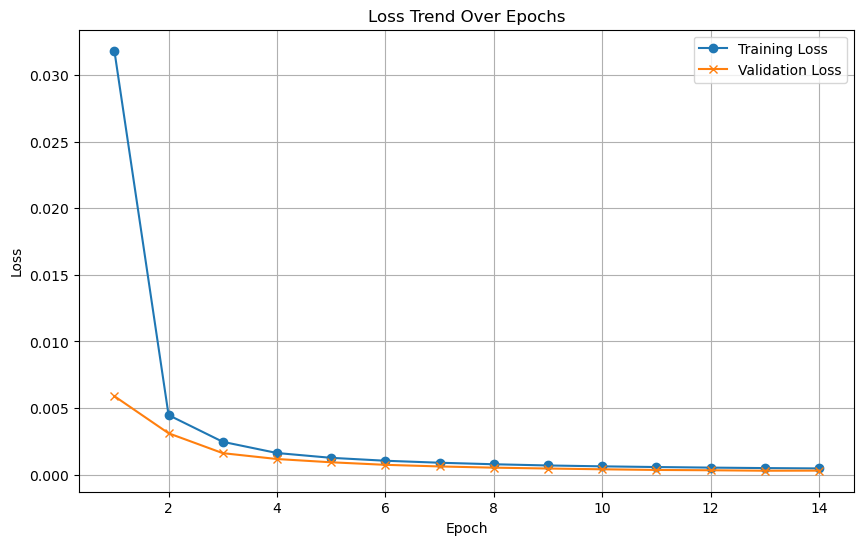

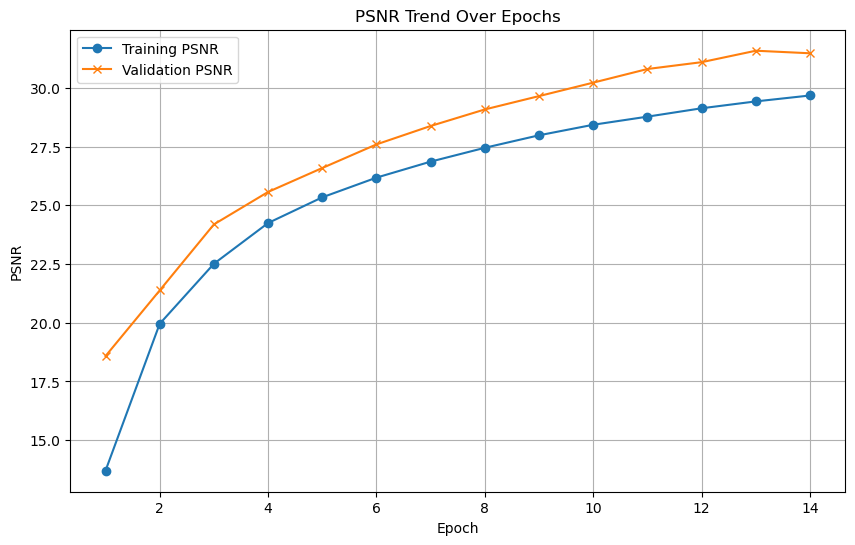

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/579 for test dataset.


    Processed batch 101/579 for test dataset.


    Processed batch 201/579 for test dataset.


    Processed batch 301/579 for test dataset.


    Processed batch 401/579 for test dataset.


    Processed batch 501/579 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2045
    Validation Batch [1/1], Loss: 2.1988
Validation Loss: 2.1988, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.1988. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1452
    Validation Batch [1/1], Loss: 2.1988
Validation Loss: 2.1988, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1013
    Validation Batch [1/1], Loss: 2.1988
Validation Loss: 2.1988, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0881
    Validation Batch [1/1], Loss: 2.1988
Validation Loss: 2.1988, Validation Accuracy: 11.11%
Validation loss improved from 2.1988 to 2.1988. Saving model...

LOG: Epoch [5/1000] - Training
Epoch [5/1000] co


LOG: Epoch [8/1000] - Training
Epoch [8/1000] completed, Average Training Loss: 2.0194
    Validation Batch [1/1], Loss: 2.1986
Validation Loss: 2.1986, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 1.9693
    Validation Batch [1/1], Loss: 2.1986
Validation Loss: 2.1986, Validation Accuracy: 11.11%
Validation loss improved from 2.1986 to 2.1986. Saving model...

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 1.9531
    Validation Batch [1/1], Loss: 2.1985
Validation Loss: 2.1985, Validation Accuracy: 11.11%
Validation loss improved from 2.1986 to 2.1985. Saving model...

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 1.9331
    Validation Batch [1/1], Loss: 2.1985
Validation Loss: 2.1985, Validation Accuracy: 11.11%
Validation loss improved from 2.1985 to 2.1985. Saving model...

LOG: Epoch [12/1000] - Tra

    Validation Batch [1/1], Loss: 2.0122
Validation Loss: 2.0122, Validation Accuracy: 37.78%
Validation loss improved from 2.0312 to 2.0122. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 1.6558
    Validation Batch [1/1], Loss: 1.9925
Validation Loss: 1.9925, Validation Accuracy: 44.44%
Validation loss improved from 2.0122 to 1.9925. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 1.6213
    Validation Batch [1/1], Loss: 1.9738
Validation Loss: 1.9738, Validation Accuracy: 48.89%
Validation loss improved from 1.9925 to 1.9738. Saving model...

LOG: Epoch [44/1000] - Training
Epoch [44/1000] completed, Average Training Loss: 1.5919
    Validation Batch [1/1], Loss: 1.9559
Validation Loss: 1.9559, Validation Accuracy: 51.11%
Validation loss improved from 1.9738 to 1.9559. Saving model...

LOG: Epoch [45/1000] - Training
Epoch [45/1000] completed, Average Training Loss: 1.6256
    Vali

    Validation Batch [1/1], Loss: 1.4785
Validation Loss: 1.4785, Validation Accuracy: 95.56%
Validation loss improved from 1.4937 to 1.4785. Saving model...

LOG: Epoch [73/1000] - Training
Epoch [73/1000] completed, Average Training Loss: 1.3758
    Validation Batch [1/1], Loss: 1.4644
Validation Loss: 1.4644, Validation Accuracy: 95.56%
Validation loss improved from 1.4785 to 1.4644. Saving model...

LOG: Epoch [74/1000] - Training
Epoch [74/1000] completed, Average Training Loss: 1.4185
    Validation Batch [1/1], Loss: 1.4556
Validation Loss: 1.4556, Validation Accuracy: 93.33%
Validation loss improved from 1.4644 to 1.4556. Saving model...

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 1.3230
    Validation Batch [1/1], Loss: 1.4489
Validation Loss: 1.4489, Validation Accuracy: 95.56%
Validation loss improved from 1.4556 to 1.4489. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 1.3510
    Vali

Epoch [103/1000] completed, Average Training Loss: 1.1134
    Validation Batch [1/1], Loss: 1.2160
Validation Loss: 1.2160, Validation Accuracy: 97.78%
Validation loss improved from 1.2206 to 1.2160. Saving model...

LOG: Epoch [104/1000] - Training
Epoch [104/1000] completed, Average Training Loss: 1.1382
    Validation Batch [1/1], Loss: 1.2079
Validation Loss: 1.2079, Validation Accuracy: 97.78%
Validation loss improved from 1.2160 to 1.2079. Saving model...

LOG: Epoch [105/1000] - Training
Epoch [105/1000] completed, Average Training Loss: 1.1044
    Validation Batch [1/1], Loss: 1.2008
Validation Loss: 1.2008, Validation Accuracy: 95.56%
Validation loss improved from 1.2079 to 1.2008. Saving model...

LOG: Epoch [106/1000] - Training
Epoch [106/1000] completed, Average Training Loss: 1.1147
    Validation Batch [1/1], Loss: 1.1917
Validation Loss: 1.1917, Validation Accuracy: 95.56%
Validation loss improved from 1.2008 to 1.1917. Saving model...

LOG: Epoch [107/1000] - Training


Epoch [136/1000] completed, Average Training Loss: 0.9023
    Validation Batch [1/1], Loss: 0.9813
Validation Loss: 0.9813, Validation Accuracy: 95.56%
Validation loss improved from 0.9890 to 0.9813. Saving model...

LOG: Epoch [137/1000] - Training
Epoch [137/1000] completed, Average Training Loss: 0.8512
    Validation Batch [1/1], Loss: 0.9724
Validation Loss: 0.9724, Validation Accuracy: 97.78%
Validation loss improved from 0.9813 to 0.9724. Saving model...

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 0.9439
    Validation Batch [1/1], Loss: 0.9641
Validation Loss: 0.9641, Validation Accuracy: 97.78%
Validation loss improved from 0.9724 to 0.9641. Saving model...

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training Loss: 0.8994
    Validation Batch [1/1], Loss: 0.9609
Validation Loss: 0.9609, Validation Accuracy: 97.78%
Validation loss improved from 0.9641 to 0.9609. Saving model...

LOG: Epoch [140/1000] - Training


Epoch [168/1000] completed, Average Training Loss: 0.7092
    Validation Batch [1/1], Loss: 0.7763
Validation Loss: 0.7763, Validation Accuracy: 97.78%
Validation loss improved from 0.7820 to 0.7763. Saving model...

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training Loss: 0.6617
    Validation Batch [1/1], Loss: 0.7697
Validation Loss: 0.7697, Validation Accuracy: 97.78%
Validation loss improved from 0.7763 to 0.7697. Saving model...

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 0.6563
    Validation Batch [1/1], Loss: 0.7652
Validation Loss: 0.7652, Validation Accuracy: 97.78%
Validation loss improved from 0.7697 to 0.7652. Saving model...

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training Loss: 0.6963
    Validation Batch [1/1], Loss: 0.7582
Validation Loss: 0.7582, Validation Accuracy: 97.78%
Validation loss improved from 0.7652 to 0.7582. Saving model...

LOG: Epoch [172/1000] - Training


    Validation Batch [1/1], Loss: 0.6019
Validation Loss: 0.6019, Validation Accuracy: 97.78%
Validation loss improved from 0.6081 to 0.6019. Saving model...

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training Loss: 0.5642
    Validation Batch [1/1], Loss: 0.5966
Validation Loss: 0.5966, Validation Accuracy: 97.78%
Validation loss improved from 0.6019 to 0.5966. Saving model...

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training Loss: 0.5093
    Validation Batch [1/1], Loss: 0.5920
Validation Loss: 0.5920, Validation Accuracy: 97.78%
Validation loss improved from 0.5966 to 0.5920. Saving model...

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 0.5489
    Validation Batch [1/1], Loss: 0.5839
Validation Loss: 0.5839, Validation Accuracy: 97.78%
Validation loss improved from 0.5920 to 0.5839. Saving model...

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training Loss: 0.4798


Epoch [234/1000] completed, Average Training Loss: 0.3287
    Validation Batch [1/1], Loss: 0.4589
Validation Loss: 0.4589, Validation Accuracy: 97.78%
Validation loss improved from 0.4606 to 0.4589. Saving model...

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training Loss: 0.3809
    Validation Batch [1/1], Loss: 0.4531
Validation Loss: 0.4531, Validation Accuracy: 100.00%
Validation loss improved from 0.4589 to 0.4531. Saving model...

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Average Training Loss: 0.3163
    Validation Batch [1/1], Loss: 0.4519
Validation Loss: 0.4519, Validation Accuracy: 100.00%
Validation loss improved from 0.4531 to 0.4519. Saving model...

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Average Training Loss: 0.3743
    Validation Batch [1/1], Loss: 0.4530
Validation Loss: 0.4530, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [238/1000] - Training
Epoch [238/10

Epoch [264/1000] completed, Average Training Loss: 0.2796
    Validation Batch [1/1], Loss: 0.3756
Validation Loss: 0.3756, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [265/1000] - Training
Epoch [265/1000] completed, Average Training Loss: 0.3096
    Validation Batch [1/1], Loss: 0.3708
Validation Loss: 0.3708, Validation Accuracy: 95.56%
Validation loss improved from 0.3735 to 0.3708. Saving model...

LOG: Epoch [266/1000] - Training
Epoch [266/1000] completed, Average Training Loss: 0.2667
    Validation Batch [1/1], Loss: 0.3639
Validation Loss: 0.3639, Validation Accuracy: 95.56%
Validation loss improved from 0.3708 to 0.3639. Saving model...

LOG: Epoch [267/1000] - Training
Epoch [267/1000] completed, Average Training Loss: 0.2454
    Validation Batch [1/1], Loss: 0.3567
Validation Loss: 0.3567, Validation Accuracy: 97.78%
Validation loss improved from 0.3639 to 0.3567. Saving model...

LOG: Epoch [268/1000] - Training
Epoch [268/1000

Epoch [299/1000] completed, Average Training Loss: 0.2096
    Validation Batch [1/1], Loss: 0.2855
Validation Loss: 0.2855, Validation Accuracy: 97.78%
Validation loss improved from 0.2885 to 0.2855. Saving model...

LOG: Epoch [300/1000] - Training
Epoch [300/1000] completed, Average Training Loss: 0.1706
    Validation Batch [1/1], Loss: 0.2816
Validation Loss: 0.2816, Validation Accuracy: 100.00%
Validation loss improved from 0.2855 to 0.2816. Saving model...

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Average Training Loss: 0.2180
    Validation Batch [1/1], Loss: 0.2789
Validation Loss: 0.2789, Validation Accuracy: 100.00%
Validation loss improved from 0.2816 to 0.2789. Saving model...

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.2020
    Validation Batch [1/1], Loss: 0.2816
Validation Loss: 0.2816, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [303/1000] - Training
Epoch [303/1

Epoch [331/1000] completed, Average Training Loss: 0.1795
    Validation Batch [1/1], Loss: 0.2464
Validation Loss: 0.2464, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.1365
    Validation Batch [1/1], Loss: 0.2442
Validation Loss: 0.2442, Validation Accuracy: 97.78%
Validation loss improved from 0.2442 to 0.2442. Saving model...

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.1666
    Validation Batch [1/1], Loss: 0.2396
Validation Loss: 0.2396, Validation Accuracy: 100.00%
Validation loss improved from 0.2442 to 0.2396. Saving model...

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.1376
    Validation Batch [1/1], Loss: 0.2370
Validation Loss: 0.2370, Validation Accuracy: 100.00%
Validation loss improved from 0.2396 to 0.2370. Saving model...

LOG: Epoch [335/1000] - Training
Epoch [335/10

Epoch [365/1000] completed, Average Training Loss: 0.1398
    Validation Batch [1/1], Loss: 0.2028
Validation Loss: 0.2028, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.1335
    Validation Batch [1/1], Loss: 0.2032
Validation Loss: 0.2032, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.1077
    Validation Batch [1/1], Loss: 0.2017
Validation Loss: 0.2017, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.0944
    Validation Batch [1/1], Loss: 0.2014
Validation Loss: 0.2014, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training Loss: 0.1330

    Validation Batch [1/1], Loss: 0.1812
Validation Loss: 0.1812, Validation Accuracy: 100.00%
Validation loss improved from 0.1813 to 0.1812. Saving model...

LOG: Epoch [395/1000] - Training
Epoch [395/1000] completed, Average Training Loss: 0.0838
    Validation Batch [1/1], Loss: 0.1811
Validation Loss: 0.1811, Validation Accuracy: 100.00%
Validation loss improved from 0.1812 to 0.1811. Saving model...

LOG: Epoch [396/1000] - Training
Epoch [396/1000] completed, Average Training Loss: 0.0932
    Validation Batch [1/1], Loss: 0.1811
Validation Loss: 0.1811, Validation Accuracy: 100.00%
Validation loss improved from 0.1811 to 0.1811. Saving model...

LOG: Epoch [397/1000] - Training
Epoch [397/1000] completed, Average Training Loss: 0.0984
    Validation Batch [1/1], Loss: 0.1819
Validation Loss: 0.1819, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.0988
    Validat

Epoch [427/1000] completed, Average Training Loss: 0.0861
    Validation Batch [1/1], Loss: 0.1698
Validation Loss: 0.1698, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [428/1000] - Training
Epoch [428/1000] completed, Average Training Loss: 0.0962
    Validation Batch [1/1], Loss: 0.1662
Validation Loss: 0.1662, Validation Accuracy: 100.00%
Validation loss improved from 0.1667 to 0.1662. Saving model...

LOG: Epoch [429/1000] - Training
Epoch [429/1000] completed, Average Training Loss: 0.0851
    Validation Batch [1/1], Loss: 0.1619
Validation Loss: 0.1619, Validation Accuracy: 100.00%
Validation loss improved from 0.1662 to 0.1619. Saving model...

LOG: Epoch [430/1000] - Training
Epoch [430/1000] completed, Average Training Loss: 0.0685
    Validation Batch [1/1], Loss: 0.1592
Validation Loss: 0.1592, Validation Accuracy: 97.78%
Validation loss improved from 0.1619 to 0.1592. Saving model...

LOG: Epoch [431/1000] - Training
Epoch [431/1

Epoch [461/1000] completed, Average Training Loss: 0.0810
    Validation Batch [1/1], Loss: 0.1524
Validation Loss: 0.1524, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [462/1000] - Training
Epoch [462/1000] completed, Average Training Loss: 0.0634
    Validation Batch [1/1], Loss: 0.1571
Validation Loss: 0.1571, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [463/1000] - Training
Epoch [463/1000] completed, Average Training Loss: 0.0578
    Validation Batch [1/1], Loss: 0.1561
Validation Loss: 0.1561, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [464/1000] - Training
Epoch [464/1000] completed, Average Training Loss: 0.0756
    Validation Batch [1/1], Loss: 0.1520
Validation Loss: 0.1520, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [465/1000] - Training
Epoch [465/1000] completed, Average Training Loss: 0.0646
 

Epoch [496/1000] completed, Average Training Loss: 0.0786
    Validation Batch [1/1], Loss: 0.1409
Validation Loss: 0.1409, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [497/1000] - Training
Epoch [497/1000] completed, Average Training Loss: 0.0491
    Validation Batch [1/1], Loss: 0.1394
Validation Loss: 0.1394, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [498/1000] - Training
Epoch [498/1000] completed, Average Training Loss: 0.0571
    Validation Batch [1/1], Loss: 0.1364
Validation Loss: 0.1364, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [499/1000] - Training
Epoch [499/1000] completed, Average Training Loss: 0.0917
    Validation Batch [1/1], Loss: 0.1331
Validation Loss: 0.1331, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [500/1000] - Training
Epoch [500/1000] completed, Average Training Loss: 0.0389


Epoch [529/1000] completed, Average Training Loss: 0.0545
    Validation Batch [1/1], Loss: 0.1262
Validation Loss: 0.1262, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [530/1000] - Training
Epoch [530/1000] completed, Average Training Loss: 0.0378
    Validation Batch [1/1], Loss: 0.1238
Validation Loss: 0.1238, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [531/1000] - Training
Epoch [531/1000] completed, Average Training Loss: 0.0470
    Validation Batch [1/1], Loss: 0.1217
Validation Loss: 0.1217, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training Loss: 0.0485
    Validation Batch [1/1], Loss: 0.1210
Validation Loss: 0.1210, Validation Accuracy: 100.00%
Validation loss improved from 0.1214 to 0.1210. Saving model...

LOG: Epoch [533/1000] - Training
Epoch [533/1000] completed, Average Trai

Epoch [558/1000] completed, Average Training Loss: 0.0496
    Validation Batch [1/1], Loss: 0.1257
Validation Loss: 0.1257, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.0508
    Validation Batch [1/1], Loss: 0.1277
Validation Loss: 0.1277, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0.0602
    Validation Batch [1/1], Loss: 0.1314
Validation Loss: 0.1314, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [561/1000] - Training
Epoch [561/1000] completed, Average Training Loss: 0.0358
    Validation Batch [1/1], Loss: 0.1300
Validation Loss: 0.1300, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [562/1000] - Training
Epoch [562/1000] completed, Average Training Loss: 0.0464
  

Epoch [593/1000] completed, Average Training Loss: 0.0506
    Validation Batch [1/1], Loss: 0.1133
Validation Loss: 0.1133, Validation Accuracy: 97.78%
Validation loss improved from 0.1137 to 0.1133. Saving model...

LOG: Epoch [594/1000] - Training
Epoch [594/1000] completed, Average Training Loss: 0.0531
    Validation Batch [1/1], Loss: 0.1131
Validation Loss: 0.1131, Validation Accuracy: 97.78%
Validation loss improved from 0.1133 to 0.1131. Saving model...

LOG: Epoch [595/1000] - Training
Epoch [595/1000] completed, Average Training Loss: 0.0333
    Validation Batch [1/1], Loss: 0.1135
Validation Loss: 0.1135, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [596/1000] - Training
Epoch [596/1000] completed, Average Training Loss: 0.0393
    Validation Batch [1/1], Loss: 0.1139
Validation Loss: 0.1139, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [597/1000] - Training
Epoch [597/1000] completed, Av

Epoch [626/1000] completed, Average Training Loss: 0.0371
    Validation Batch [1/1], Loss: 0.1293
Validation Loss: 0.1293, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [627/1000] - Training
Epoch [627/1000] completed, Average Training Loss: 0.0290
    Validation Batch [1/1], Loss: 0.1287
Validation Loss: 0.1287, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [628/1000] - Training
Epoch [628/1000] completed, Average Training Loss: 0.0370
    Validation Batch [1/1], Loss: 0.1162
Validation Loss: 0.1162, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [629/1000] - Training
Epoch [629/1000] completed, Average Training Loss: 0.0313
    Validation Batch [1/1], Loss: 0.1285
Validation Loss: 0.1285, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [630/1000] - Training
Epoch [630/1000] completed, Average Training Loss: 0.039

    Validation Batch [1/1], Loss: 0.0963
Validation Loss: 0.0963, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [660/1000] - Training
Epoch [660/1000] completed, Average Training Loss: 0.0230
    Validation Batch [1/1], Loss: 0.0966
Validation Loss: 0.0966, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [661/1000] - Training
Epoch [661/1000] completed, Average Training Loss: 0.0242
    Validation Batch [1/1], Loss: 0.0952
Validation Loss: 0.0952, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [662/1000] - Training
Epoch [662/1000] completed, Average Training Loss: 0.0304
    Validation Batch [1/1], Loss: 0.0940
Validation Loss: 0.0940, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [663/1000] - Training
Epoch [663/1000] completed, Average Training Loss: 0.0322
    Validation Batch [1/1], Loss: 0.0923
Validation Loss

Epoch [694/1000] completed, Average Training Loss: 0.0217
    Validation Batch [1/1], Loss: 0.0987
Validation Loss: 0.0987, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [695/1000] - Training
Epoch [695/1000] completed, Average Training Loss: 0.0333
    Validation Batch [1/1], Loss: 0.0965
Validation Loss: 0.0965, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [696/1000] - Training
Epoch [696/1000] completed, Average Training Loss: 0.0226
    Validation Batch [1/1], Loss: 0.0949
Validation Loss: 0.0949, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [697/1000] - Training
Epoch [697/1000] completed, Average Training Loss: 0.0451
    Validation Batch [1/1], Loss: 0.0946
Validation Loss: 0.0946, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [698/1000] - Training
Epoch [698/1000] completed, Average Training Loss: 0.01

    Validation Batch [1/1], Loss: 0.0878
Validation Loss: 0.0878, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [727/1000] - Training
Epoch [727/1000] completed, Average Training Loss: 0.0190
    Validation Batch [1/1], Loss: 0.0898
Validation Loss: 0.0898, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [728/1000] - Training
Epoch [728/1000] completed, Average Training Loss: 0.0278
    Validation Batch [1/1], Loss: 0.0933
Validation Loss: 0.0933, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [729/1000] - Training
Epoch [729/1000] completed, Average Training Loss: 0.0318
    Validation Batch [1/1], Loss: 0.0950
Validation Loss: 0.0950, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [730/1000] - Training
Epoch [730/1000] completed, Average Training Loss: 0.0308
    Validation Batch [1/1], Loss: 0.0959
Validation Loss: 0.

Epoch [761/1000] completed, Average Training Loss: 0.0217
    Validation Batch [1/1], Loss: 0.0940
Validation Loss: 0.0940, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [762/1000] - Training
Epoch [762/1000] completed, Average Training Loss: 0.0370
    Validation Batch [1/1], Loss: 0.0927
Validation Loss: 0.0927, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [763/1000] - Training
Epoch [763/1000] completed, Average Training Loss: 0.0231
    Validation Batch [1/1], Loss: 0.0895
Validation Loss: 0.0895, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [764/1000] - Training
Epoch [764/1000] completed, Average Training Loss: 0.0235
    Validation Batch [1/1], Loss: 0.0863
Validation Loss: 0.0863, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [765/1000] - Training
Epoch [765/1000] completed, Average Training Loss: 0.023

Epoch [796/1000] completed, Average Training Loss: 0.0238
    Validation Batch [1/1], Loss: 0.0871
Validation Loss: 0.0871, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [797/1000] - Training
Epoch [797/1000] completed, Average Training Loss: 0.0175
    Validation Batch [1/1], Loss: 0.0842
Validation Loss: 0.0842, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [798/1000] - Training
Epoch [798/1000] completed, Average Training Loss: 0.0192
    Validation Batch [1/1], Loss: 0.0859
Validation Loss: 0.0859, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [799/1000] - Training
Epoch [799/1000] completed, Average Training Loss: 0.0231
    Validation Batch [1/1], Loss: 0.0902
Validation Loss: 0.0902, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [800/1000] - Training
Epoch [800/1000] completed, Average Training Loss: 0.025

    Validation Batch [1/1], Loss: 0.0750
Validation Loss: 0.0750, Validation Accuracy: 97.78%
Validation loss improved from 0.0755 to 0.0750. Saving model...

LOG: Epoch [833/1000] - Training
Epoch [833/1000] completed, Average Training Loss: 0.0131
    Validation Batch [1/1], Loss: 0.0741
Validation Loss: 0.0741, Validation Accuracy: 100.00%
Validation loss improved from 0.0750 to 0.0741. Saving model...

LOG: Epoch [834/1000] - Training
Epoch [834/1000] completed, Average Training Loss: 0.0128
    Validation Batch [1/1], Loss: 0.0735
Validation Loss: 0.0735, Validation Accuracy: 100.00%
Validation loss improved from 0.0741 to 0.0735. Saving model...

LOG: Epoch [835/1000] - Training
Epoch [835/1000] completed, Average Training Loss: 0.0164
    Validation Batch [1/1], Loss: 0.0733
Validation Loss: 0.0733, Validation Accuracy: 100.00%
Validation loss improved from 0.0735 to 0.0733. Saving model...

LOG: Epoch [836/1000] - Training
Epoch [836/1000] completed, Average Training Loss: 0.01

Epoch [863/1000] completed, Average Training Loss: 0.0197
    Validation Batch [1/1], Loss: 0.0743
Validation Loss: 0.0743, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [864/1000] - Training
Epoch [864/1000] completed, Average Training Loss: 0.0206
    Validation Batch [1/1], Loss: 0.0739
Validation Loss: 0.0739, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [865/1000] - Training
Epoch [865/1000] completed, Average Training Loss: 0.0108
    Validation Batch [1/1], Loss: 0.0725
Validation Loss: 0.0725, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [866/1000] - Training
Epoch [866/1000] completed, Average Training Loss: 0.0191
    Validation Batch [1/1], Loss: 0.0708
Validation Loss: 0.0708, Validation Accuracy: 100.00%
Validation loss improved from 0.0721 to 0.0708. Saving model...

LOG: Epoch [867/1000] - Training
Epoch [867/1000] completed, Average Trai

Epoch [895/1000] completed, Average Training Loss: 0.0116
    Validation Batch [1/1], Loss: 0.0788
Validation Loss: 0.0788, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [896/1000] - Training
Epoch [896/1000] completed, Average Training Loss: 0.0180
    Validation Batch [1/1], Loss: 0.0788
Validation Loss: 0.0788, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [897/1000] - Training
Epoch [897/1000] completed, Average Training Loss: 0.0148
    Validation Batch [1/1], Loss: 0.0793
Validation Loss: 0.0793, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [898/1000] - Training
Epoch [898/1000] completed, Average Training Loss: 0.0140
    Validation Batch [1/1], Loss: 0.0792
Validation Loss: 0.0792, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [899/1000] - Training
Epoch [899/1000] completed, Average Training Loss: 0.011

Epoch [930/1000] completed, Average Training Loss: 0.0100
    Validation Batch [1/1], Loss: 0.0969
Validation Loss: 0.0969, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [931/1000] - Training
Epoch [931/1000] completed, Average Training Loss: 0.0168
    Validation Batch [1/1], Loss: 0.0959
Validation Loss: 0.0959, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [932/1000] - Training
Epoch [932/1000] completed, Average Training Loss: 0.0123
    Validation Batch [1/1], Loss: 0.0929
Validation Loss: 0.0929, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [933/1000] - Training
Epoch [933/1000] completed, Average Training Loss: 0.0197
    Validation Batch [1/1], Loss: 0.0871
Validation Loss: 0.0871, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [934/1000] - Training
Epoch [934/1000] completed, Average Training Loss: 0.012

Epoch [966/1000] completed, Average Training Loss: 0.0129
    Validation Batch [1/1], Loss: 0.0722
Validation Loss: 0.0722, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [967/1000] - Training
Epoch [967/1000] completed, Average Training Loss: 0.0116
    Validation Batch [1/1], Loss: 0.0714
Validation Loss: 0.0714, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [968/1000] - Training
Epoch [968/1000] completed, Average Training Loss: 0.0272
    Validation Batch [1/1], Loss: 0.0699
Validation Loss: 0.0699, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [969/1000] - Training
Epoch [969/1000] completed, Average Training Loss: 0.0132
    Validation Batch [1/1], Loss: 0.0692
Validation Loss: 0.0692, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [970/1000] - Training
Epoch [970/1000] completed, Average Training Loss: 0.

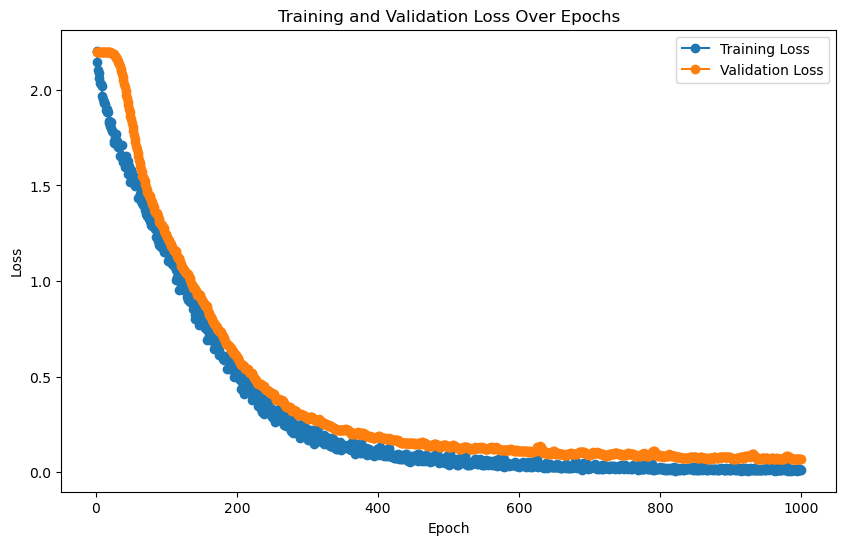

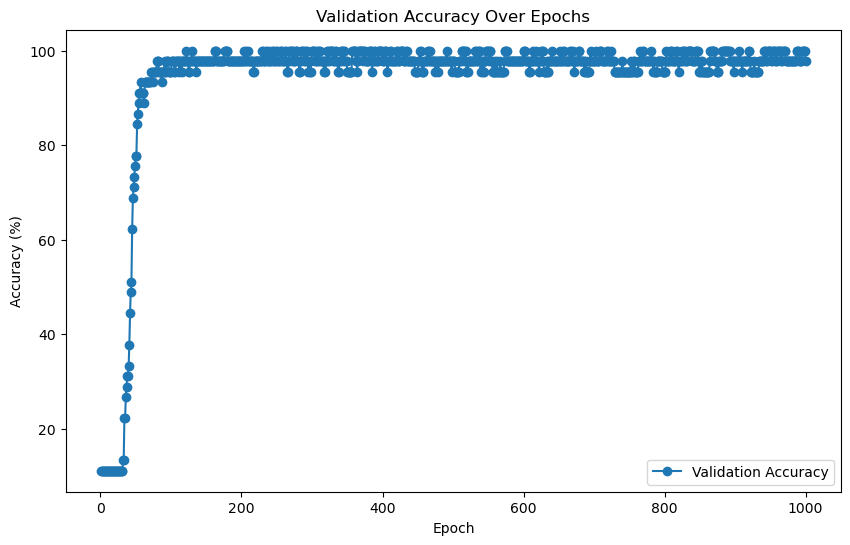


Evaluating on the test set...
    Test Batch [1/579], Loss: 0.1511



Final Test Loss: 0.1967, Test Accuracy: 95.07%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/579 for test dataset.
  Processed batch 20/579 for test dataset.
  Processed batch 30/579 for test dataset.


  Processed batch 40/579 for test dataset.


  Processed batch 50/579 for test dataset.
  Processed batch 60/579 for test dataset.
  Processed batch 70/579 for test dataset.
  Processed batch 80/579 for test dataset.


  Processed batch 90/579 for test dataset.
  Processed batch 100/579 for test dataset.
  Processed batch 110/579 for test dataset.
  Processed batch 120/579 for test dataset.
  Processed batch 130/579 for test dataset.


  Processed batch 140/579 for test dataset.
  Processed batch 150/579 for test dataset.
  Processed batch 160/579 for test dataset.
  Processed batch 170/579 for test dataset.
  Processed batch 180/579 for test dataset.


  Processed batch 190/579 for test dataset.
  Processed batch 200/579 for test dataset.
  Processed batch 210/579 for test dataset.
  Processed batch 220/579 for test dataset.
  Processed batch 230/579 for test dataset.


  Processed batch 240/579 for test dataset.
  Processed batch 250/579 for test dataset.
  Processed batch 260/579 for test dataset.
  Processed batch 270/579 for test dataset.
  Processed batch 280/579 for test dataset.


  Processed batch 290/579 for test dataset.
  Processed batch 300/579 for test dataset.
  Processed batch 310/579 for test dataset.
  Processed batch 320/579 for test dataset.
  Processed batch 330/579 for test dataset.


  Processed batch 340/579 for test dataset.
  Processed batch 350/579 for test dataset.
  Processed batch 360/579 for test dataset.
  Processed batch 370/579 for test dataset.
  Processed batch 380/579 for test dataset.


  Processed batch 390/579 for test dataset.
  Processed batch 400/579 for test dataset.
  Processed batch 410/579 for test dataset.
  Processed batch 420/579 for test dataset.
  Processed batch 430/579 for test dataset.


  Processed batch 440/579 for test dataset.
  Processed batch 450/579 for test dataset.
  Processed batch 460/579 for test dataset.
  Processed batch 470/579 for test dataset.
  Processed batch 480/579 for test dataset.


  Processed batch 490/579 for test dataset.
  Processed batch 500/579 for test dataset.
  Processed batch 510/579 for test dataset.
  Processed batch 520/579 for test dataset.
  Processed batch 530/579 for test dataset.


  Processed batch 540/579 for test dataset.
  Processed batch 550/579 for test dataset.
  Processed batch 560/579 for test dataset.
  Processed batch 570/579 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148062 samples with 64 features each
LOG: Labels shape: (148062,)

LOG: Training features shape: (45, 64), Training labels shape: (45,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (148062, 64), Test labels shape: (148062,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 86.67%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.67      0.80      0.73         5
           2       0.75      0.60      0.67         5
           3       1.00      0.60      0.75         5
           4       0.83      1.00      0.91         5
           5       1.00      0.80      0.89         5
           6       0.71      1.00      0.83         5
           7       1.00      1.00      1.00         5
           8       1.00      

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 148062 samples with 64 features each
LOG: Labels shape: (148062,)
Train reps shape: (45, 64)
Train labels shape: (45,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (148062, 64)
Test labels shape: (148062,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5500  |  Val Loss: 2.4195
Validation loss improved from inf to 2.4195.
[Epoch 2/1000] Train Loss: 2.4147  |  Val Loss: 2.3120
Validation loss improved from 2.4195 to 2.3120.
[Epoch 3/1000] Train Loss: 2.3008  |  Val Loss: 2.2224
Validation loss improved from 2.3120 to 2.2224.
[Epoch 4/1000] Train Loss: 2.2007  |  Val Loss: 2.1454
Validation loss improved from 2.2224 to 2.1454.
[Epoch 5/1000] Train Loss: 2.1172  |  Val Loss: 2.0823
Validation loss improved from 2.1454 to 2.0823.
[Epoch 6/1000] Train Loss: 2.0482  |  Val Loss: 2.0267
Validation loss improved from 2.0823 to 2.0267.
[Epoch 7/1000] Train Loss: 1.9844  |  Val Loss: 1.9755
Validation loss improved from 2.0267 to 1.9755.
[Epoch 8/1000] Train Loss: 1.9243  |  Val Loss: 1.9254
Validation loss improved from 1.9755 to 1.9254.
[Epoch 9/1000] Train Loss: 1.8673  |  Val Loss: 1.8799
Validation loss improved from 1.9254 to 1.8799.
[Epoch 10/1000] Train Loss: 1.8161  |  Val Loss: 1.8383
Validation loss impr

[Epoch 18/1000] Train Loss: 1.4547  |  Val Loss: 1.5235
Validation loss improved from 1.5634 to 1.5235.
[Epoch 19/1000] Train Loss: 1.4102  |  Val Loss: 1.4820
Validation loss improved from 1.5235 to 1.4820.
[Epoch 20/1000] Train Loss: 1.3649  |  Val Loss: 1.4401
Validation loss improved from 1.4820 to 1.4401.
[Epoch 21/1000] Train Loss: 1.3193  |  Val Loss: 1.3978
Validation loss improved from 1.4401 to 1.3978.
[Epoch 22/1000] Train Loss: 1.2718  |  Val Loss: 1.3557
Validation loss improved from 1.3978 to 1.3557.
[Epoch 23/1000] Train Loss: 1.2232  |  Val Loss: 1.3140
Validation loss improved from 1.3557 to 1.3140.
[Epoch 24/1000] Train Loss: 1.1751  |  Val Loss: 1.2728
Validation loss improved from 1.3140 to 1.2728.
[Epoch 25/1000] Train Loss: 1.1292  |  Val Loss: 1.2323
Validation loss improved from 1.2728 to 1.2323.
[Epoch 26/1000] Train Loss: 1.0839  |  Val Loss: 1.1934
Validation loss improved from 1.2323 to 1.1934.
[Epoch 27/1000] Train Loss: 1.0397  |  Val Loss: 1.1557
Validati

[Epoch 72/1000] Train Loss: 0.1632  |  Val Loss: 0.4424
Validation loss improved from 0.4437 to 0.4424.
[Epoch 73/1000] Train Loss: 0.1573  |  Val Loss: 0.4414
Validation loss improved from 0.4424 to 0.4414.
[Epoch 74/1000] Train Loss: 0.1517  |  Val Loss: 0.4409
Validation loss improved from 0.4414 to 0.4409.
[Epoch 75/1000] Train Loss: 0.1463  |  Val Loss: 0.4407
Validation loss improved from 0.4409 to 0.4407.
[Epoch 76/1000] Train Loss: 0.1411  |  Val Loss: 0.4410
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 77/1000] Train Loss: 0.1361  |  Val Loss: 0.4417
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 78/1000] Train Loss: 0.1312  |  Val Loss: 0.4426
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 79/1000] Train Loss: 0.1266  |  Val Loss: 0.4435
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 80/1000] Train Loss: 0.1224  |  Val Loss: 0.4441
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 81/1000] Train Loss: 0.1183

[Epoch 94/1000] Train Loss: 0.0773  |  Val Loss: 0.4601
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 95/1000] Train Loss: 0.0749  |  Val Loss: 0.4612
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 96/1000] Train Loss: 0.0726  |  Val Loss: 0.4625
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 97/1000] Train Loss: 0.0704  |  Val Loss: 0.4640
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 98/1000] Train Loss: 0.0682  |  Val Loss: 0.4656
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 99/1000] Train Loss: 0.0662  |  Val Loss: 0.4672
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 100/1000] Train Loss: 0.0642  |  Val Loss: 0.4684
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 101/1000] Train Loss: 0.0623  |  Val Loss: 0.4693
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 102/1000] Train Loss: 0.0604  |  Val Loss: 0.4703
!! Validation loss did NOT improve !! Patience: 27/10

[Epoch 147/1000] Train Loss: 0.0199  |  Val Loss: 0.5523
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 148/1000] Train Loss: 0.0195  |  Val Loss: 0.5540
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 149/1000] Train Loss: 0.0192  |  Val Loss: 0.5559
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 150/1000] Train Loss: 0.0188  |  Val Loss: 0.5578
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 151/1000] Train Loss: 0.0184  |  Val Loss: 0.5598
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 152/1000] Train Loss: 0.0181  |  Val Loss: 0.5618
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 153/1000] Train Loss: 0.0178  |  Val Loss: 0.5638
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 154/1000] Train Loss: 0.0174  |  Val Loss: 0.5655
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 155/1000] Train Loss: 0.0171  |  Val Loss: 0.5671
!! Validation loss did NOT improve !! Patience:

[Epoch 169/1000] Train Loss: 0.0134  |  Val Loss: 0.5887
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 170/1000] Train Loss: 0.0132  |  Val Loss: 0.5902
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 171/1000] Train Loss: 0.0130  |  Val Loss: 0.5915
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 172/1000] Train Loss: 0.0128  |  Val Loss: 0.5927
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 173/1000] Train Loss: 0.0126  |  Val Loss: 0.5940
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 174/1000] Train Loss: 0.0124  |  Val Loss: 0.5955
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 175/1000] Train Loss: 0.0122  |  Val Loss: 0.5969
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 175 !!
No improvement for 100 epochs.


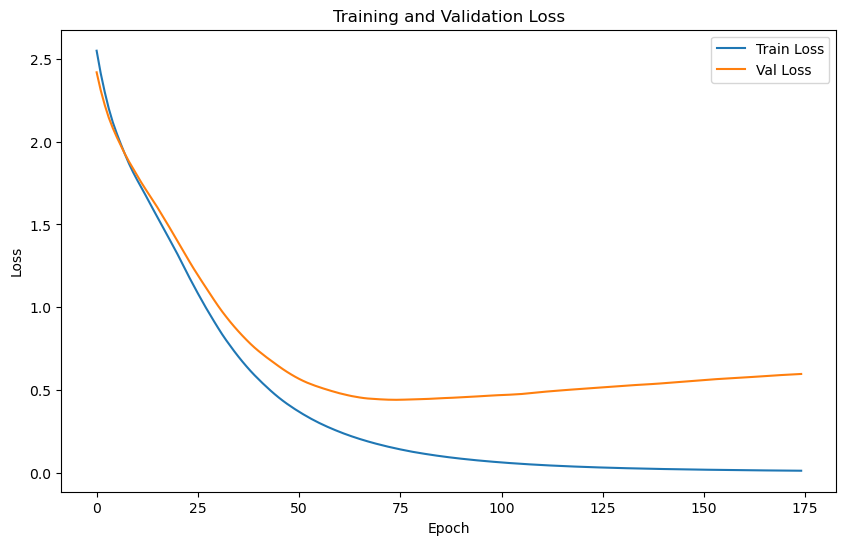

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.3564 | Test Accuracy: 90.18%


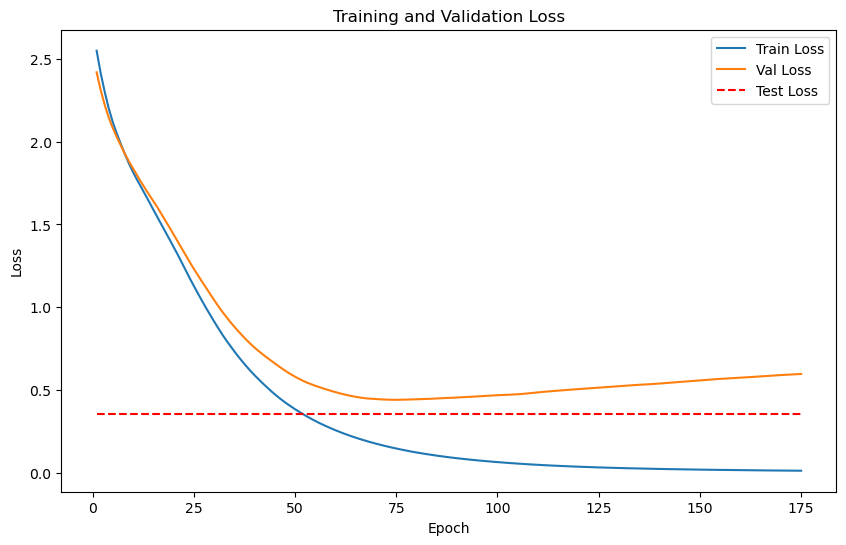

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148062 samples with 64 features each
LOG: Labels shape: (148062,)


Train embeddings shape: (45, 64), 
Train labels shape: (45,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (148062, 64), 
Test labels shape: (148062,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Training batch size: 45


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.7271
Epoch [1/2000], Avg Train Loss: 8.7271
Epoch [1/2000], Avg Val Loss: 3.5584
Validation loss improved from inf to 3.5584. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.4529
Epoch [2/2000], Avg Train Loss: 8.4529
Epoch [2/2000], Avg Val Loss: 3.5226
Validation loss improved from 3.5584 to 3.5226. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.4762
Epoch [3/2000], Avg Train Loss: 8.4762
Epoch [3/2000], Avg Val Loss: 3.4892
Validation loss improved from 3.5226 to 3.4892. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.4101
Epoch [4/2000], Avg Train Loss: 8.4101
Epoch [4/2000], Avg Val Loss: 3.4568
Validation loss improved from 3.4892 to 3.4568. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.7279
Epoch [5/2000], Avg Train Loss: 8.7279
Epoch [5/2000], Avg Val Loss: 3.4255
Validation loss improved from 3.4568 to 3.4255. Saving mode

    Batch [1/1], Train Loss: 8.1720
Epoch [11/2000], Avg Train Loss: 8.1720
Epoch [11/2000], Avg Val Loss: 3.2555
Validation loss improved from 3.2818 to 3.2555. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 7.4812
Epoch [12/2000], Avg Train Loss: 7.4812
Epoch [12/2000], Avg Val Loss: 3.2299
Validation loss improved from 3.2555 to 3.2299. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 7.8620
Epoch [13/2000], Avg Train Loss: 7.8620
Epoch [13/2000], Avg Val Loss: 3.2053
Validation loss improved from 3.2299 to 3.2053. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 7.6742
Epoch [14/2000], Avg Train Loss: 7.6742
Epoch [14/2000], Avg Val Loss: 3.1813
Validation loss improved from 3.2053 to 3.1813. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 7.5065
Epoch [15/2000], Avg Train Loss: 7.5065
Epoch [15/2000], Avg Val Loss: 3.1581
Validation loss improved from 3.1813 to 3.

    Batch [1/1], Train Loss: 5.6631
Epoch [51/2000], Avg Train Loss: 5.6631
Epoch [51/2000], Avg Val Loss: 2.6911
Validation loss improved from 2.6974 to 2.6911. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 5.4806
Epoch [52/2000], Avg Train Loss: 5.4806
Epoch [52/2000], Avg Val Loss: 2.6849
Validation loss improved from 2.6911 to 2.6849. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 5.5464
Epoch [53/2000], Avg Train Loss: 5.5464
Epoch [53/2000], Avg Val Loss: 2.6789
Validation loss improved from 2.6849 to 2.6789. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 5.4986
Epoch [54/2000], Avg Train Loss: 5.4986
Epoch [54/2000], Avg Val Loss: 2.6731
Validation loss improved from 2.6789 to 2.6731. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 5.7599
Epoch [55/2000], Avg Train Loss: 5.7599
Epoch [55/2000], Avg Val Loss: 2.6676
Validation loss improved from 2.6731 to 2.

    Batch [1/1], Train Loss: 5.4477
Epoch [58/2000], Avg Train Loss: 5.4477
Epoch [58/2000], Avg Val Loss: 2.6524
Validation loss improved from 2.6573 to 2.6524. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 5.0578
Epoch [59/2000], Avg Train Loss: 5.0578
Epoch [59/2000], Avg Val Loss: 2.6477
Validation loss improved from 2.6524 to 2.6477. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 5.3179
Epoch [60/2000], Avg Train Loss: 5.3179
Epoch [60/2000], Avg Val Loss: 2.6433
Validation loss improved from 2.6477 to 2.6433. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 5.5082
Epoch [61/2000], Avg Train Loss: 5.5082
Epoch [61/2000], Avg Val Loss: 2.6390
Validation loss improved from 2.6433 to 2.6390. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 5.4512
Epoch [62/2000], Avg Train Loss: 5.4512
Epoch [62/2000], Avg Val Loss: 2.6348
Validation loss improved from 2.6390 to 2.

    Batch [1/1], Train Loss: 4.1895
Epoch [99/2000], Avg Train Loss: 4.1895
Epoch [99/2000], Avg Val Loss: 2.5666
Validation loss improved from 2.5671 to 2.5666. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 4.1528
Epoch [100/2000], Avg Train Loss: 4.1528
Epoch [100/2000], Avg Val Loss: 2.5660
Validation loss improved from 2.5666 to 2.5660. Saving model...

LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 4.2903
Epoch [101/2000], Avg Train Loss: 4.2903
Epoch [101/2000], Avg Val Loss: 2.5655
Validation loss improved from 2.5660 to 2.5655. Saving model...

LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 4.2554
Epoch [102/2000], Avg Train Loss: 4.2554
Epoch [102/2000], Avg Val Loss: 2.5650
Validation loss improved from 2.5655 to 2.5650. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 4.0913
Epoch [103/2000], Avg Train Loss: 4.0913
Epoch [103/2000], Avg Val Loss: 2.5645
Validation loss improved from 

    Batch [1/1], Train Loss: 4.0531
Epoch [106/2000], Avg Train Loss: 4.0531
Epoch [106/2000], Avg Val Loss: 2.5632
Validation loss improved from 2.5636 to 2.5632. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 4.0441
Epoch [107/2000], Avg Train Loss: 4.0441
Epoch [107/2000], Avg Val Loss: 2.5629
Validation loss improved from 2.5632 to 2.5629. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 3.9216
Epoch [108/2000], Avg Train Loss: 3.9216
Epoch [108/2000], Avg Val Loss: 2.5626
Validation loss improved from 2.5629 to 2.5626. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 4.0343
Epoch [109/2000], Avg Train Loss: 4.0343
Epoch [109/2000], Avg Val Loss: 2.5623
Validation loss improved from 2.5626 to 2.5623. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 3.9333
Epoch [110/2000], Avg Train Loss: 3.9333
Epoch [110/2000], Avg Val Loss: 2.5620
Validation loss improved fro

Epoch [148/2000], Avg Val Loss: 2.5575
Validation loss improved from 2.5576 to 2.5575. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 3.5825
Epoch [149/2000], Avg Train Loss: 3.5825
Epoch [149/2000], Avg Val Loss: 2.5575
Validation loss improved from 2.5575 to 2.5575. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 3.6780
Epoch [150/2000], Avg Train Loss: 3.6780
Epoch [150/2000], Avg Val Loss: 2.5574
Validation loss improved from 2.5575 to 2.5574. Saving model...

LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 3.5483
Epoch [151/2000], Avg Train Loss: 3.5483
Epoch [151/2000], Avg Val Loss: 2.5573
Validation loss improved from 2.5574 to 2.5573. Saving model...

LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 3.6197
Epoch [152/2000], Avg Train Loss: 3.6197
Epoch [152/2000], Avg Val Loss: 2.5573
Validation loss improved from 2.5573 to 2.5573. Saving model...

LOG: Epoch [153/2000] - Training
    Bat

Epoch [199/2000], Avg Val Loss: 2.5521
Validation loss improved from 2.5524 to 2.5521. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 3.4844
Epoch [200/2000], Avg Train Loss: 3.4844
Epoch [200/2000], Avg Val Loss: 2.5519
Validation loss improved from 2.5521 to 2.5519. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 3.2832
Epoch [201/2000], Avg Train Loss: 3.2832
Epoch [201/2000], Avg Val Loss: 2.5516
Validation loss improved from 2.5519 to 2.5516. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 3.4186
Epoch [202/2000], Avg Train Loss: 3.4186
Epoch [202/2000], Avg Val Loss: 2.5513
Validation loss improved from 2.5516 to 2.5513. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 3.3399
Epoch [203/2000], Avg Train Loss: 3.3399
Epoch [203/2000], Avg Val Loss: 2.5510
Validation loss improved from 2.5513 to 2.5510. Saving model...

LOG: Epoch [204/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.2382
Epoch [253/2000], Avg Train Loss: 3.2382
Epoch [253/2000], Avg Val Loss: 2.5325
Validation loss improved from 2.5329 to 2.5325. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 3.0885
Epoch [254/2000], Avg Train Loss: 3.0885
Epoch [254/2000], Avg Val Loss: 2.5320
Validation loss improved from 2.5325 to 2.5320. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 3.2050
Epoch [255/2000], Avg Train Loss: 3.2050
Epoch [255/2000], Avg Val Loss: 2.5315
Validation loss improved from 2.5320 to 2.5315. Saving model...

LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 3.1932
Epoch [256/2000], Avg Train Loss: 3.1932
Epoch [256/2000], Avg Val Loss: 2.5311
Validation loss improved from 2.5315 to 2.5311. Saving model...

LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 3.0719
Epoch [257/2000], Avg Train Loss: 3.0719
Epoch [257/2000], Avg Val Loss: 2.5306
Validation loss improved fro

Epoch [304/2000], Avg Val Loss: 2.5059
Validation loss improved from 2.5065 to 2.5059. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 3.0311
Epoch [305/2000], Avg Train Loss: 3.0311
Epoch [305/2000], Avg Val Loss: 2.5053
Validation loss improved from 2.5059 to 2.5053. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 3.0801
Epoch [306/2000], Avg Train Loss: 3.0801
Epoch [306/2000], Avg Val Loss: 2.5047
Validation loss improved from 2.5053 to 2.5047. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 3.0640
Epoch [307/2000], Avg Train Loss: 3.0640
Epoch [307/2000], Avg Val Loss: 2.5041
Validation loss improved from 2.5047 to 2.5041. Saving model...

LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 3.0472
Epoch [308/2000], Avg Train Loss: 3.0472
Epoch [308/2000], Avg Val Loss: 2.5035
Validation loss improved from 2.5041 to 2.5035. Saving model...

LOG: Epoch [309/2000] - Training
    Bat

Epoch [356/2000], Avg Val Loss: 2.4753
Validation loss improved from 2.4759 to 2.4753. Saving model...

LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 2.9367
Epoch [357/2000], Avg Train Loss: 2.9367
Epoch [357/2000], Avg Val Loss: 2.4747
Validation loss improved from 2.4753 to 2.4747. Saving model...

LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 2.8340
Epoch [358/2000], Avg Train Loss: 2.8340
Epoch [358/2000], Avg Val Loss: 2.4741
Validation loss improved from 2.4747 to 2.4741. Saving model...

LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 2.9544
Epoch [359/2000], Avg Train Loss: 2.9544
Epoch [359/2000], Avg Val Loss: 2.4735
Validation loss improved from 2.4741 to 2.4735. Saving model...

LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 2.8554
Epoch [360/2000], Avg Train Loss: 2.8554
Epoch [360/2000], Avg Val Loss: 2.4729
Validation loss improved from 2.4735 to 2.4729. Saving model...

LOG: Epoch [361/2000] - Training
    Bat

Epoch [402/2000], Avg Val Loss: 2.4473
Validation loss improved from 2.4479 to 2.4473. Saving model...

LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 2.7861
Epoch [403/2000], Avg Train Loss: 2.7861
Epoch [403/2000], Avg Val Loss: 2.4466
Validation loss improved from 2.4473 to 2.4466. Saving model...

LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 2.9344
Epoch [404/2000], Avg Train Loss: 2.9344
Epoch [404/2000], Avg Val Loss: 2.4459
Validation loss improved from 2.4466 to 2.4459. Saving model...

LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 2.8980
Epoch [405/2000], Avg Train Loss: 2.8980
Epoch [405/2000], Avg Val Loss: 2.4453
Validation loss improved from 2.4459 to 2.4453. Saving model...

LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 2.8728
Epoch [406/2000], Avg Train Loss: 2.8728
Epoch [406/2000], Avg Val Loss: 2.4447
Validation loss improved from 2.4453 to 2.4447. Saving model...

LOG: Epoch [407/2000] - Training
    Bat

Epoch [455/2000], Avg Val Loss: 2.4166
Validation loss improved from 2.4172 to 2.4166. Saving model...

LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 2.6754
Epoch [456/2000], Avg Train Loss: 2.6754
Epoch [456/2000], Avg Val Loss: 2.4161
Validation loss improved from 2.4166 to 2.4161. Saving model...

LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 2.7033
Epoch [457/2000], Avg Train Loss: 2.7033
Epoch [457/2000], Avg Val Loss: 2.4155
Validation loss improved from 2.4161 to 2.4155. Saving model...

LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 2.7653
Epoch [458/2000], Avg Train Loss: 2.7653
Epoch [458/2000], Avg Val Loss: 2.4149
Validation loss improved from 2.4155 to 2.4149. Saving model...

LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 2.7665
Epoch [459/2000], Avg Train Loss: 2.7665
Epoch [459/2000], Avg Val Loss: 2.4144
Validation loss improved from 2.4149 to 2.4144. Saving model...

LOG: Epoch [460/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.7138
Epoch [504/2000], Avg Train Loss: 2.7138
Epoch [504/2000], Avg Val Loss: 2.3893
Validation loss improved from 2.3898 to 2.3893. Saving model...

LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 2.7402
Epoch [505/2000], Avg Train Loss: 2.7402
Epoch [505/2000], Avg Val Loss: 2.3888
Validation loss improved from 2.3893 to 2.3888. Saving model...

LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 2.6600
Epoch [506/2000], Avg Train Loss: 2.6600
Epoch [506/2000], Avg Val Loss: 2.3883
Validation loss improved from 2.3888 to 2.3883. Saving model...

LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 2.8056
Epoch [507/2000], Avg Train Loss: 2.8056
Epoch [507/2000], Avg Val Loss: 2.3878
Validation loss improved from 2.3883 to 2.3878. Saving model...

LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 2.8074
Epoch [508/2000], Avg Train Loss: 2.8074
Epoch [508/2000], Avg Val Loss: 2.3872
Validation loss improved fro

Epoch [547/2000], Avg Val Loss: 2.3678
Validation loss improved from 2.3683 to 2.3678. Saving model...

LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 2.6276
Epoch [548/2000], Avg Train Loss: 2.6276
Epoch [548/2000], Avg Val Loss: 2.3674
Validation loss improved from 2.3678 to 2.3674. Saving model...

LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 2.6445
Epoch [549/2000], Avg Train Loss: 2.6445
Epoch [549/2000], Avg Val Loss: 2.3669
Validation loss improved from 2.3674 to 2.3669. Saving model...

LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 2.6661
Epoch [550/2000], Avg Train Loss: 2.6661
Epoch [550/2000], Avg Val Loss: 2.3665
Validation loss improved from 2.3669 to 2.3665. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 2.6660
Epoch [551/2000], Avg Train Loss: 2.6660
Epoch [551/2000], Avg Val Loss: 2.3660
Validation loss improved from 2.3665 to 2.3660. Saving model...

LOG: Epoch [552/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.6233
Epoch [594/2000], Avg Train Loss: 2.6233
Epoch [594/2000], Avg Val Loss: 2.3456
Validation loss improved from 2.3460 to 2.3456. Saving model...

LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 2.6369
Epoch [595/2000], Avg Train Loss: 2.6369
Epoch [595/2000], Avg Val Loss: 2.3452
Validation loss improved from 2.3456 to 2.3452. Saving model...

LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 2.6223
Epoch [596/2000], Avg Train Loss: 2.6223
Epoch [596/2000], Avg Val Loss: 2.3448
Validation loss improved from 2.3452 to 2.3448. Saving model...

LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 2.5667
Epoch [597/2000], Avg Train Loss: 2.5667
Epoch [597/2000], Avg Val Loss: 2.3444
Validation loss improved from 2.3448 to 2.3444. Saving model...

LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 2.6008
Epoch [598/2000], Avg Train Loss: 2.6008
Epoch [598/2000], Avg Val Loss: 2.3439
Validation loss improved fro

    Batch [1/1], Train Loss: 2.5502
Epoch [641/2000], Avg Train Loss: 2.5502
Epoch [641/2000], Avg Val Loss: 2.3256
Validation loss improved from 2.3260 to 2.3256. Saving model...

LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 2.5157
Epoch [642/2000], Avg Train Loss: 2.5157
Epoch [642/2000], Avg Val Loss: 2.3252
Validation loss improved from 2.3256 to 2.3252. Saving model...

LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 2.6524
Epoch [643/2000], Avg Train Loss: 2.6524
Epoch [643/2000], Avg Val Loss: 2.3248
Validation loss improved from 2.3252 to 2.3248. Saving model...

LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 2.5683
Epoch [644/2000], Avg Train Loss: 2.5683
Epoch [644/2000], Avg Val Loss: 2.3244
Validation loss improved from 2.3248 to 2.3244. Saving model...

LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 2.6230
Epoch [645/2000], Avg Train Loss: 2.6230
Epoch [645/2000], Avg Val Loss: 2.3240
Validation loss improved fro

    Batch [1/1], Train Loss: 2.5791
Epoch [690/2000], Avg Train Loss: 2.5791
Epoch [690/2000], Avg Val Loss: 2.3080
Validation loss improved from 2.3083 to 2.3080. Saving model...

LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 2.5720
Epoch [691/2000], Avg Train Loss: 2.5720
Epoch [691/2000], Avg Val Loss: 2.3077
Validation loss improved from 2.3080 to 2.3077. Saving model...

LOG: Epoch [692/2000] - Training
    Batch [1/1], Train Loss: 2.4948
Epoch [692/2000], Avg Train Loss: 2.4948
Epoch [692/2000], Avg Val Loss: 2.3074
Validation loss improved from 2.3077 to 2.3074. Saving model...

LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 2.5468
Epoch [693/2000], Avg Train Loss: 2.5468
Epoch [693/2000], Avg Val Loss: 2.3070
Validation loss improved from 2.3074 to 2.3070. Saving model...

LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 2.5805
Epoch [694/2000], Avg Train Loss: 2.5805
Epoch [694/2000], Avg Val Loss: 2.3067
Validation loss improved fro

Epoch [739/2000], Avg Val Loss: 2.2932
Validation loss improved from 2.2935 to 2.2932. Saving model...

LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 2.4705
Epoch [740/2000], Avg Train Loss: 2.4705
Epoch [740/2000], Avg Val Loss: 2.2929
Validation loss improved from 2.2932 to 2.2929. Saving model...

LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 2.5180
Epoch [741/2000], Avg Train Loss: 2.5180
Epoch [741/2000], Avg Val Loss: 2.2926
Validation loss improved from 2.2929 to 2.2926. Saving model...

LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 2.4706
Epoch [742/2000], Avg Train Loss: 2.4706
Epoch [742/2000], Avg Val Loss: 2.2923
Validation loss improved from 2.2926 to 2.2923. Saving model...

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 2.5531
Epoch [743/2000], Avg Train Loss: 2.5531
Epoch [743/2000], Avg Val Loss: 2.2920
Validation loss improved from 2.2923 to 2.2920. Saving model...

LOG: Epoch [744/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.4244
Epoch [789/2000], Avg Train Loss: 2.4244
Epoch [789/2000], Avg Val Loss: 2.2787
Validation loss improved from 2.2790 to 2.2787. Saving model...

LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 2.4660
Epoch [790/2000], Avg Train Loss: 2.4660
Epoch [790/2000], Avg Val Loss: 2.2785
Validation loss improved from 2.2787 to 2.2785. Saving model...

LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 2.4924
Epoch [791/2000], Avg Train Loss: 2.4924
Epoch [791/2000], Avg Val Loss: 2.2782
Validation loss improved from 2.2785 to 2.2782. Saving model...

LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 2.4929
Epoch [792/2000], Avg Train Loss: 2.4929
Epoch [792/2000], Avg Val Loss: 2.2779
Validation loss improved from 2.2782 to 2.2779. Saving model...

LOG: Epoch [793/2000] - Training
    Batch [1/1], Train Loss: 2.4938
Epoch [793/2000], Avg Train Loss: 2.4938
Epoch [793/2000], Avg Val Loss: 2.2777
Validation loss improved fro

    Batch [1/1], Train Loss: 2.3845
Epoch [838/2000], Avg Train Loss: 2.3845
Epoch [838/2000], Avg Val Loss: 2.2674
Validation loss improved from 2.2675 to 2.2674. Saving model...

LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 2.3804
Epoch [839/2000], Avg Train Loss: 2.3804
Epoch [839/2000], Avg Val Loss: 2.2672
Validation loss improved from 2.2674 to 2.2672. Saving model...

LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 2.3864
Epoch [840/2000], Avg Train Loss: 2.3864
Epoch [840/2000], Avg Val Loss: 2.2670
Validation loss improved from 2.2672 to 2.2670. Saving model...

LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 2.4277
Epoch [841/2000], Avg Train Loss: 2.4277
Epoch [841/2000], Avg Val Loss: 2.2669
Validation loss improved from 2.2670 to 2.2669. Saving model...

LOG: Epoch [842/2000] - Training
    Batch [1/1], Train Loss: 2.4264
Epoch [842/2000], Avg Train Loss: 2.4264
Epoch [842/2000], Avg Val Loss: 2.2667
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4431
Epoch [883/2000], Avg Train Loss: 2.4431
Epoch [883/2000], Avg Val Loss: 2.2588
Validation loss improved from 2.2590 to 2.2588. Saving model...

LOG: Epoch [884/2000] - Training
    Batch [1/1], Train Loss: 2.4979
Epoch [884/2000], Avg Train Loss: 2.4979
Epoch [884/2000], Avg Val Loss: 2.2586
Validation loss improved from 2.2588 to 2.2586. Saving model...

LOG: Epoch [885/2000] - Training
    Batch [1/1], Train Loss: 2.4255
Epoch [885/2000], Avg Train Loss: 2.4255
Epoch [885/2000], Avg Val Loss: 2.2584
Validation loss improved from 2.2586 to 2.2584. Saving model...

LOG: Epoch [886/2000] - Training
    Batch [1/1], Train Loss: 2.4283
Epoch [886/2000], Avg Train Loss: 2.4283
Epoch [886/2000], Avg Val Loss: 2.2583
Validation loss improved from 2.2584 to 2.2583. Saving model...

LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 2.4465
Epoch [887/2000], Avg Train Loss: 2.4465
Epoch [887/2000], Avg Val Loss: 2.2581
Validation loss improved fro

Epoch [930/2000], Avg Val Loss: 2.2516
Validation loss improved from 2.2518 to 2.2516. Saving model...

LOG: Epoch [931/2000] - Training
    Batch [1/1], Train Loss: 2.2956
Epoch [931/2000], Avg Train Loss: 2.2956
Epoch [931/2000], Avg Val Loss: 2.2515
Validation loss improved from 2.2516 to 2.2515. Saving model...

LOG: Epoch [932/2000] - Training
    Batch [1/1], Train Loss: 2.3895
Epoch [932/2000], Avg Train Loss: 2.3895
Epoch [932/2000], Avg Val Loss: 2.2513
Validation loss improved from 2.2515 to 2.2513. Saving model...

LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 2.3514
Epoch [933/2000], Avg Train Loss: 2.3514
Epoch [933/2000], Avg Val Loss: 2.2511
Validation loss improved from 2.2513 to 2.2511. Saving model...

LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 2.3601
Epoch [934/2000], Avg Train Loss: 2.3601
Epoch [934/2000], Avg Val Loss: 2.2510
Validation loss improved from 2.2511 to 2.2510. Saving model...

LOG: Epoch [935/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.3581
Epoch [979/2000], Avg Train Loss: 2.3581
Epoch [979/2000], Avg Val Loss: 2.2459
Validation loss improved from 2.2460 to 2.2459. Saving model...

LOG: Epoch [980/2000] - Training
    Batch [1/1], Train Loss: 2.3622
Epoch [980/2000], Avg Train Loss: 2.3622
Epoch [980/2000], Avg Val Loss: 2.2458
Validation loss improved from 2.2459 to 2.2458. Saving model...

LOG: Epoch [981/2000] - Training
    Batch [1/1], Train Loss: 2.3391
Epoch [981/2000], Avg Train Loss: 2.3391
Epoch [981/2000], Avg Val Loss: 2.2456
Validation loss improved from 2.2458 to 2.2456. Saving model...

LOG: Epoch [982/2000] - Training
    Batch [1/1], Train Loss: 2.3585
Epoch [982/2000], Avg Train Loss: 2.3585
Epoch [982/2000], Avg Val Loss: 2.2455
Validation loss improved from 2.2456 to 2.2455. Saving model...

LOG: Epoch [983/2000] - Training
    Batch [1/1], Train Loss: 2.2989
Epoch [983/2000], Avg Train Loss: 2.2989
Epoch [983/2000], Avg Val Loss: 2.2454
Validation loss improved fro

Epoch [1031/2000], Avg Val Loss: 2.2405
Validation loss improved from 2.2406 to 2.2405. Saving model...

LOG: Epoch [1032/2000] - Training
    Batch [1/1], Train Loss: 2.2980
Epoch [1032/2000], Avg Train Loss: 2.2980
Epoch [1032/2000], Avg Val Loss: 2.2405
Validation loss improved from 2.2405 to 2.2405. Saving model...

LOG: Epoch [1033/2000] - Training
    Batch [1/1], Train Loss: 2.2797
Epoch [1033/2000], Avg Train Loss: 2.2797
Epoch [1033/2000], Avg Val Loss: 2.2405
Validation loss improved from 2.2405 to 2.2405. Saving model...

LOG: Epoch [1034/2000] - Training
    Batch [1/1], Train Loss: 2.2698
Epoch [1034/2000], Avg Train Loss: 2.2698
Epoch [1034/2000], Avg Val Loss: 2.2404
Validation loss improved from 2.2405 to 2.2404. Saving model...

LOG: Epoch [1035/2000] - Training
    Batch [1/1], Train Loss: 2.2939
Epoch [1035/2000], Avg Train Loss: 2.2939
Epoch [1035/2000], Avg Val Loss: 2.2404
Validation loss improved from 2.2404 to 2.2404. Saving model...

LOG: Epoch [1036/2000] - Tr

    Batch [1/1], Train Loss: 2.2844
Epoch [1079/2000], Avg Train Loss: 2.2844
Epoch [1079/2000], Avg Val Loss: 2.2378
Validation loss improved from 2.2379 to 2.2378. Saving model...

LOG: Epoch [1080/2000] - Training
    Batch [1/1], Train Loss: 2.2645
Epoch [1080/2000], Avg Train Loss: 2.2645
Epoch [1080/2000], Avg Val Loss: 2.2378
Validation loss improved from 2.2378 to 2.2378. Saving model...

LOG: Epoch [1081/2000] - Training
    Batch [1/1], Train Loss: 2.2795
Epoch [1081/2000], Avg Train Loss: 2.2795
Epoch [1081/2000], Avg Val Loss: 2.2377
Validation loss improved from 2.2378 to 2.2377. Saving model...

LOG: Epoch [1082/2000] - Training
    Batch [1/1], Train Loss: 2.3140
Epoch [1082/2000], Avg Train Loss: 2.3140
Epoch [1082/2000], Avg Val Loss: 2.2377
Validation loss improved from 2.2377 to 2.2377. Saving model...

LOG: Epoch [1083/2000] - Training
    Batch [1/1], Train Loss: 2.1464
Epoch [1083/2000], Avg Train Loss: 2.1464
Epoch [1083/2000], Avg Val Loss: 2.2377
Validation los

    Batch [1/1], Train Loss: 2.2554
Epoch [1131/2000], Avg Train Loss: 2.2554
Epoch [1131/2000], Avg Val Loss: 2.2392
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1132/2000] - Training
    Batch [1/1], Train Loss: 2.2329
Epoch [1132/2000], Avg Train Loss: 2.2329
Epoch [1132/2000], Avg Val Loss: 2.2392
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1133/2000] - Training
    Batch [1/1], Train Loss: 2.2897
Epoch [1133/2000], Avg Train Loss: 2.2897
Epoch [1133/2000], Avg Val Loss: 2.2392
Validation loss did not improve. Patience: 49/100

LOG: Epoch [1134/2000] - Training
    Batch [1/1], Train Loss: 2.2258
Epoch [1134/2000], Avg Train Loss: 2.2258
Epoch [1134/2000], Avg Val Loss: 2.2392
Validation loss did not improve. Patience: 50/100

LOG: Epoch [1135/2000] - Training
    Batch [1/1], Train Loss: 2.2676
Epoch [1135/2000], Avg Train Loss: 2.2676
Epoch [1135/2000], Avg Val Loss: 2.2392
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1136/20

    Batch [1/1], Train Loss: 2.2210
Epoch [1178/2000], Avg Train Loss: 2.2210
Epoch [1178/2000], Avg Val Loss: 2.2382
Validation loss did not improve. Patience: 94/100

LOG: Epoch [1179/2000] - Training
    Batch [1/1], Train Loss: 2.2304
Epoch [1179/2000], Avg Train Loss: 2.2304
Epoch [1179/2000], Avg Val Loss: 2.2383
Validation loss did not improve. Patience: 95/100

LOG: Epoch [1180/2000] - Training
    Batch [1/1], Train Loss: 2.1681
Epoch [1180/2000], Avg Train Loss: 2.1681
Epoch [1180/2000], Avg Val Loss: 2.2384
Validation loss did not improve. Patience: 96/100

LOG: Epoch [1181/2000] - Training
    Batch [1/1], Train Loss: 2.3032
Epoch [1181/2000], Avg Train Loss: 2.3032
Epoch [1181/2000], Avg Val Loss: 2.2384
Validation loss did not improve. Patience: 97/100

LOG: Epoch [1182/2000] - Training
    Batch [1/1], Train Loss: 2.1732
Epoch [1182/2000], Avg Train Loss: 2.1732
Epoch [1182/2000], Avg Val Loss: 2.2384
Validation loss did not improve. Patience: 98/100

LOG: Epoch [1183/20

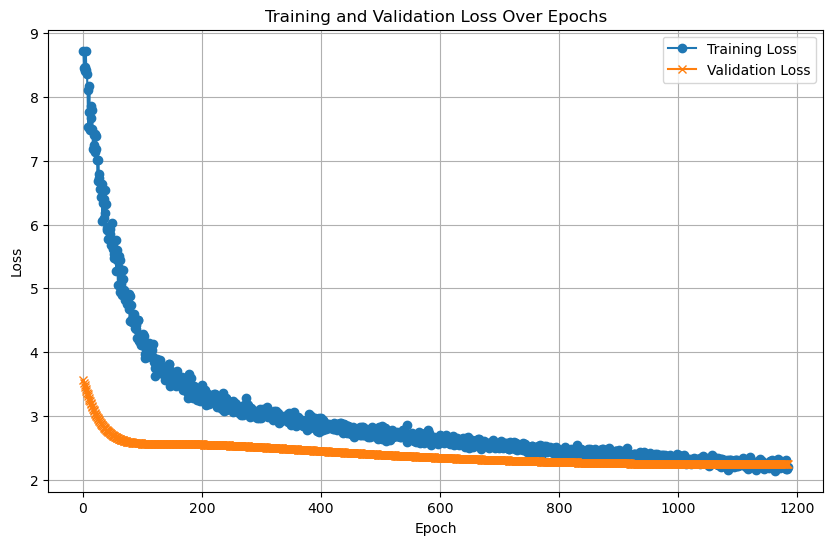

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/579], Loss: 4.8814
Test Batch [20/579], Loss: 4.7836
Test Batch [30/579], Loss: 4.8032
Test Batch [40/579], Loss: 4.6718
Test Batch [50/579], Loss: 4.7740
Test Batch [60/579], Loss: 4.6925


Test Batch [70/579], Loss: 4.7072
Test Batch [80/579], Loss: 4.4055
Test Batch [90/579], Loss: 4.5240
Test Batch [100/579], Loss: 4.6007
Test Batch [110/579], Loss: 4.5382
Test Batch [120/579], Loss: 4.6381
Test Batch [130/579], Loss: 4.7360
Test Batch [140/579], Loss: 4.6758
Test Batch [150/579], Loss: 4.7162


Test Batch [160/579], Loss: 4.8205
Test Batch [170/579], Loss: 4.8605
Test Batch [180/579], Loss: 4.6058
Test Batch [190/579], Loss: 4.8489
Test Batch [200/579], Loss: 4.8547
Test Batch [210/579], Loss: 4.7475


Test Batch [220/579], Loss: 4.7790
Test Batch [230/579], Loss: 4.7697
Test Batch [240/579], Loss: 4.9027
Test Batch [250/579], Loss: 4.6505
Test Batch [260/579], Loss: 4.7852
Test Batch [270/579], Loss: 4.7046
Test Batch [280/579], Loss: 4.5842
Test Batch [290/579], Loss: 4.9098
Test Batch [300/579], Loss: 4.8387


Test Batch [310/579], Loss: 5.0787
Test Batch [320/579], Loss: 5.1492
Test Batch [330/579], Loss: 5.2013
Test Batch [340/579], Loss: 5.4153
Test Batch [350/579], Loss: 5.4617
Test Batch [360/579], Loss: 5.3903


Test Batch [370/579], Loss: 5.5205
Test Batch [380/579], Loss: 4.5640
Test Batch [390/579], Loss: 5.2508
Test Batch [400/579], Loss: 4.9808
Test Batch [410/579], Loss: 5.0947
Test Batch [420/579], Loss: 5.0966
Test Batch [430/579], Loss: 5.3221
Test Batch [440/579], Loss: 5.3230
Test Batch [450/579], Loss: 5.2407
Test Batch [460/579], Loss: 5.4390


Test Batch [470/579], Loss: 5.2280
Test Batch [480/579], Loss: 4.5392
Test Batch [490/579], Loss: 5.2688
Test Batch [500/579], Loss: 5.2930


Test Batch [510/579], Loss: 5.3457
Test Batch [520/579], Loss: 5.4796
Test Batch [530/579], Loss: 4.5840
Test Batch [540/579], Loss: 4.6298
Test Batch [550/579], Loss: 4.6663


Test Batch [560/579], Loss: 4.6856
Test Batch [570/579], Loss: 4.7604

Test Loss: 4.8736


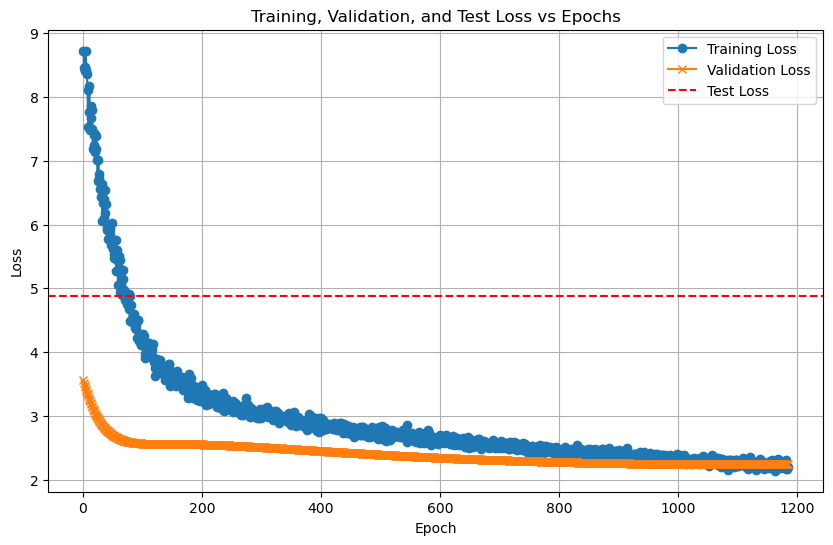

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/579 for test dataset.
  Processed batch 20/579 for test dataset.


  Processed batch 30/579 for test dataset.
  Processed batch 40/579 for test dataset.
  Processed batch 50/579 for test dataset.


  Processed batch 60/579 for test dataset.
  Processed batch 70/579 for test dataset.
  Processed batch 80/579 for test dataset.
  Processed batch 90/579 for test dataset.


  Processed batch 100/579 for test dataset.
  Processed batch 110/579 for test dataset.
  Processed batch 120/579 for test dataset.


  Processed batch 130/579 for test dataset.
  Processed batch 140/579 for test dataset.
  Processed batch 150/579 for test dataset.


  Processed batch 160/579 for test dataset.
  Processed batch 170/579 for test dataset.
  Processed batch 180/579 for test dataset.
  Processed batch 190/579 for test dataset.


  Processed batch 200/579 for test dataset.
  Processed batch 210/579 for test dataset.
  Processed batch 220/579 for test dataset.


  Processed batch 230/579 for test dataset.
  Processed batch 240/579 for test dataset.
  Processed batch 250/579 for test dataset.
  Processed batch 260/579 for test dataset.


  Processed batch 270/579 for test dataset.
  Processed batch 280/579 for test dataset.
  Processed batch 290/579 for test dataset.


  Processed batch 300/579 for test dataset.
  Processed batch 310/579 for test dataset.
  Processed batch 320/579 for test dataset.
  Processed batch 330/579 for test dataset.


  Processed batch 340/579 for test dataset.
  Processed batch 350/579 for test dataset.


  Processed batch 360/579 for test dataset.
  Processed batch 370/579 for test dataset.
  Processed batch 380/579 for test dataset.
  Processed batch 390/579 for test dataset.


  Processed batch 400/579 for test dataset.
  Processed batch 410/579 for test dataset.
  Processed batch 420/579 for test dataset.


  Processed batch 430/579 for test dataset.
  Processed batch 440/579 for test dataset.
  Processed batch 450/579 for test dataset.


  Processed batch 460/579 for test dataset.
  Processed batch 470/579 for test dataset.
  Processed batch 480/579 for test dataset.
  Processed batch 490/579 for test dataset.


  Processed batch 500/579 for test dataset.
  Processed batch 510/579 for test dataset.
  Processed batch 520/579 for test dataset.


  Processed batch 530/579 for test dataset.
  Processed batch 540/579 for test dataset.
  Processed batch 550/579 for test dataset.
  Processed batch 560/579 for test dataset.


  Processed batch 570/579 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148062, 128)
Test labels shape: (148062,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 88.89%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.67      0.80      0.73         5
           2       0.67      0.40      0.50         5
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       1.00      0.80      0.89         5
           6       0.83      1.00      0.91         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.89        45
   macro avg       0.89      0.89      0.88        45
weighted avg       0.89      0.89      0.88        45


LOG: Evaluating on the test set...
Test Accuracy: 92.72%

Test Classifica

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148062, 128)
Test labels shape: (148062,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3152  |  Val Loss: 2.2943
Validation loss improved from inf to 2.2943.
[Epoch 2/1000] Train Loss: 2.3027  |  Val Loss: 2.2834
Validation loss improved from 2.2943 to 2.2834.
[Epoch 3/1000] Train Loss: 2.2905  |  Val Loss: 2.2726
Validation loss improved from 2.2834 to 2.2726.
[Epoch 4/1000] Train Loss: 2.2787  |  Val Loss: 2.2620
Validation loss improved from 2.2726 to 2.2620.
[Epoch 5/1000] Train Loss: 2.2672  |  Val Loss: 2.2515
Validation loss improved from 2.2620 to 2.2515.
[Epoch 6/1000] Train Loss: 2.2560  |  Val Loss: 2.2412
Validation loss improved from 2.2515 to 2.2412.
[Epoch 7/1000] Train Loss: 2.2448  |  Val Loss: 2.2310
Validation loss improved from 2.2412 to 2.2310.
[Epoch 8/1000] Train Loss: 2.2336  |  Val Loss: 2.2210
Validation loss improved from 2.2310 to 2.2210.
[Epoch 9/1000] Train Loss: 2.2225  |  Val Loss: 2.2111
Validation loss improved from 2.2210 to 2.2111.
[Epoch 10/1000] Train Loss: 2.2114  |  Val Loss: 2.2014
Validation loss impr

[Epoch 53/1000] Train Loss: 1.8394  |  Val Loss: 1.8854
Validation loss improved from 1.8914 to 1.8854.
[Epoch 54/1000] Train Loss: 1.8324  |  Val Loss: 1.8794
Validation loss improved from 1.8854 to 1.8794.
[Epoch 55/1000] Train Loss: 1.8255  |  Val Loss: 1.8734
Validation loss improved from 1.8794 to 1.8734.
[Epoch 56/1000] Train Loss: 1.8186  |  Val Loss: 1.8673
Validation loss improved from 1.8734 to 1.8673.
[Epoch 57/1000] Train Loss: 1.8117  |  Val Loss: 1.8612
Validation loss improved from 1.8673 to 1.8612.
[Epoch 58/1000] Train Loss: 1.8047  |  Val Loss: 1.8551
Validation loss improved from 1.8612 to 1.8551.
[Epoch 59/1000] Train Loss: 1.7979  |  Val Loss: 1.8491
Validation loss improved from 1.8551 to 1.8491.
[Epoch 60/1000] Train Loss: 1.7910  |  Val Loss: 1.8431
Validation loss improved from 1.8491 to 1.8431.
[Epoch 61/1000] Train Loss: 1.7842  |  Val Loss: 1.8371
Validation loss improved from 1.8431 to 1.8371.
[Epoch 62/1000] Train Loss: 1.7775  |  Val Loss: 1.8310
Validati

[Epoch 127/1000] Train Loss: 1.3361  |  Val Loss: 1.4482
Validation loss improved from 1.4539 to 1.4482.
[Epoch 128/1000] Train Loss: 1.3294  |  Val Loss: 1.4425
Validation loss improved from 1.4482 to 1.4425.
[Epoch 129/1000] Train Loss: 1.3227  |  Val Loss: 1.4369
Validation loss improved from 1.4425 to 1.4369.
[Epoch 130/1000] Train Loss: 1.3160  |  Val Loss: 1.4311
Validation loss improved from 1.4369 to 1.4311.
[Epoch 131/1000] Train Loss: 1.3093  |  Val Loss: 1.4254
Validation loss improved from 1.4311 to 1.4254.
[Epoch 132/1000] Train Loss: 1.3026  |  Val Loss: 1.4197
Validation loss improved from 1.4254 to 1.4197.
[Epoch 133/1000] Train Loss: 1.2959  |  Val Loss: 1.4139
Validation loss improved from 1.4197 to 1.4139.
[Epoch 134/1000] Train Loss: 1.2892  |  Val Loss: 1.4082
Validation loss improved from 1.4139 to 1.4082.
[Epoch 135/1000] Train Loss: 1.2827  |  Val Loss: 1.4025
Validation loss improved from 1.4082 to 1.4025.
[Epoch 136/1000] Train Loss: 1.2762  |  Val Loss: 1.396

[Epoch 208/1000] Train Loss: 0.8219  |  Val Loss: 1.0056
Validation loss improved from 1.0109 to 1.0056.
[Epoch 209/1000] Train Loss: 0.8160  |  Val Loss: 1.0004
Validation loss improved from 1.0056 to 1.0004.
[Epoch 210/1000] Train Loss: 0.8101  |  Val Loss: 0.9951
Validation loss improved from 1.0004 to 0.9951.
[Epoch 211/1000] Train Loss: 0.8043  |  Val Loss: 0.9899
Validation loss improved from 0.9951 to 0.9899.
[Epoch 212/1000] Train Loss: 0.7984  |  Val Loss: 0.9847
Validation loss improved from 0.9899 to 0.9847.
[Epoch 213/1000] Train Loss: 0.7926  |  Val Loss: 0.9796
Validation loss improved from 0.9847 to 0.9796.
[Epoch 214/1000] Train Loss: 0.7868  |  Val Loss: 0.9745
Validation loss improved from 0.9796 to 0.9745.
[Epoch 215/1000] Train Loss: 0.7810  |  Val Loss: 0.9695
Validation loss improved from 0.9745 to 0.9695.
[Epoch 216/1000] Train Loss: 0.7753  |  Val Loss: 0.9644
Validation loss improved from 0.9695 to 0.9644.
[Epoch 217/1000] Train Loss: 0.7696  |  Val Loss: 0.959

[Epoch 279/1000] Train Loss: 0.4470  |  Val Loss: 0.6670
Validation loss improved from 0.6707 to 0.6670.
[Epoch 280/1000] Train Loss: 0.4431  |  Val Loss: 0.6634
Validation loss improved from 0.6670 to 0.6634.
[Epoch 281/1000] Train Loss: 0.4391  |  Val Loss: 0.6598
Validation loss improved from 0.6634 to 0.6598.
[Epoch 282/1000] Train Loss: 0.4353  |  Val Loss: 0.6563
Validation loss improved from 0.6598 to 0.6563.
[Epoch 283/1000] Train Loss: 0.4315  |  Val Loss: 0.6528
Validation loss improved from 0.6563 to 0.6528.
[Epoch 284/1000] Train Loss: 0.4277  |  Val Loss: 0.6494
Validation loss improved from 0.6528 to 0.6494.
[Epoch 285/1000] Train Loss: 0.4239  |  Val Loss: 0.6460
Validation loss improved from 0.6494 to 0.6460.
[Epoch 286/1000] Train Loss: 0.4202  |  Val Loss: 0.6426
Validation loss improved from 0.6460 to 0.6426.
[Epoch 287/1000] Train Loss: 0.4165  |  Val Loss: 0.6393
Validation loss improved from 0.6426 to 0.6393.
[Epoch 288/1000] Train Loss: 0.4129  |  Val Loss: 0.636

[Epoch 351/1000] Train Loss: 0.2429  |  Val Loss: 0.4947
Validation loss improved from 0.4963 to 0.4947.
[Epoch 352/1000] Train Loss: 0.2409  |  Val Loss: 0.4932
Validation loss improved from 0.4947 to 0.4932.
[Epoch 353/1000] Train Loss: 0.2390  |  Val Loss: 0.4917
Validation loss improved from 0.4932 to 0.4917.
[Epoch 354/1000] Train Loss: 0.2371  |  Val Loss: 0.4902
Validation loss improved from 0.4917 to 0.4902.
[Epoch 355/1000] Train Loss: 0.2352  |  Val Loss: 0.4887
Validation loss improved from 0.4902 to 0.4887.
[Epoch 356/1000] Train Loss: 0.2334  |  Val Loss: 0.4873
Validation loss improved from 0.4887 to 0.4873.
[Epoch 357/1000] Train Loss: 0.2316  |  Val Loss: 0.4859
Validation loss improved from 0.4873 to 0.4859.
[Epoch 358/1000] Train Loss: 0.2298  |  Val Loss: 0.4845
Validation loss improved from 0.4859 to 0.4845.
[Epoch 359/1000] Train Loss: 0.2280  |  Val Loss: 0.4832
Validation loss improved from 0.4845 to 0.4832.
[Epoch 360/1000] Train Loss: 0.2263  |  Val Loss: 0.481

[Epoch 429/1000] Train Loss: 0.1394  |  Val Loss: 0.4205
Validation loss improved from 0.4211 to 0.4205.
[Epoch 430/1000] Train Loss: 0.1385  |  Val Loss: 0.4200
Validation loss improved from 0.4205 to 0.4200.
[Epoch 431/1000] Train Loss: 0.1376  |  Val Loss: 0.4194
Validation loss improved from 0.4200 to 0.4194.
[Epoch 432/1000] Train Loss: 0.1368  |  Val Loss: 0.4189
Validation loss improved from 0.4194 to 0.4189.
[Epoch 433/1000] Train Loss: 0.1359  |  Val Loss: 0.4183
Validation loss improved from 0.4189 to 0.4183.
[Epoch 434/1000] Train Loss: 0.1350  |  Val Loss: 0.4178
Validation loss improved from 0.4183 to 0.4178.
[Epoch 435/1000] Train Loss: 0.1342  |  Val Loss: 0.4173
Validation loss improved from 0.4178 to 0.4173.
[Epoch 436/1000] Train Loss: 0.1333  |  Val Loss: 0.4168
Validation loss improved from 0.4173 to 0.4168.
[Epoch 437/1000] Train Loss: 0.1325  |  Val Loss: 0.4162
Validation loss improved from 0.4168 to 0.4162.
[Epoch 438/1000] Train Loss: 0.1317  |  Val Loss: 0.415

[Epoch 507/1000] Train Loss: 0.0881  |  Val Loss: 0.3918
Validation loss improved from 0.3920 to 0.3918.
[Epoch 508/1000] Train Loss: 0.0876  |  Val Loss: 0.3915
Validation loss improved from 0.3918 to 0.3915.
[Epoch 509/1000] Train Loss: 0.0872  |  Val Loss: 0.3913
Validation loss improved from 0.3915 to 0.3913.
[Epoch 510/1000] Train Loss: 0.0867  |  Val Loss: 0.3911
Validation loss improved from 0.3913 to 0.3911.
[Epoch 511/1000] Train Loss: 0.0862  |  Val Loss: 0.3909
Validation loss improved from 0.3911 to 0.3909.
[Epoch 512/1000] Train Loss: 0.0858  |  Val Loss: 0.3906
Validation loss improved from 0.3909 to 0.3906.
[Epoch 513/1000] Train Loss: 0.0853  |  Val Loss: 0.3904
Validation loss improved from 0.3906 to 0.3904.
[Epoch 514/1000] Train Loss: 0.0848  |  Val Loss: 0.3902
Validation loss improved from 0.3904 to 0.3902.
[Epoch 515/1000] Train Loss: 0.0844  |  Val Loss: 0.3900
Validation loss improved from 0.3902 to 0.3900.
[Epoch 516/1000] Train Loss: 0.0839  |  Val Loss: 0.389

[Epoch 586/1000] Train Loss: 0.0591  |  Val Loss: 0.3802
Validation loss improved from 0.3802 to 0.3802.
[Epoch 587/1000] Train Loss: 0.0589  |  Val Loss: 0.3802
Validation loss improved from 0.3802 to 0.3802.
[Epoch 588/1000] Train Loss: 0.0586  |  Val Loss: 0.3801
Validation loss improved from 0.3802 to 0.3801.
[Epoch 589/1000] Train Loss: 0.0583  |  Val Loss: 0.3801
Validation loss improved from 0.3801 to 0.3801.
[Epoch 590/1000] Train Loss: 0.0581  |  Val Loss: 0.3801
Validation loss improved from 0.3801 to 0.3801.
[Epoch 591/1000] Train Loss: 0.0578  |  Val Loss: 0.3800
Validation loss improved from 0.3801 to 0.3800.
[Epoch 592/1000] Train Loss: 0.0575  |  Val Loss: 0.3800
Validation loss improved from 0.3800 to 0.3800.
[Epoch 593/1000] Train Loss: 0.0573  |  Val Loss: 0.3800
Validation loss improved from 0.3800 to 0.3800.
[Epoch 594/1000] Train Loss: 0.0570  |  Val Loss: 0.3799
Validation loss improved from 0.3800 to 0.3799.
[Epoch 595/1000] Train Loss: 0.0567  |  Val Loss: 0.379

[Epoch 662/1000] Train Loss: 0.0424  |  Val Loss: 0.3788
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 663/1000] Train Loss: 0.0423  |  Val Loss: 0.3788
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 664/1000] Train Loss: 0.0421  |  Val Loss: 0.3788
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 665/1000] Train Loss: 0.0419  |  Val Loss: 0.3789
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 666/1000] Train Loss: 0.0418  |  Val Loss: 0.3789
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 667/1000] Train Loss: 0.0416  |  Val Loss: 0.3789
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 668/1000] Train Loss: 0.0414  |  Val Loss: 0.3789
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 669/1000] Train Loss: 0.0413  |  Val Loss: 0.3789
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 670/1000] Train Loss: 0.0411  |  Val Loss: 0.3789
!! Validation loss did NOT improve !! Patience: 

[Epoch 736/1000] Train Loss: 0.0321  |  Val Loss: 0.3792
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 737/1000] Train Loss: 0.0320  |  Val Loss: 0.3793
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 738/1000] Train Loss: 0.0319  |  Val Loss: 0.3793
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 739/1000] Train Loss: 0.0318  |  Val Loss: 0.3793
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 740/1000] Train Loss: 0.0317  |  Val Loss: 0.3793
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 741/1000] Train Loss: 0.0315  |  Val Loss: 0.3793
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 742/1000] Train Loss: 0.0314  |  Val Loss: 0.3793
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 743/1000] Train Loss: 0.0313  |  Val Loss: 0.3794
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 744/1000] Train Loss: 0.0312  |  Val Loss: 0.3794
!! Validation loss did NOT improve !! Patience:

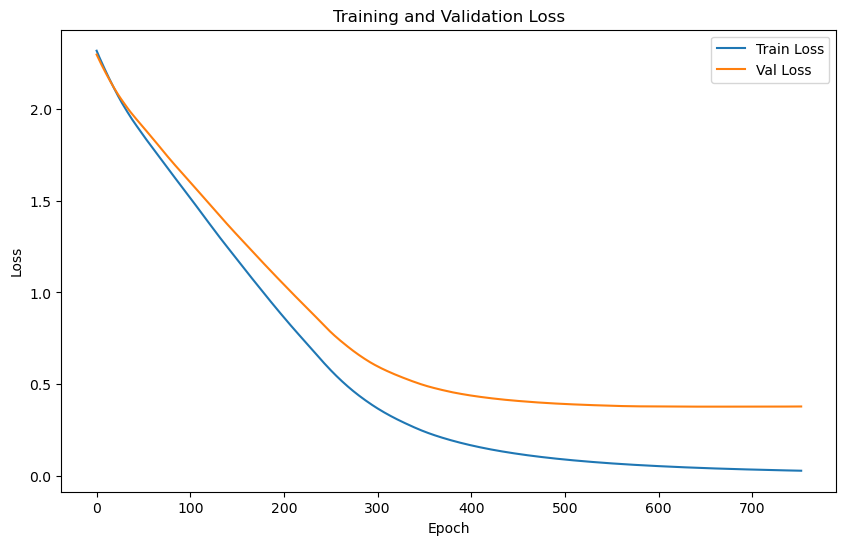

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.3044 | Test Accuracy: 90.25%


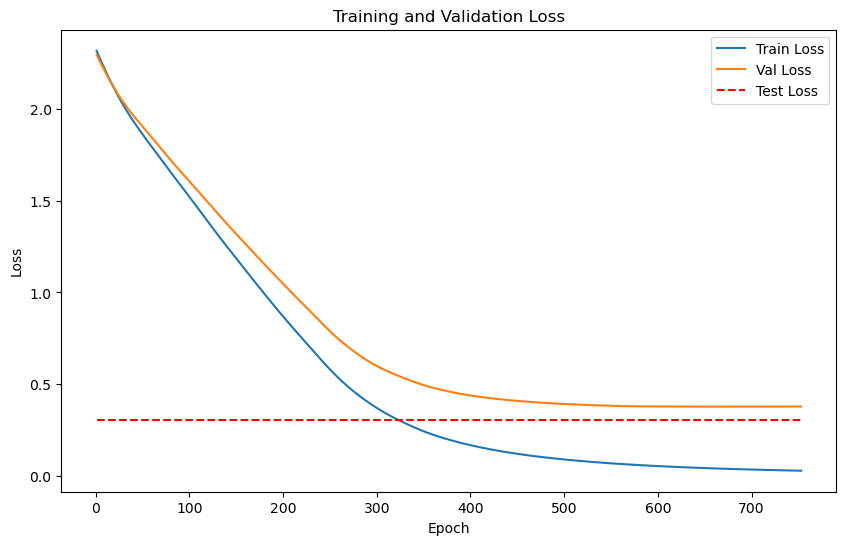

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148062 samples with 64 features each
LOG: Labels shape: (148062,)


Train embeddings shape: (45, 64), 
Train labels shape: (45,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (148062, 64), 
Test labels shape: (148062,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Training batch size: 45


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4194
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.3628
Epoch [1/2000], Avg Train Loss: 0.4194, Avg Val Loss: 0.3628

Validation loss improved from inf to 0.3628. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.3624
Epoch [2/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.3624

Validation loss improved from 0.3628 to 0.3624. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [3/2000] - Validation
    Batch [1/1], Val Loss: 0.3625
Epoch [3/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.3625

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.3630
Epoch [4/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.3630

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4331
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.3631
Epoch [5/2000], Avg Train Loss: 0.4331, Avg Val Loss: 0.3631

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.4339
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.3623
Epoch [6/2000], Avg Train Loss: 0.4339, Avg Val Loss: 0.3623

Validation loss improved from 0.3624 to 0.3623. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.4261
LOG: Epoch [7/2000] - Validation


    Batch [1/1], Val Loss: 0.3604
Epoch [7/2000], Avg Train Loss: 0.4261, Avg Val Loss: 0.3604

Validation loss improved from 0.3623 to 0.3604. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.4254
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.3581
Epoch [8/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.3581

Validation loss improved from 0.3604 to 0.3581. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.4319
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [9/2000], Avg Train Loss: 0.4319, Avg Val Loss: 0.3558

Validation loss improved from 0.3581 to 0.3558. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4249
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.3534
Epoch [10/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.3534

Validation loss improved from 0.3558 to 0.3534. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4314
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.3522
Epoch [11/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.3522

Validation loss improved from 0.3534 to 0.3522. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [12/2000] - Validation


    Batch [1/1], Val Loss: 0.3518
Epoch [12/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.3518

Validation loss improved from 0.3522 to 0.3518. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.3521
Epoch [13/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.3521

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.4249
LOG: Epoch [14/2000] - Validation


    Batch [1/1], Val Loss: 0.3521
Epoch [14/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.3521

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.4232
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.3523
Epoch [15/2000], Avg Train Loss: 0.4232, Avg Val Loss: 0.3523

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [16/2000] - Validation


    Batch [1/1], Val Loss: 0.3528
Epoch [16/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.3528

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.4108
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.3530
Epoch [17/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.3530

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.4239
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.3534
Epoch [18/2000], Avg Train Loss: 0.4239, Avg Val Loss: 0.3534

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.3538
Epoch [19/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.3538

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4256
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.3541
Epoch [20/2000], Avg Train Loss: 0.4256, Avg Val Loss: 0.3541

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [21/2000] - Validation


    Batch [1/1], Val Loss: 0.3545
Epoch [21/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.3545

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4236
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.3548
Epoch [22/2000], Avg Train Loss: 0.4236, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [23/2000] - Validation


    Batch [1/1], Val Loss: 0.3551
Epoch [23/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.3551

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [24/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.3556
Epoch [25/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.3556

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4244
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [26/2000], Avg Train Loss: 0.4244, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4183
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.3559
Epoch [27/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.3559

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [28/2000] - Validation


    Batch [1/1], Val Loss: 0.3559
Epoch [28/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.3559

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.3559
Epoch [29/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3559

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [30/2000] - Validation


    Batch [1/1], Val Loss: 0.3559
Epoch [30/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.3559

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [31/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [32/2000] - Validation


    Batch [1/1], Val Loss: 0.3557
Epoch [32/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.3556
Epoch [33/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.3556

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [34/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.3555

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.3553
Epoch [35/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.3553

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.4079
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.3550
Epoch [36/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.3550

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.3548
Epoch [37/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.3545
Epoch [38/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.3545

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [39/2000] - Validation


    Batch [1/1], Val Loss: 0.3546
Epoch [39/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.4088
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [40/2000], Avg Train Loss: 0.4088, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [41/2000] - Validation


    Batch [1/1], Val Loss: 0.3547
Epoch [41/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.3548
Epoch [42/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [43/2000] - Validation


    Batch [1/1], Val Loss: 0.3548
Epoch [43/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.3549
Epoch [44/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3549

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [45/2000] - Validation


    Batch [1/1], Val Loss: 0.3549
Epoch [45/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3549

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.3549
Epoch [46/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.3549

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [47/2000] - Validation


    Batch [1/1], Val Loss: 0.3550
Epoch [47/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.3550

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.3550
Epoch [48/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.3550

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.3550
Epoch [49/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.3550

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3550
Epoch [50/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.3550

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3550
Epoch [51/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3550

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.3550
Epoch [52/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.3550

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.4122
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.3550
Epoch [53/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.3550

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.3550
Epoch [54/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3550

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.3550
Epoch [55/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.3550

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [56/2000] - Validation


    Batch [1/1], Val Loss: 0.3549
Epoch [56/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.3549

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.3549
Epoch [57/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.3549

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.3549
Epoch [58/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3549

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3549
Epoch [59/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.3549

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.3549
Epoch [60/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.3549

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.3548
Epoch [61/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.3548
Epoch [62/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [63/2000] - Validation


    Batch [1/1], Val Loss: 0.3548
Epoch [63/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [64/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.4110
LOG: Epoch [65/2000] - Validation


    Batch [1/1], Val Loss: 0.3547
Epoch [65/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.4076
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [66/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [67/2000] - Validation


    Batch [1/1], Val Loss: 0.3547
Epoch [67/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [68/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [69/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [70/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [71/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [72/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [73/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [74/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [75/2000] - Validation


    Batch [1/1], Val Loss: 0.3547
Epoch [75/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [76/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [77/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [78/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [79/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.3862
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [80/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.4070
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [81/2000], Avg Train Loss: 0.4070, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [82/2000] - Validation


    Batch [1/1], Val Loss: 0.3547
Epoch [82/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [83/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [84/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [85/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [86/2000] - Validation


    Batch [1/1], Val Loss: 0.3546
Epoch [86/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [87/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [88/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [89/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [90/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [91/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [92/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [93/2000] - Validation


    Batch [1/1], Val Loss: 0.3546
Epoch [93/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [94/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [95/2000] - Validation


    Batch [1/1], Val Loss: 0.3546
Epoch [95/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [96/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [97/2000] - Validation


    Batch [1/1], Val Loss: 0.3546
Epoch [97/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [98/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [99/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [100/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [101/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [102/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [103/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [104/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [105/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [106/2000] - Validation


    Batch [1/1], Val Loss: 0.3546
Epoch [106/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [107/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [108/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [109/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [110/2000] - Validation


    Batch [1/1], Val Loss: 0.3546
Epoch [110/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.3830
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [111/2000], Avg Train Loss: 0.3830, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [112/2000] - Validation


    Batch [1/1], Val Loss: 0.3546
Epoch [112/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 112!!
No improvement for 100 epochs


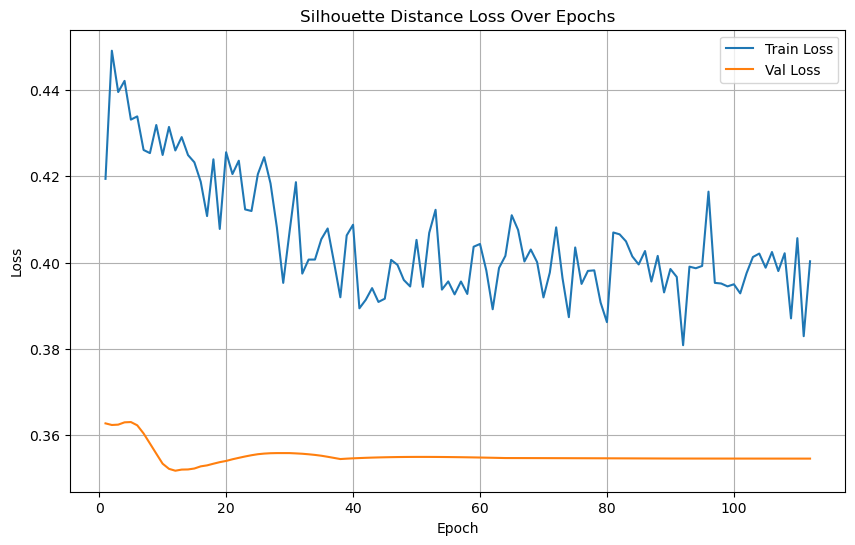

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/2314], Loss: 0.1673
Test Batch [20/2314], Loss: 0.3038


Test Batch [30/2314], Loss: 0.5000
Test Batch [40/2314], Loss: 0.2599
Test Batch [50/2314], Loss: 0.5000
Test Batch [60/2314], Loss: 0.5000


Test Batch [70/2314], Loss: 0.5000
Test Batch [80/2314], Loss: 0.3273
Test Batch [90/2314], Loss: 0.5000


Test Batch [100/2314], Loss: 0.1372
Test Batch [110/2314], Loss: 0.5000
Test Batch [120/2314], Loss: 0.3344
Test Batch [130/2314], Loss: 0.5000
Test Batch [140/2314], Loss: 0.5000


Test Batch [150/2314], Loss: 0.5000


Test Batch [160/2314], Loss: 0.2851
Test Batch [170/2314], Loss: 0.5000
Test Batch [180/2314], Loss: 0.5000
Test Batch [190/2314], Loss: 0.5000
Test Batch [200/2314], Loss: 0.3700
Test Batch [210/2314], Loss: 0.5000
Test Batch [220/2314], Loss: 0.5000


Test Batch [230/2314], Loss: 0.1770
Test Batch [240/2314], Loss: 0.0705
Test Batch [250/2314], Loss: 0.2486
Test Batch [260/2314], Loss: 0.5000
Test Batch [270/2314], Loss: 0.5000
Test Batch [280/2314], Loss: 0.5000
Test Batch [290/2314], Loss: 0.1967


Test Batch [300/2314], Loss: 0.1667
Test Batch [310/2314], Loss: 0.5000
Test Batch [320/2314], Loss: 0.1667
Test Batch [330/2314], Loss: 0.5000
Test Batch [340/2314], Loss: 0.5000
Test Batch [350/2314], Loss: 0.2762
Test Batch [360/2314], Loss: 0.2469


Test Batch [370/2314], Loss: 0.2813
Test Batch [380/2314], Loss: 0.1756
Test Batch [390/2314], Loss: 0.5000
Test Batch [400/2314], Loss: 0.5000
Test Batch [410/2314], Loss: 0.0686
Test Batch [420/2314], Loss: 0.1213
Test Batch [430/2314], Loss: 0.3022


Test Batch [440/2314], Loss: 0.5000
Test Batch [450/2314], Loss: 0.1149
Test Batch [460/2314], Loss: 0.5000
Test Batch [470/2314], Loss: 0.2691
Test Batch [480/2314], Loss: 0.5000
Test Batch [490/2314], Loss: 0.1820


Test Batch [500/2314], Loss: 0.1231
Test Batch [510/2314], Loss: 0.1747
Test Batch [520/2314], Loss: 0.1399
Test Batch [530/2314], Loss: 0.5000
Test Batch [540/2314], Loss: 0.1181
Test Batch [550/2314], Loss: 0.1191
Test Batch [560/2314], Loss: 0.5000


Test Batch [570/2314], Loss: 0.5000
Test Batch [580/2314], Loss: 0.2215
Test Batch [590/2314], Loss: 0.0993
Test Batch [600/2314], Loss: 0.5000
Test Batch [610/2314], Loss: 0.5000


Test Batch [620/2314], Loss: 0.2124
Test Batch [630/2314], Loss: 0.0435
Test Batch [640/2314], Loss: 0.3020
Test Batch [650/2314], Loss: 0.0287
Test Batch [660/2314], Loss: 0.0379
Test Batch [670/2314], Loss: 0.2566


Test Batch [680/2314], Loss: 0.5000
Test Batch [690/2314], Loss: 0.1692
Test Batch [700/2314], Loss: 0.3597
Test Batch [710/2314], Loss: 0.5000
Test Batch [720/2314], Loss: 0.5000
Test Batch [730/2314], Loss: 0.5000


Test Batch [740/2314], Loss: 0.0847
Test Batch [750/2314], Loss: 0.2917
Test Batch [760/2314], Loss: 0.0871
Test Batch [770/2314], Loss: 0.5000
Test Batch [780/2314], Loss: 0.0869
Test Batch [790/2314], Loss: 0.2904


Test Batch [800/2314], Loss: 0.2501
Test Batch [810/2314], Loss: 0.5000
Test Batch [820/2314], Loss: 0.2758
Test Batch [830/2314], Loss: 0.1332
Test Batch [840/2314], Loss: 0.5000
Test Batch [850/2314], Loss: 0.2755


Test Batch [860/2314], Loss: 0.5000
Test Batch [870/2314], Loss: 0.3117
Test Batch [880/2314], Loss: 0.1506
Test Batch [890/2314], Loss: 0.5000
Test Batch [900/2314], Loss: 0.5000
Test Batch [910/2314], Loss: 0.0945
Test Batch [920/2314], Loss: 0.5000
Test Batch [930/2314], Loss: 0.2712


Test Batch [940/2314], Loss: 0.3244
Test Batch [950/2314], Loss: 0.0881
Test Batch [960/2314], Loss: 0.0567
Test Batch [970/2314], Loss: 0.5000
Test Batch [980/2314], Loss: 0.5000
Test Batch [990/2314], Loss: 0.2378
Test Batch [1000/2314], Loss: 0.5000


Test Batch [1010/2314], Loss: 0.2592
Test Batch [1020/2314], Loss: 0.0826
Test Batch [1030/2314], Loss: 0.5000
Test Batch [1040/2314], Loss: 0.3241
Test Batch [1050/2314], Loss: 0.0754
Test Batch [1060/2314], Loss: 0.5000
Test Batch [1070/2314], Loss: 0.5000


Test Batch [1080/2314], Loss: 0.5000
Test Batch [1090/2314], Loss: 0.0577
Test Batch [1100/2314], Loss: 0.2157
Test Batch [1110/2314], Loss: 0.2859
Test Batch [1120/2314], Loss: 0.0678
Test Batch [1130/2314], Loss: 0.2555


Test Batch [1140/2314], Loss: 0.2098
Test Batch [1150/2314], Loss: 0.0581
Test Batch [1160/2314], Loss: 0.0645
Test Batch [1170/2314], Loss: 0.0330


Test Batch [1180/2314], Loss: 0.2613
Test Batch [1190/2314], Loss: 0.3334
Test Batch [1200/2314], Loss: 0.0545
Test Batch [1210/2314], Loss: 0.0938


Test Batch [1220/2314], Loss: 0.2979
Test Batch [1230/2314], Loss: 0.5000
Test Batch [1240/2314], Loss: 0.2143
Test Batch [1250/2314], Loss: 0.5000
Test Batch [1260/2314], Loss: 0.2942


Test Batch [1270/2314], Loss: 0.1331
Test Batch [1280/2314], Loss: 0.5000
Test Batch [1290/2314], Loss: 0.1431
Test Batch [1300/2314], Loss: 0.5000


Test Batch [1310/2314], Loss: 0.3371
Test Batch [1320/2314], Loss: 0.3369
Test Batch [1330/2314], Loss: 0.2233
Test Batch [1340/2314], Loss: 0.0870


Test Batch [1350/2314], Loss: 0.2396
Test Batch [1360/2314], Loss: 0.3284
Test Batch [1370/2314], Loss: 0.3466
Test Batch [1380/2314], Loss: 0.3565


Test Batch [1390/2314], Loss: 0.2956
Test Batch [1400/2314], Loss: 0.3447
Test Batch [1410/2314], Loss: 0.3398


Test Batch [1420/2314], Loss: 0.3449
Test Batch [1430/2314], Loss: 0.5000
Test Batch [1440/2314], Loss: 0.3100
Test Batch [1450/2314], Loss: 0.3186


Test Batch [1460/2314], Loss: 0.3414
Test Batch [1470/2314], Loss: 0.3246
Test Batch [1480/2314], Loss: 0.3462
Test Batch [1490/2314], Loss: 0.3820
Test Batch [1500/2314], Loss: 0.3318


Test Batch [1510/2314], Loss: 0.5000
Test Batch [1520/2314], Loss: 0.5000
Test Batch [1530/2314], Loss: 0.2879
Test Batch [1540/2314], Loss: 0.2839


Test Batch [1550/2314], Loss: 0.2827
Test Batch [1560/2314], Loss: 0.3049
Test Batch [1570/2314], Loss: 0.3153
Test Batch [1580/2314], Loss: 0.2364


Test Batch [1590/2314], Loss: 0.3165
Test Batch [1600/2314], Loss: 0.2117
Test Batch [1610/2314], Loss: 0.2198
Test Batch [1620/2314], Loss: 0.3612
Test Batch [1630/2314], Loss: 0.3034


Test Batch [1640/2314], Loss: 0.3314
Test Batch [1650/2314], Loss: 0.1171
Test Batch [1660/2314], Loss: 0.2919
Test Batch [1670/2314], Loss: 0.3059


Test Batch [1680/2314], Loss: 0.3564
Test Batch [1690/2314], Loss: 0.3022
Test Batch [1700/2314], Loss: 0.2453
Test Batch [1710/2314], Loss: 0.2493
Test Batch [1720/2314], Loss: 0.1929


Test Batch [1730/2314], Loss: 0.2945
Test Batch [1740/2314], Loss: 0.5000
Test Batch [1750/2314], Loss: 0.1334
Test Batch [1760/2314], Loss: 0.2494
Test Batch [1770/2314], Loss: 0.2444
Test Batch [1780/2314], Loss: 0.2341


Test Batch [1790/2314], Loss: 0.1848
Test Batch [1800/2314], Loss: 0.2210
Test Batch [1810/2314], Loss: 0.2918
Test Batch [1820/2314], Loss: 0.3105
Test Batch [1830/2314], Loss: 0.0421
Test Batch [1840/2314], Loss: 0.3602


Test Batch [1850/2314], Loss: 0.3142
Test Batch [1860/2314], Loss: 0.3456
Test Batch [1870/2314], Loss: 0.3426
Test Batch [1880/2314], Loss: 0.2512
Test Batch [1890/2314], Loss: 0.2480


Test Batch [1900/2314], Loss: 0.3663
Test Batch [1910/2314], Loss: 0.3184
Test Batch [1920/2314], Loss: 0.3187
Test Batch [1930/2314], Loss: 0.2281


Test Batch [1940/2314], Loss: 0.3043
Test Batch [1950/2314], Loss: 0.5000
Test Batch [1960/2314], Loss: 0.2847
Test Batch [1970/2314], Loss: 0.2960
Test Batch [1980/2314], Loss: 0.3033
Test Batch [1990/2314], Loss: 0.2855


Test Batch [2000/2314], Loss: 0.3058
Test Batch [2010/2314], Loss: 0.2719
Test Batch [2020/2314], Loss: 0.3012
Test Batch [2030/2314], Loss: 0.2502
Test Batch [2040/2314], Loss: 0.2994


Test Batch [2050/2314], Loss: 0.3393
Test Batch [2060/2314], Loss: 0.2632
Test Batch [2070/2314], Loss: 0.2206
Test Batch [2080/2314], Loss: 0.5000
Test Batch [2090/2314], Loss: 0.5000
Test Batch [2100/2314], Loss: 0.5000
Test Batch [2110/2314], Loss: 0.2265


Test Batch [2120/2314], Loss: 0.2045
Test Batch [2130/2314], Loss: 0.1140
Test Batch [2140/2314], Loss: 0.2519
Test Batch [2150/2314], Loss: 0.5000
Test Batch [2160/2314], Loss: 0.5000
Test Batch [2170/2314], Loss: 0.5000


Test Batch [2180/2314], Loss: 0.2205
Test Batch [2190/2314], Loss: 0.0631
Test Batch [2200/2314], Loss: 0.3326
Test Batch [2210/2314], Loss: 0.0538
Test Batch [2220/2314], Loss: 0.5000
Test Batch [2230/2314], Loss: 0.0405


Test Batch [2240/2314], Loss: 0.5000
Test Batch [2250/2314], Loss: 0.5000
Test Batch [2260/2314], Loss: 0.5000
Test Batch [2270/2314], Loss: 0.3616
Test Batch [2280/2314], Loss: 0.2874
Test Batch [2290/2314], Loss: 0.5000


Test Batch [2300/2314], Loss: 0.5000
Test Batch [2310/2314], Loss: 0.2139

Test Loss: 0.3084


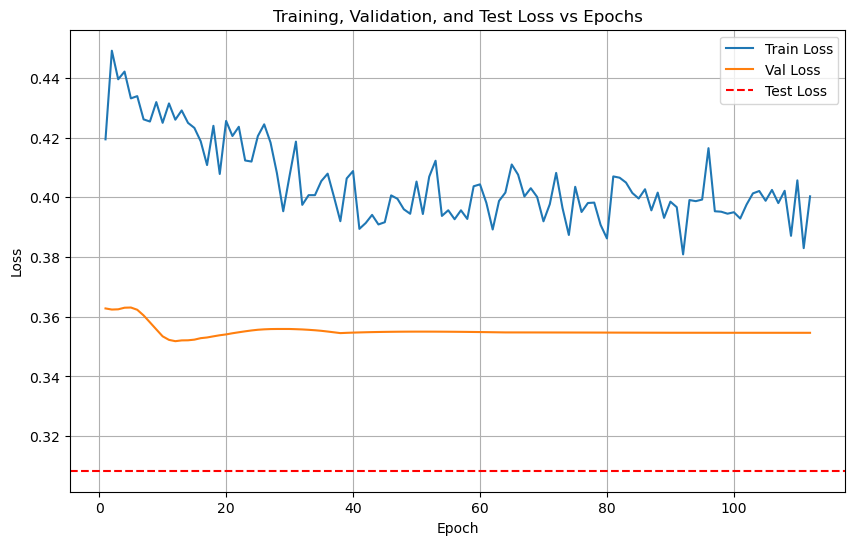

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/2314 for test dataset.
  Processed batch 20/2314 for test dataset.
  Processed batch 30/2314 for test dataset.


  Processed batch 40/2314 for test dataset.


  Processed batch 50/2314 for test dataset.
  Processed batch 60/2314 for test dataset.


  Processed batch 70/2314 for test dataset.


  Processed batch 80/2314 for test dataset.
  Processed batch 90/2314 for test dataset.
  Processed batch 100/2314 for test dataset.


  Processed batch 110/2314 for test dataset.


  Processed batch 120/2314 for test dataset.
  Processed batch 130/2314 for test dataset.
  Processed batch 140/2314 for test dataset.


  Processed batch 150/2314 for test dataset.
  Processed batch 160/2314 for test dataset.
  Processed batch 170/2314 for test dataset.
  Processed batch 180/2314 for test dataset.


  Processed batch 190/2314 for test dataset.
  Processed batch 200/2314 for test dataset.
  Processed batch 210/2314 for test dataset.
  Processed batch 220/2314 for test dataset.


  Processed batch 230/2314 for test dataset.
  Processed batch 240/2314 for test dataset.
  Processed batch 250/2314 for test dataset.
  Processed batch 260/2314 for test dataset.


  Processed batch 270/2314 for test dataset.
  Processed batch 280/2314 for test dataset.
  Processed batch 290/2314 for test dataset.
  Processed batch 300/2314 for test dataset.


  Processed batch 310/2314 for test dataset.
  Processed batch 320/2314 for test dataset.
  Processed batch 330/2314 for test dataset.


  Processed batch 340/2314 for test dataset.
  Processed batch 350/2314 for test dataset.
  Processed batch 360/2314 for test dataset.
  Processed batch 370/2314 for test dataset.


  Processed batch 380/2314 for test dataset.
  Processed batch 390/2314 for test dataset.
  Processed batch 400/2314 for test dataset.
  Processed batch 410/2314 for test dataset.


  Processed batch 420/2314 for test dataset.
  Processed batch 430/2314 for test dataset.
  Processed batch 440/2314 for test dataset.
  Processed batch 450/2314 for test dataset.


  Processed batch 460/2314 for test dataset.
  Processed batch 470/2314 for test dataset.
  Processed batch 480/2314 for test dataset.
  Processed batch 490/2314 for test dataset.


  Processed batch 500/2314 for test dataset.
  Processed batch 510/2314 for test dataset.
  Processed batch 520/2314 for test dataset.
  Processed batch 530/2314 for test dataset.


  Processed batch 540/2314 for test dataset.
  Processed batch 550/2314 for test dataset.
  Processed batch 560/2314 for test dataset.
  Processed batch 570/2314 for test dataset.


  Processed batch 580/2314 for test dataset.
  Processed batch 590/2314 for test dataset.
  Processed batch 600/2314 for test dataset.
  Processed batch 610/2314 for test dataset.


  Processed batch 620/2314 for test dataset.
  Processed batch 630/2314 for test dataset.
  Processed batch 640/2314 for test dataset.
  Processed batch 650/2314 for test dataset.


  Processed batch 660/2314 for test dataset.
  Processed batch 670/2314 for test dataset.
  Processed batch 680/2314 for test dataset.
  Processed batch 690/2314 for test dataset.


  Processed batch 700/2314 for test dataset.
  Processed batch 710/2314 for test dataset.
  Processed batch 720/2314 for test dataset.
  Processed batch 730/2314 for test dataset.


  Processed batch 740/2314 for test dataset.
  Processed batch 750/2314 for test dataset.
  Processed batch 760/2314 for test dataset.
  Processed batch 770/2314 for test dataset.


  Processed batch 780/2314 for test dataset.
  Processed batch 790/2314 for test dataset.
  Processed batch 800/2314 for test dataset.
  Processed batch 810/2314 for test dataset.


  Processed batch 820/2314 for test dataset.
  Processed batch 830/2314 for test dataset.
  Processed batch 840/2314 for test dataset.
  Processed batch 850/2314 for test dataset.


  Processed batch 860/2314 for test dataset.
  Processed batch 870/2314 for test dataset.
  Processed batch 880/2314 for test dataset.
  Processed batch 890/2314 for test dataset.


  Processed batch 900/2314 for test dataset.
  Processed batch 910/2314 for test dataset.
  Processed batch 920/2314 for test dataset.
  Processed batch 930/2314 for test dataset.


  Processed batch 940/2314 for test dataset.
  Processed batch 950/2314 for test dataset.
  Processed batch 960/2314 for test dataset.
  Processed batch 970/2314 for test dataset.


  Processed batch 980/2314 for test dataset.
  Processed batch 990/2314 for test dataset.
  Processed batch 1000/2314 for test dataset.
  Processed batch 1010/2314 for test dataset.


  Processed batch 1020/2314 for test dataset.
  Processed batch 1030/2314 for test dataset.
  Processed batch 1040/2314 for test dataset.
  Processed batch 1050/2314 for test dataset.


  Processed batch 1060/2314 for test dataset.
  Processed batch 1070/2314 for test dataset.
  Processed batch 1080/2314 for test dataset.
  Processed batch 1090/2314 for test dataset.


  Processed batch 1100/2314 for test dataset.
  Processed batch 1110/2314 for test dataset.
  Processed batch 1120/2314 for test dataset.
  Processed batch 1130/2314 for test dataset.


  Processed batch 1140/2314 for test dataset.
  Processed batch 1150/2314 for test dataset.
  Processed batch 1160/2314 for test dataset.
  Processed batch 1170/2314 for test dataset.


  Processed batch 1180/2314 for test dataset.
  Processed batch 1190/2314 for test dataset.
  Processed batch 1200/2314 for test dataset.
  Processed batch 1210/2314 for test dataset.


  Processed batch 1220/2314 for test dataset.
  Processed batch 1230/2314 for test dataset.
  Processed batch 1240/2314 for test dataset.
  Processed batch 1250/2314 for test dataset.


  Processed batch 1260/2314 for test dataset.
  Processed batch 1270/2314 for test dataset.
  Processed batch 1280/2314 for test dataset.
  Processed batch 1290/2314 for test dataset.


  Processed batch 1300/2314 for test dataset.
  Processed batch 1310/2314 for test dataset.
  Processed batch 1320/2314 for test dataset.
  Processed batch 1330/2314 for test dataset.


  Processed batch 1340/2314 for test dataset.
  Processed batch 1350/2314 for test dataset.
  Processed batch 1360/2314 for test dataset.
  Processed batch 1370/2314 for test dataset.


  Processed batch 1380/2314 for test dataset.
  Processed batch 1390/2314 for test dataset.
  Processed batch 1400/2314 for test dataset.
  Processed batch 1410/2314 for test dataset.


  Processed batch 1420/2314 for test dataset.
  Processed batch 1430/2314 for test dataset.
  Processed batch 1440/2314 for test dataset.


  Processed batch 1450/2314 for test dataset.
  Processed batch 1460/2314 for test dataset.
  Processed batch 1470/2314 for test dataset.
  Processed batch 1480/2314 for test dataset.


  Processed batch 1490/2314 for test dataset.
  Processed batch 1500/2314 for test dataset.
  Processed batch 1510/2314 for test dataset.
  Processed batch 1520/2314 for test dataset.


  Processed batch 1530/2314 for test dataset.
  Processed batch 1540/2314 for test dataset.
  Processed batch 1550/2314 for test dataset.
  Processed batch 1560/2314 for test dataset.


  Processed batch 1570/2314 for test dataset.
  Processed batch 1580/2314 for test dataset.
  Processed batch 1590/2314 for test dataset.
  Processed batch 1600/2314 for test dataset.


  Processed batch 1610/2314 for test dataset.
  Processed batch 1620/2314 for test dataset.
  Processed batch 1630/2314 for test dataset.
  Processed batch 1640/2314 for test dataset.


  Processed batch 1650/2314 for test dataset.
  Processed batch 1660/2314 for test dataset.
  Processed batch 1670/2314 for test dataset.
  Processed batch 1680/2314 for test dataset.


  Processed batch 1690/2314 for test dataset.
  Processed batch 1700/2314 for test dataset.
  Processed batch 1710/2314 for test dataset.


  Processed batch 1720/2314 for test dataset.
  Processed batch 1730/2314 for test dataset.
  Processed batch 1740/2314 for test dataset.
  Processed batch 1750/2314 for test dataset.


  Processed batch 1760/2314 for test dataset.
  Processed batch 1770/2314 for test dataset.
  Processed batch 1780/2314 for test dataset.
  Processed batch 1790/2314 for test dataset.


  Processed batch 1800/2314 for test dataset.
  Processed batch 1810/2314 for test dataset.
  Processed batch 1820/2314 for test dataset.
  Processed batch 1830/2314 for test dataset.


  Processed batch 1840/2314 for test dataset.
  Processed batch 1850/2314 for test dataset.
  Processed batch 1860/2314 for test dataset.
  Processed batch 1870/2314 for test dataset.


  Processed batch 1880/2314 for test dataset.
  Processed batch 1890/2314 for test dataset.
  Processed batch 1900/2314 for test dataset.
  Processed batch 1910/2314 for test dataset.


  Processed batch 1920/2314 for test dataset.
  Processed batch 1930/2314 for test dataset.
  Processed batch 1940/2314 for test dataset.
  Processed batch 1950/2314 for test dataset.


  Processed batch 1960/2314 for test dataset.
  Processed batch 1970/2314 for test dataset.
  Processed batch 1980/2314 for test dataset.
  Processed batch 1990/2314 for test dataset.


  Processed batch 2000/2314 for test dataset.
  Processed batch 2010/2314 for test dataset.
  Processed batch 2020/2314 for test dataset.
  Processed batch 2030/2314 for test dataset.


  Processed batch 2040/2314 for test dataset.
  Processed batch 2050/2314 for test dataset.
  Processed batch 2060/2314 for test dataset.
  Processed batch 2070/2314 for test dataset.


  Processed batch 2080/2314 for test dataset.
  Processed batch 2090/2314 for test dataset.
  Processed batch 2100/2314 for test dataset.
  Processed batch 2110/2314 for test dataset.


  Processed batch 2120/2314 for test dataset.
  Processed batch 2130/2314 for test dataset.
  Processed batch 2140/2314 for test dataset.
  Processed batch 2150/2314 for test dataset.


  Processed batch 2160/2314 for test dataset.
  Processed batch 2170/2314 for test dataset.
  Processed batch 2180/2314 for test dataset.
  Processed batch 2190/2314 for test dataset.


  Processed batch 2200/2314 for test dataset.
  Processed batch 2210/2314 for test dataset.
  Processed batch 2220/2314 for test dataset.
  Processed batch 2230/2314 for test dataset.


  Processed batch 2240/2314 for test dataset.
  Processed batch 2250/2314 for test dataset.
  Processed batch 2260/2314 for test dataset.
  Processed batch 2270/2314 for test dataset.


  Processed batch 2280/2314 for test dataset.
  Processed batch 2290/2314 for test dataset.
  Processed batch 2300/2314 for test dataset.
  Processed batch 2310/2314 for test dataset.


Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148062, 128)
Test labels shape: (148062,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 86.67%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      0.80      0.80         5
           2       0.80      0.80      0.80         5
           3       1.00      0.60      0.75         5
           4       0.83      1.00      0.91         5
           5       1.00      0.60      0.75         5
           6       0.62      1.00      0.77         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.87        45
   macro avg       0.90      0.87      0.86        45
weighted avg       0.90      0.87      0.86        45


LOG: Evaluating on the test set...
Test Accuracy: 87.99%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     65961
           1       0.86      0.69      0.76      7588
           2       0.46      0.70      0.55      3080
           3       0.43      0.52      0.47      2675
           4       0.60      0.85      0.70      6574
           5       0.53      0.79      0.63      9238
           6       0.76      0.87      0.81      7277
           7       1.00      0.84      0.91     42816
           8       0.98      0.94      0.96      2853

    accuracy                           0.88    148062
   macro avg       0.73      0.80      0.75    148062
weighted avg       0.91      0.88      0.89    148062

Saved SCL_SDL+LRM predictions and true labels to model_predictions


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148062, 128)
Test labels shape: (148062,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.2137  |  Val Loss: 2.1809
Validation loss improved from inf to 2.1809.
[Epoch 2/1000] Train Loss: 2.2060  |  Val Loss: 2.1751
Validation loss improved from 2.1809 to 2.1751.
[Epoch 3/1000] Train Loss: 2.1982  |  Val Loss: 2.1692
Validation loss improved from 2.1751 to 2.1692.
[Epoch 4/1000] Train Loss: 2.1905  |  Val Loss: 2.1632
Validation loss improved from 2.1692 to 2.1632.
[Epoch 5/1000] Train Loss: 2.1829  |  Val Loss: 2.1572
Validation loss improved from 2.1632 to 2.1572.
[Epoch 6/1000] Train Loss: 2.1753  |  Val Loss: 2.1512
Validation loss improved from 2.1572 to 2.1512.
[Epoch 7/1000] Train Loss: 2.1678  |  Val Loss: 2.1452
Validation loss improved from 2.1512 to 2.1452.
[Epoch 8/1000] Train Loss: 2.1603  |  Val Loss: 2.1393
Validation loss improved from 2.1452 to 2.1393.
[Epoch 9/1000] Train Loss: 2.1529  |  Val Loss: 2.1334
Validation loss improved from 2.1393 to 2.1334.
[Epoch 10/1000] Train Loss: 2.1456  |  Val Loss: 2.1275
Validation loss impr

[Epoch 60/1000] Train Loss: 1.8123  |  Val Loss: 1.8612
Validation loss improved from 1.8663 to 1.8612.
[Epoch 61/1000] Train Loss: 1.8061  |  Val Loss: 1.8560
Validation loss improved from 1.8612 to 1.8560.
[Epoch 62/1000] Train Loss: 1.7999  |  Val Loss: 1.8509
Validation loss improved from 1.8560 to 1.8509.
[Epoch 63/1000] Train Loss: 1.7937  |  Val Loss: 1.8456
Validation loss improved from 1.8509 to 1.8456.
[Epoch 64/1000] Train Loss: 1.7875  |  Val Loss: 1.8403
Validation loss improved from 1.8456 to 1.8403.
[Epoch 65/1000] Train Loss: 1.7812  |  Val Loss: 1.8351
Validation loss improved from 1.8403 to 1.8351.
[Epoch 66/1000] Train Loss: 1.7750  |  Val Loss: 1.8299
Validation loss improved from 1.8351 to 1.8299.
[Epoch 67/1000] Train Loss: 1.7687  |  Val Loss: 1.8248
Validation loss improved from 1.8299 to 1.8248.
[Epoch 68/1000] Train Loss: 1.7625  |  Val Loss: 1.8195
Validation loss improved from 1.8248 to 1.8195.
[Epoch 69/1000] Train Loss: 1.7562  |  Val Loss: 1.8142
Validati

[Epoch 131/1000] Train Loss: 1.3925  |  Val Loss: 1.5110
Validation loss improved from 1.5155 to 1.5110.
[Epoch 132/1000] Train Loss: 1.3870  |  Val Loss: 1.5066
Validation loss improved from 1.5110 to 1.5066.
[Epoch 133/1000] Train Loss: 1.3816  |  Val Loss: 1.5022
Validation loss improved from 1.5066 to 1.5022.
[Epoch 134/1000] Train Loss: 1.3762  |  Val Loss: 1.4978
Validation loss improved from 1.5022 to 1.4978.
[Epoch 135/1000] Train Loss: 1.3707  |  Val Loss: 1.4935
Validation loss improved from 1.4978 to 1.4935.
[Epoch 136/1000] Train Loss: 1.3653  |  Val Loss: 1.4891
Validation loss improved from 1.4935 to 1.4891.
[Epoch 137/1000] Train Loss: 1.3599  |  Val Loss: 1.4848
Validation loss improved from 1.4891 to 1.4848.
[Epoch 138/1000] Train Loss: 1.3546  |  Val Loss: 1.4805
Validation loss improved from 1.4848 to 1.4805.
[Epoch 139/1000] Train Loss: 1.3492  |  Val Loss: 1.4761
Validation loss improved from 1.4805 to 1.4761.
[Epoch 140/1000] Train Loss: 1.3439  |  Val Loss: 1.471

[Epoch 213/1000] Train Loss: 0.9999  |  Val Loss: 1.2057
Validation loss improved from 1.2089 to 1.2057.
[Epoch 214/1000] Train Loss: 0.9956  |  Val Loss: 1.2025
Validation loss improved from 1.2057 to 1.2025.
[Epoch 215/1000] Train Loss: 0.9913  |  Val Loss: 1.1992
Validation loss improved from 1.2025 to 1.1992.
[Epoch 216/1000] Train Loss: 0.9870  |  Val Loss: 1.1960
Validation loss improved from 1.1992 to 1.1960.
[Epoch 217/1000] Train Loss: 0.9826  |  Val Loss: 1.1928
Validation loss improved from 1.1960 to 1.1928.
[Epoch 218/1000] Train Loss: 0.9783  |  Val Loss: 1.1896
Validation loss improved from 1.1928 to 1.1896.
[Epoch 219/1000] Train Loss: 0.9740  |  Val Loss: 1.1863
Validation loss improved from 1.1896 to 1.1863.
[Epoch 220/1000] Train Loss: 0.9697  |  Val Loss: 1.1831
Validation loss improved from 1.1863 to 1.1831.
[Epoch 221/1000] Train Loss: 0.9654  |  Val Loss: 1.1798
Validation loss improved from 1.1831 to 1.1798.
[Epoch 222/1000] Train Loss: 0.9612  |  Val Loss: 1.176

[Epoch 291/1000] Train Loss: 0.6623  |  Val Loss: 0.9564
Validation loss improved from 0.9593 to 0.9564.
[Epoch 292/1000] Train Loss: 0.6581  |  Val Loss: 0.9534
Validation loss improved from 0.9564 to 0.9534.
[Epoch 293/1000] Train Loss: 0.6538  |  Val Loss: 0.9505
Validation loss improved from 0.9534 to 0.9505.
[Epoch 294/1000] Train Loss: 0.6496  |  Val Loss: 0.9476
Validation loss improved from 0.9505 to 0.9476.
[Epoch 295/1000] Train Loss: 0.6454  |  Val Loss: 0.9447
Validation loss improved from 0.9476 to 0.9447.
[Epoch 296/1000] Train Loss: 0.6412  |  Val Loss: 0.9418
Validation loss improved from 0.9447 to 0.9418.
[Epoch 297/1000] Train Loss: 0.6370  |  Val Loss: 0.9389
Validation loss improved from 0.9418 to 0.9389.
[Epoch 298/1000] Train Loss: 0.6328  |  Val Loss: 0.9360
Validation loss improved from 0.9389 to 0.9360.
[Epoch 299/1000] Train Loss: 0.6287  |  Val Loss: 0.9331
Validation loss improved from 0.9360 to 0.9331.
[Epoch 300/1000] Train Loss: 0.6245  |  Val Loss: 0.930

[Epoch 367/1000] Train Loss: 0.3816  |  Val Loss: 0.7597
Validation loss improved from 0.7618 to 0.7597.
[Epoch 368/1000] Train Loss: 0.3786  |  Val Loss: 0.7576
Validation loss improved from 0.7597 to 0.7576.
[Epoch 369/1000] Train Loss: 0.3756  |  Val Loss: 0.7555
Validation loss improved from 0.7576 to 0.7555.
[Epoch 370/1000] Train Loss: 0.3727  |  Val Loss: 0.7534
Validation loss improved from 0.7555 to 0.7534.
[Epoch 371/1000] Train Loss: 0.3698  |  Val Loss: 0.7513
Validation loss improved from 0.7534 to 0.7513.
[Epoch 372/1000] Train Loss: 0.3669  |  Val Loss: 0.7492
Validation loss improved from 0.7513 to 0.7492.
[Epoch 373/1000] Train Loss: 0.3640  |  Val Loss: 0.7471
Validation loss improved from 0.7492 to 0.7471.
[Epoch 374/1000] Train Loss: 0.3612  |  Val Loss: 0.7451
Validation loss improved from 0.7471 to 0.7451.
[Epoch 375/1000] Train Loss: 0.3584  |  Val Loss: 0.7431
Validation loss improved from 0.7451 to 0.7431.
[Epoch 376/1000] Train Loss: 0.3556  |  Val Loss: 0.741

[Epoch 451/1000] Train Loss: 0.1977  |  Val Loss: 0.6306
Validation loss improved from 0.6315 to 0.6306.
[Epoch 452/1000] Train Loss: 0.1961  |  Val Loss: 0.6297
Validation loss improved from 0.6306 to 0.6297.
[Epoch 453/1000] Train Loss: 0.1946  |  Val Loss: 0.6289
Validation loss improved from 0.6297 to 0.6289.
[Epoch 454/1000] Train Loss: 0.1931  |  Val Loss: 0.6280
Validation loss improved from 0.6289 to 0.6280.
[Epoch 455/1000] Train Loss: 0.1916  |  Val Loss: 0.6271
Validation loss improved from 0.6280 to 0.6271.
[Epoch 456/1000] Train Loss: 0.1901  |  Val Loss: 0.6263
Validation loss improved from 0.6271 to 0.6263.
[Epoch 457/1000] Train Loss: 0.1887  |  Val Loss: 0.6254
Validation loss improved from 0.6263 to 0.6254.
[Epoch 458/1000] Train Loss: 0.1872  |  Val Loss: 0.6246
Validation loss improved from 0.6254 to 0.6246.
[Epoch 459/1000] Train Loss: 0.1858  |  Val Loss: 0.6238
Validation loss improved from 0.6246 to 0.6238.
[Epoch 460/1000] Train Loss: 0.1844  |  Val Loss: 0.623

[Epoch 521/1000] Train Loss: 0.1197  |  Val Loss: 0.5889
Validation loss improved from 0.5893 to 0.5889.
[Epoch 522/1000] Train Loss: 0.1189  |  Val Loss: 0.5884
Validation loss improved from 0.5889 to 0.5884.
[Epoch 523/1000] Train Loss: 0.1181  |  Val Loss: 0.5880
Validation loss improved from 0.5884 to 0.5880.
[Epoch 524/1000] Train Loss: 0.1173  |  Val Loss: 0.5876
Validation loss improved from 0.5880 to 0.5876.
[Epoch 525/1000] Train Loss: 0.1165  |  Val Loss: 0.5872
Validation loss improved from 0.5876 to 0.5872.
[Epoch 526/1000] Train Loss: 0.1158  |  Val Loss: 0.5868
Validation loss improved from 0.5872 to 0.5868.
[Epoch 527/1000] Train Loss: 0.1150  |  Val Loss: 0.5863
Validation loss improved from 0.5868 to 0.5863.
[Epoch 528/1000] Train Loss: 0.1142  |  Val Loss: 0.5860
Validation loss improved from 0.5863 to 0.5860.
[Epoch 529/1000] Train Loss: 0.1135  |  Val Loss: 0.5856
Validation loss improved from 0.5860 to 0.5856.
[Epoch 530/1000] Train Loss: 0.1127  |  Val Loss: 0.585

[Epoch 597/1000] Train Loss: 0.0743  |  Val Loss: 0.5712
Validation loss improved from 0.5713 to 0.5712.
[Epoch 598/1000] Train Loss: 0.0738  |  Val Loss: 0.5711
Validation loss improved from 0.5712 to 0.5711.
[Epoch 599/1000] Train Loss: 0.0734  |  Val Loss: 0.5710
Validation loss improved from 0.5711 to 0.5710.
[Epoch 600/1000] Train Loss: 0.0729  |  Val Loss: 0.5709
Validation loss improved from 0.5710 to 0.5709.
[Epoch 601/1000] Train Loss: 0.0725  |  Val Loss: 0.5708
Validation loss improved from 0.5709 to 0.5708.
[Epoch 602/1000] Train Loss: 0.0721  |  Val Loss: 0.5707
Validation loss improved from 0.5708 to 0.5707.
[Epoch 603/1000] Train Loss: 0.0717  |  Val Loss: 0.5706
Validation loss improved from 0.5707 to 0.5706.
[Epoch 604/1000] Train Loss: 0.0713  |  Val Loss: 0.5705
Validation loss improved from 0.5706 to 0.5705.
[Epoch 605/1000] Train Loss: 0.0708  |  Val Loss: 0.5704
Validation loss improved from 0.5705 to 0.5704.
[Epoch 606/1000] Train Loss: 0.0704  |  Val Loss: 0.570

[Epoch 668/1000] Train Loss: 0.0498  |  Val Loss: 0.5672
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 669/1000] Train Loss: 0.0496  |  Val Loss: 0.5672
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 670/1000] Train Loss: 0.0493  |  Val Loss: 0.5672
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 671/1000] Train Loss: 0.0490  |  Val Loss: 0.5672
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 672/1000] Train Loss: 0.0488  |  Val Loss: 0.5672
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 673/1000] Train Loss: 0.0485  |  Val Loss: 0.5672
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 674/1000] Train Loss: 0.0482  |  Val Loss: 0.5672
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 675/1000] Train Loss: 0.0480  |  Val Loss: 0.5672
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 676/1000] Train Loss: 0.0477  |  Val Loss: 0.5672
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 747/1000] Train Loss: 0.0335  |  Val Loss: 0.5709
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 748/1000] Train Loss: 0.0334  |  Val Loss: 0.5710
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 749/1000] Train Loss: 0.0332  |  Val Loss: 0.5711
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 750/1000] Train Loss: 0.0331  |  Val Loss: 0.5712
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 751/1000] Train Loss: 0.0329  |  Val Loss: 0.5713
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 752/1000] Train Loss: 0.0328  |  Val Loss: 0.5714
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 753/1000] Train Loss: 0.0326  |  Val Loss: 0.5714
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 754/1000] Train Loss: 0.0325  |  Val Loss: 0.5715
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 755/1000] Train Loss: 0.0323  |  Val Loss: 0.5716
!! Validation loss did NOT improve !! Patience:

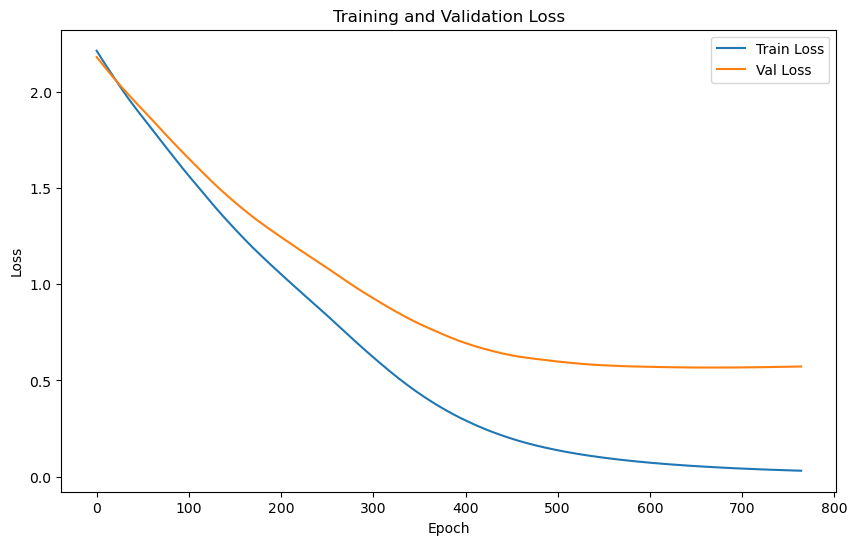

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.4247 | Test Accuracy: 86.83%


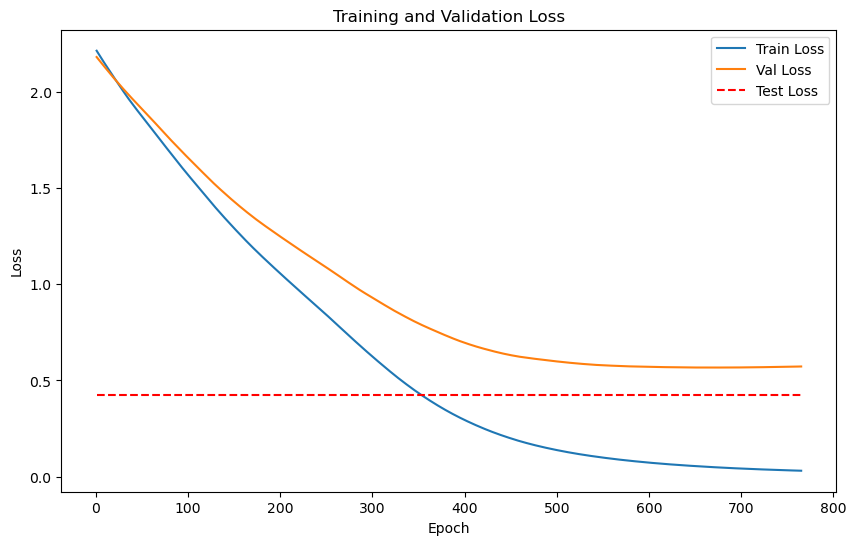

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


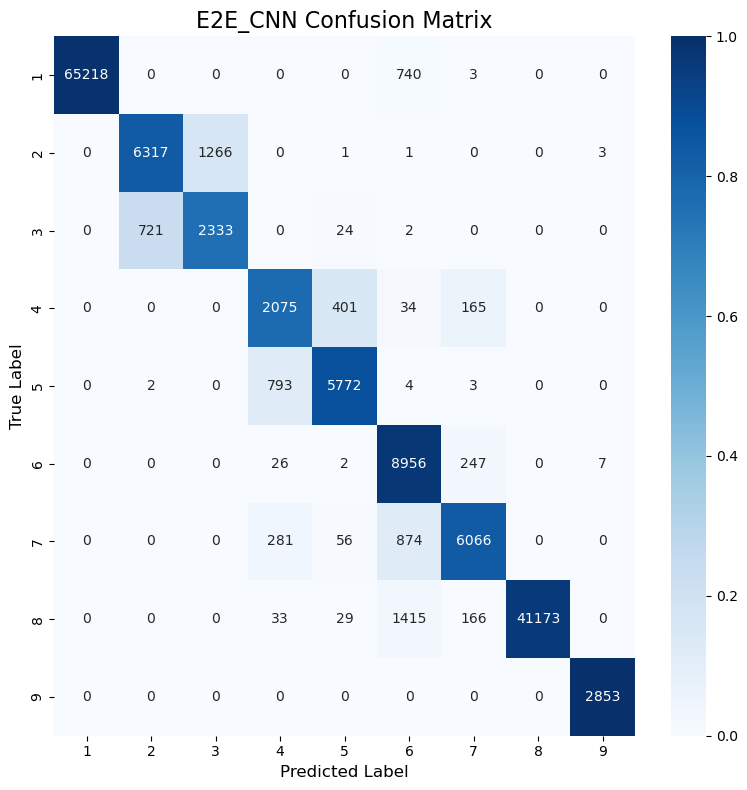

Classification Accuracy: 95.07%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


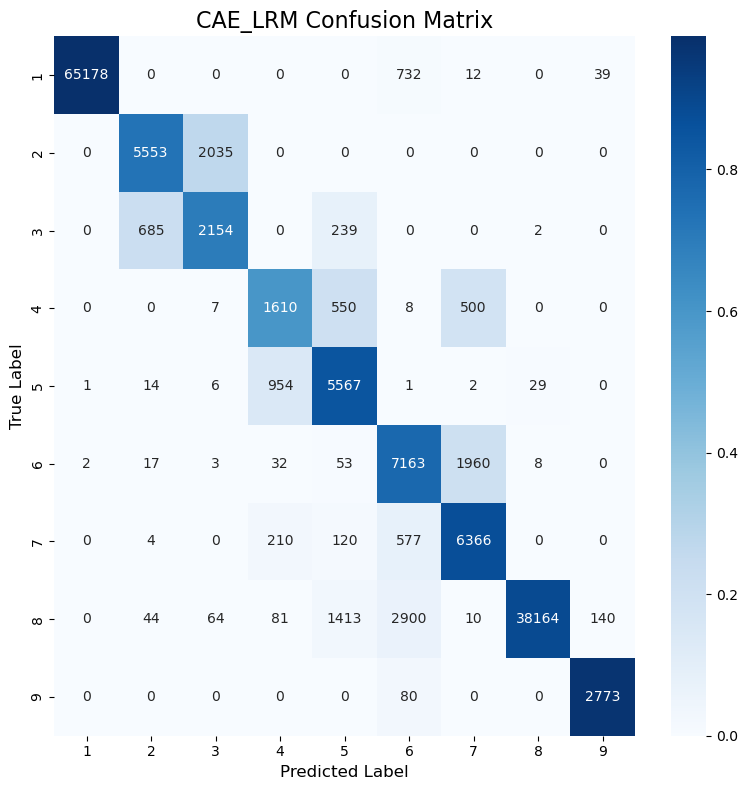

Classification Accuracy: 90.86%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


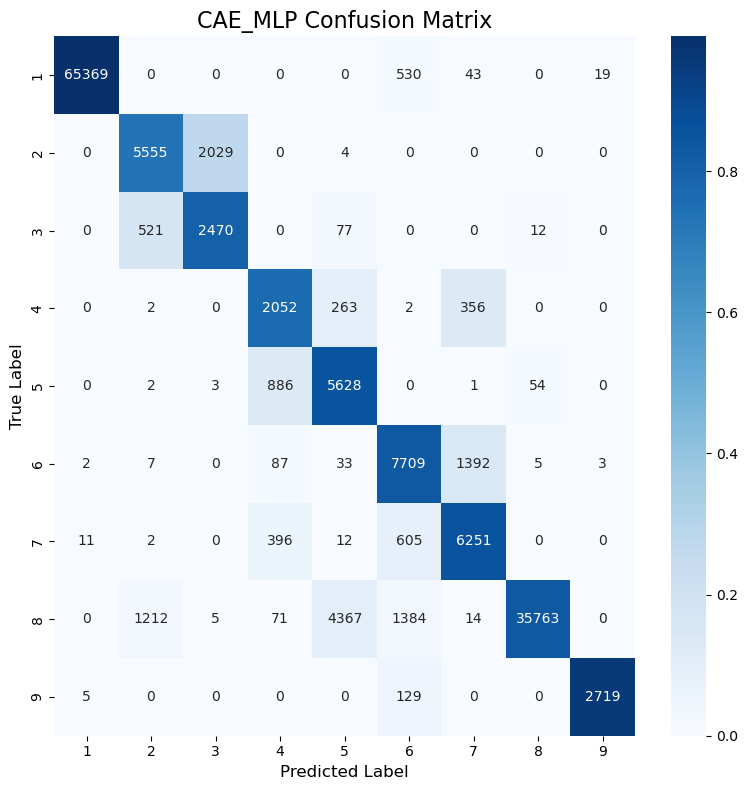

Classification Accuracy: 90.18%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


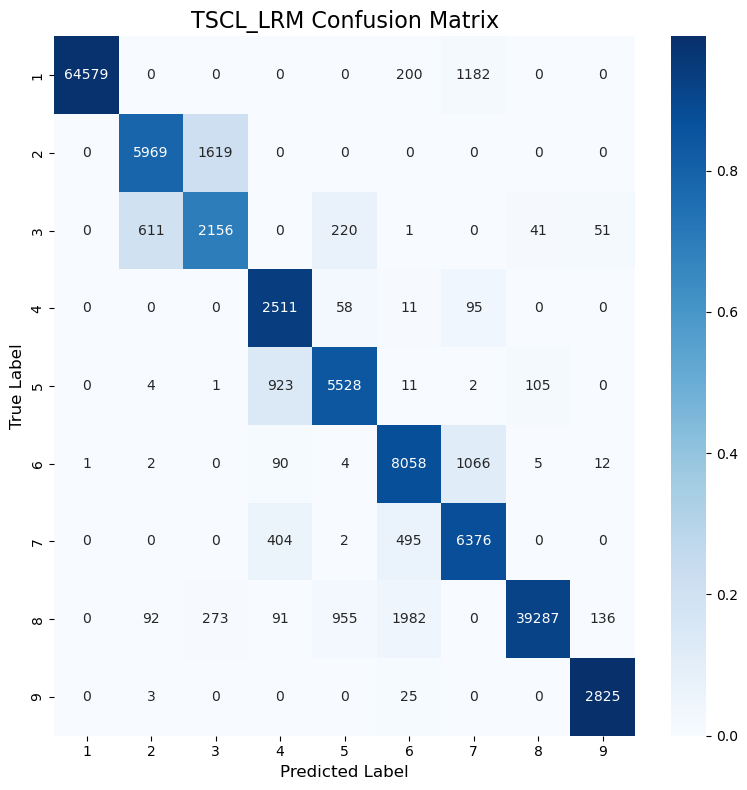

Classification Accuracy: 92.72%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


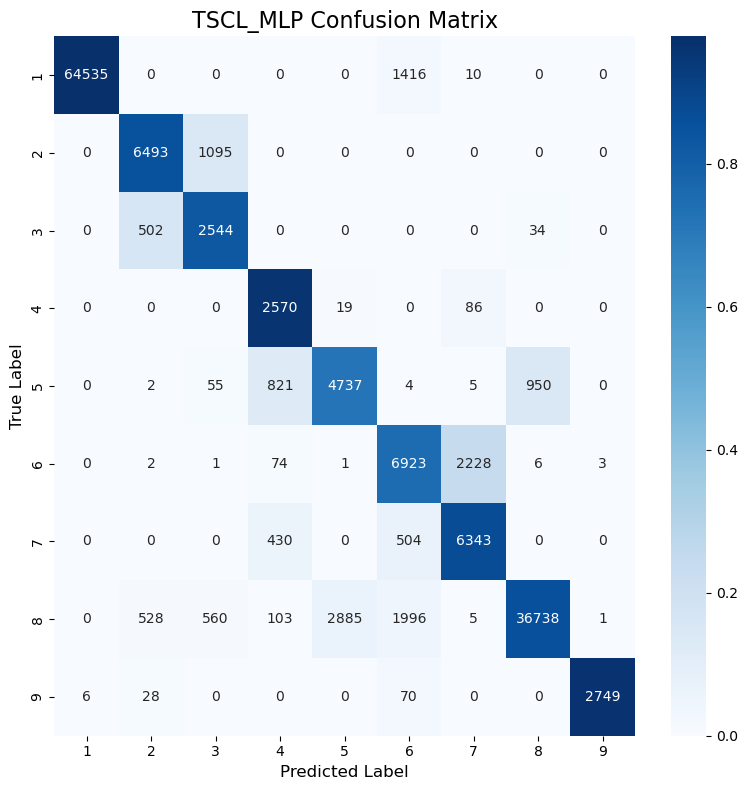

Classification Accuracy: 90.25%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


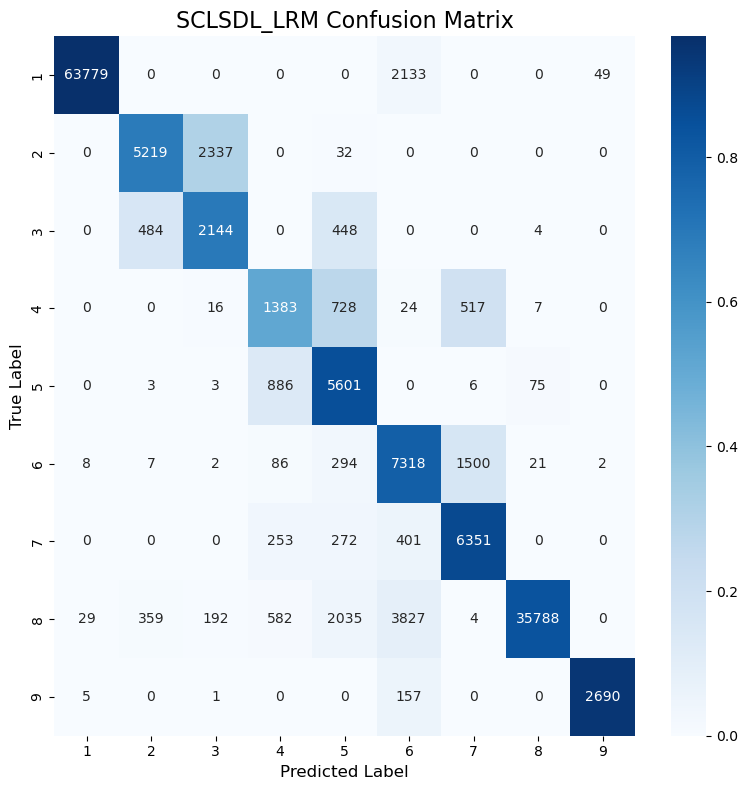

Classification Accuracy: 87.99%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


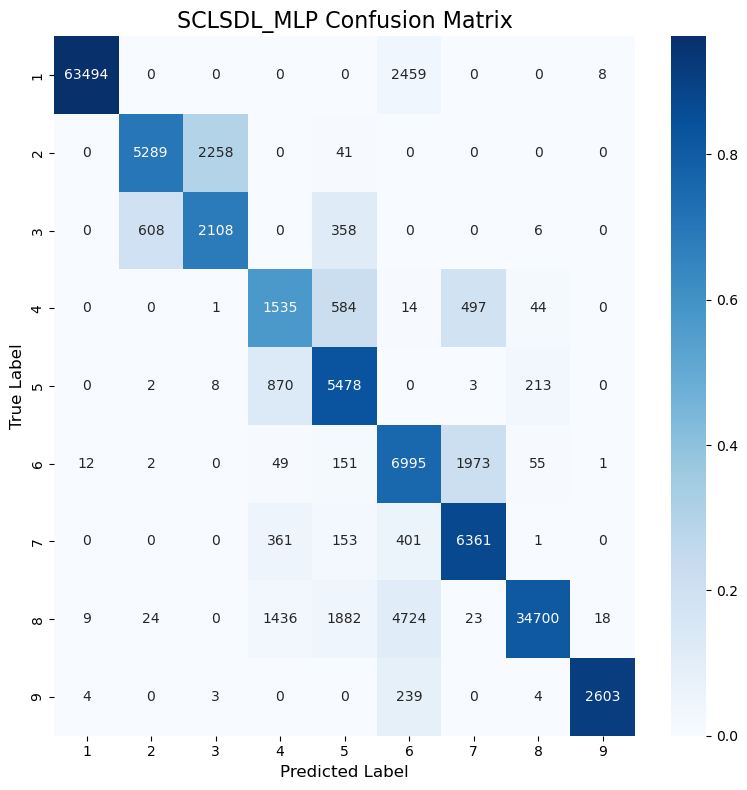

Classification Accuracy: 86.83%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          95.07
1    LRM (CAE)          90.86
2    MLP (CAE)          90.18
3     TSCL LRM          92.72
4     TSCL MLP          90.25
5  SCL_SDL LRM          87.99
6  SCL_SDL MLP          86.83

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          95.07
3     TSCL LRM          92.72
1    LRM (CAE)          90.86
4     TSCL MLP          90.25
2    MLP (CAE)          90.18
5  SCL_SDL LRM          87.99
6  SCL_SDL MLP          86.83
